# Setup

In [1]:
# Imports
import mdptoolbox
import numpy as np
import scipy
import pandas as pd
import random
from IPython.utils import io
import progressbar
import matplotlib.pyplot as plt

In [2]:
# Read in card types and parameters
cards = pd.read_csv('cards.csv',header=0)
cards

Establishment  Type  Cost  Dice Roll  \
0                  Wheat Field     1     1          1   
1                        Ranch     1     1          2   
2                       Forest     1     3          5   
3                         Mine     1     6          9   
4                Apple Orchard     1     3         10   
5                       Bakery     2     1          2   
6                       Bakery     2     1          3   
7            Convenience Store     2     2          4   
8               Cheese Factory     2     5          7   
9            Furniture Factory     2     3          8   
10  Fruit and Vegetable Market     2     2         11   
11  Fruit and Vegetable Market     2     2         12   

                               Earnings  Count  
0                                     1      6  
1                                     1      6  
2                                     1      6  
3                                     5      6  
4                                     3      6  
5                                     1      6  
6                                     1      6  
7                                     3      6  
8                           3 per ranch      6  
9                 3 per forest and mine      6  
10  2 per wheat field and apple orchard      6  
11  2 per wheat field and apple orchard      6

# Background functions for card likelihood and value calculations

In [3]:
# Function to calculate how good a card is to buy
def card_value(card, num_dice):
    rows = cards[cards['Establishment']==card]
    likelihood = 0
    for i in range(len(rows)):
        row = rows.iloc[i]

        # Likelihood of a card roll
        # Depends on the number of dice
        if num_dice == 1:
            probs = {1:1/6, 2:1/6, 3:1/6, 4:1/6, 5:1/6, 6:1/6, 7:0/36, 
                    8:0/36, 9:0/36, 10:0/36, 11:0/36, 12:0/36}
        elif num_dice == 2:
            probs = {1: 0/36, 2:1/36, 3:2/36, 4:3/36, 5:4/36, 6:5/36, 
                     7:6/36, 8:5/36, 9:4/36, 10:3/36, 11:2/36, 12:1/36}
        likelihood += probs[int(row['Dice Roll'])]

        # Cost of the card
        cost = row['Cost']

        # Earnings of the card
        if card == 'Cheese Factory':
            earnings = 3
        elif card == 'Furniture Factory':
            earnings = 3
        elif card == 'Fruit and Vegetable Market':
            earnings = 2
        else:
            earnings = int(row['Earnings'])

    return likelihood, earnings, cost

In [4]:
# Function to determine how many dice to use
def choose_dice(num_dice, current_cards):
    probs1 = {1:1/6, 2:1/6, 3:1/6, 4:1/6, 5:1/6, 6:1/6, 7:0/36, 8:0/36, 9:0/36, 10:0/36, 11:0/36, 12:0/36}
    probs2 = {1: 0/36, 2:1/36, 3:2/36, 4:3/36, 5:4/36, 6:5/36, 7:6/36, 8:5/36, 9:4/36, 10:3/36, 11:2/36, 12:1/36}
    
    if num_dice == 1:
        return num_dice
    elif num_dice == 2:
        dice_vote = [0,0]
        for card in current_cards:
            for row in cards[cards['Establishment']==card]['Dice Roll']:
                if (probs1[row] > probs2[row]) and player_dice==2:
                    dice_vote[0] += 1
                else:
                    dice_vote[1] += 1
        return (np.argmax(dice_vote)+1)

# Game Initialization

In [5]:
# Generate middle pool of cards
all_cards = ['Wheat Field']*6 + ['Ranch']*6 + ['Forest']*6 + ['Mine']*6 + ['Apple Orchard']*6 + ['Bakery']*6 + ['Convenience Store']*6 + ['Cheese Factory']*6 + ['Furniture Factory']*6 + ['Fruit and Vegetable Market']*6
card_stack = random.sample(all_cards, 60)
current_pool = card_stack[0:6]
del card_stack[0:6]

In [6]:
# Initialize the Game
player_cards = ['Wheat Field', 'Bakery']
player_coins = 3
player_landmarks = 0
player_dice = 1

computer_cards = ['Wheat Field', 'Bakery']
computer_coins = 3
computer_landmarks = 0
computer_dice = 1

upgrade_costs = [4, 10, 16, 22]

current_player = 'player'

# Play a game until someone wins with the reward vectors:
## (0, 1, 2, 3, 4) for purchases and passing

In [7]:
# Play until someone wins

# This method uses fixed rewards for all decisions, with increasing rewards for additional landmarks. (0, 1, 2, 3, 4)

number_of_turns = 0
while (player_landmarks < 4) and (computer_landmarks < 4): 
    number_of_turns += 1

    if current_player == 'player':
        num_dice = choose_dice(player_dice, player_cards)
    elif current_player == 'computer':
        num_dice = choose_dice(computer_dice, computer_cards)

    print(current_player + " is rolling " + str(num_dice) + " dice.")
    # Roll the dice - either 1 or 2 depending on whether the Train Station is unlocked
    if num_dice == 1:
        dice_roll = np.random.choice([1,2,3,4,5])
    elif num_dice == 2:
        dice_roll = np.random.choice([2,3,4,5,6,7,8,9,10,11,12], 
                                     p=[1/36, 2/36, 3/36, 4/36, 5/36, 6/36, 
                                        5/36, 4/36, 3/36, 2/36, 1/36])

    print(current_player + " rolled a " + str(dice_roll))

    # Add coins if the player has that Establishment, according to the card types
    if current_player == 'player':
        # If the player rolled
        for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
            if row['Type'] == 1:
                # Everyone with the Establishment earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                if row['Establishment'] in computer_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
            elif row['Type'] == 2:
                # Only the person who rolled earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
    elif current_player == 'computer':
        # If the computer rolled
        for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
            if row['Type'] == 1:
                # Everyone with the Establishment earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                if row['Establishment'] in computer_cards: 
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
            elif row['Type'] == 2:
                if row['Establishment'] in computer_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])

    if current_player == 'player':
        if player_coins == 0:
            player_coins += 1
            print("player earned 1 coin for having none")
    elif current_player == 'computer':
        if computer_coins == 0:
            computer_coins += 1
            print("computer earned 1 coin for having none")

    print("\nCurrent Score:")
    print("Player:")
    print("Player Cards: " + str(player_cards))
    print("Player Coins: " + str(player_coins))
    print("Player Landmarks: " + str(player_landmarks))

    print("Computer:")
    print("Computer Cards: " + str(computer_cards))
    print("Computer Coins: " + str(computer_coins))
    print("Computer Landmarks: " + str(computer_landmarks))


    # Choice of construction (or pass)
    # 1) Construct options based on current coin bank
    if current_player == 'player':
        can_buy = cards[(cards['Cost']<=player_coins) & (cards['Establishment'].isin(current_pool))]
        can_upgrade = upgrade_costs[player_landmarks] <= player_coins
    elif current_player == 'computer':
        can_buy = cards[(cards['Cost']<=computer_coins) & (cards['Establishment'].isin(current_pool))]
        can_upgrade = upgrade_costs[computer_landmarks] <= computer_coins


    # 2) Create probability distributions and reward vectors
    # Calculate how likely transition to next state is based on current card holdings
    transition_probabilities_current = np.zeros(4)
    if current_player == 'player':
        for card in player_cards:
            likelihood, earnings, cost = card_value(card, num_dice)
            if card == 'Cheese Factory':
                earnings = earnings*player_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
            transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))
    elif current_player == 'computer':
        for card in computer_cards:
            likelihood, earnings, cost = card_value(card, num_dice)
            if card == 'Cheese Factory':
                earnings = earnings*computer_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
            transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))

    print("\nCurrent transition probabilities:")
    print(transition_probabilities_current)

    # Get the probabilities into the expected matrix form 
    Ps = []
    Pmat = []
    for i in range(0,4):
        Pmat_row = []
        for j in range(0,5):
            if j == i:
                Pmat_row.append(1-transition_probabilities_current[i])
            elif j == i+1:
                Pmat_row.append(transition_probabilities_current[i])
            else: 
                Pmat_row.append(0.)
        Pmat.append(Pmat_row)
    Pmat.append([0.,0.,0.,0.,1])
    Ps.append(Pmat)


    # Calculate how likely transition to next state is for each card that can be purchased
    for index, row in can_buy.iterrows():
        likelihood, earnings, cost = card_value(row['Establishment'], num_dice)
        if current_player == 'player':
            if card == 'Cheese Factory':
                earnings = earnings*player_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
            elif card == 'Ranch' and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Cheese Factory')*3)
                likelihood += 6/36
            elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Furniture Factory')*3)
                likelihood += 7/36
            elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Fruit and Vegetable Market')*2)
                likelihood += 3/36
        elif current_player == 'computer':
            if card == 'Cheese Factory':
                earnings = earnings*computer_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
            elif card == 'Ranch' and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Cheese Factory')*3)
                likelihood += 6/36
            elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Furniture Factory')*3)
                likelihood += 7/36
            elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Fruit and Vegetable Market')*2)
                likelihood += 3/36
        print("Buying the card: " + row['Establishment'] + " results in the following improvement")
        possible_new_probabilities = transition_probabilities_current + ((likelihood*earnings)/np.array(upgrade_costs))
        print(possible_new_probabilities)
        print("The one time cost is " + str(row['Cost']))

        Pmat = []
        for i in range(0,4):
            Pmat_row = []
            for j in range(0,5):
                if j == i:
                    Pmat_row.append(1-possible_new_probabilities[i])
                elif j == i+1:
                    Pmat_row.append(possible_new_probabilities[i])
                else: 
                    Pmat_row.append(0.)
            Pmat.append(Pmat_row)
        Pmat.append([0.,0.,0.,0.,1])
        Ps.append(Pmat)

    # 3) MDP of choices with a discount factor of 0.9

    # Compare the policies of:
    # 1) Doing nothing
    # 2) Buy one of the cards in the central pool
    Ps = np.array(Ps)
    Rs = np.array([[0.]*len(Ps),[1.]*len(Ps),[2.]*len(Ps),[3.]*len(Ps),[4.]*len(Ps)])

    vi = mdptoolbox.mdp.ValueIteration(Ps, Rs, 0.9) #discount value of 0.9
    vi.run()

    if current_player == 'player':
        policy = vi.policy[player_landmarks]
    elif current_player == 'computer':
        policy = vi.policy[computer_landmarks]

    if can_upgrade:
        print("\n" + current_player + " will upgrade.")
        # Increase landmarks
        # Decrease coins
        if current_player == 'player':
            player_coins -= upgrade_costs[player_landmarks]
            player_landmarks += 1
        elif current_player == 'computer':
            computer_coins -= upgrade_costs[computer_landmarks]
            computer_landmarks += 1
    else:
        print("\nThe best policy is: " + str(policy))
        if policy==0:
            print(current_player + " will pass.")
        else:
            # 4) Subtract from coin bank and add to holdings if relevant
            # subtract coins from the player's bank
            # add the card to the player's holdings
            print(current_player + " will buy:")
            to_buy = list(can_buy['Establishment'])[policy-1]
            print(to_buy)
            if current_player == 'player':
                player_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                player_cards.append(to_buy)
            elif current_player == 'computer':
                computer_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                computer_cards.append(to_buy)

            # pop the card from the current pool
            current_pool.pop(current_pool.index(to_buy))

            # add a new card to the current pool and pop it from the full list of remaining cards
            current_pool.append(card_stack[0])
            card_stack.pop(0)

    # Increase the number of dice if someone has unlocked the first landmark
    if player_landmarks>=1:
        player_dice = 2
    if computer_landmarks>=1:
        computer_dice = 2


    # Switch players
    if current_player == 'player':
        current_player = 'computer'
    elif current_player == 'computer':
        current_player = 'player'


    # Determine when someone has won
    if player_landmarks==4:
        print("Game over. player has won!")
    elif computer_landmarks==4:
        print("Game over. computer has won!")
        
    print("\n\n")

print("This took " + str(number_of_turns) + " turns.")

player is rolling 1 dice.
player rolled a 1
player earned 1 for having a Wheat Field
computer earned 1 for having a Wheat Field

Current Score:
Player:
Player Cards: ['Wheat Field', 'Bakery']
Player Coins: 4
Player Landmarks: 0
Computer:
Computer Cards: ['Wheat Field', 'Bakery']
Computer Coins: 4
Computer Landmarks: 0

Current transition probabilities:
[0.125      0.05       0.03125    0.02272727]
Buying the card: Wheat Field results in the following improvement
[0.16666667 0.06666667 0.04166667 0.03030303]
The one time cost is 1
Buying the card: Apple Orchard results in the following improvement
[0.125      0.05       0.03125    0.02272727]
The one time cost is 3
Buying the card: Bakery results in the following improvement
[0.20833333 0.08333333 0.05208333 0.03787879]
The one time cost is 1
Buying the card: Bakery results in the following improvement
[0.20833333 0.08333333 0.05208333 0.03787879]
The one time cost is 1
Buying the card: Furniture Factory results in the following improve


The best policy is: 0
player will pass.



computer is rolling 1 dice.
computer rolled a 3
computer earned 1 for having a Bakery

Current Score:
Player:
Player Cards: ['Wheat Field', 'Bakery', 'Bakery', 'Convenience Store', 'Ranch']
Player Coins: 5
Player Landmarks: 2
Computer:
Computer Cards: ['Wheat Field', 'Bakery', 'Wheat Field', 'Ranch']
Computer Coins: 7
Computer Landmarks: 1

Current transition probabilities:
[0.20833333 0.08333333 0.05208333 0.03787879]
Buying the card: Mine results in the following improvement
[0.20833333 0.08333333 0.05208333 0.03787879]
The one time cost is 6
Buying the card: Apple Orchard results in the following improvement
[0.20833333 0.08333333 0.05208333 0.03787879]
The one time cost is 3
Buying the card: Furniture Factory results in the following improvement
[0.20833333 0.08333333 0.05208333 0.03787879]
The one time cost is 3

The best policy is: 0
computer will pass.



player is rolling 1 dice.
player rolled a 5

Current Score:
Player:
Player Cards:

Current transition probabilities:
[0.375      0.15       0.09375    0.06818182]
Buying the card: Apple Orchard results in the following improvement
[0.375      0.15       0.09375    0.06818182]
The one time cost is 3
Buying the card: Furniture Factory results in the following improvement
[0.375      0.15       0.09375    0.06818182]
The one time cost is 3

The best policy is: 0
player will pass.



computer is rolling 1 dice.
computer rolled a 5

Current Score:
Player:
Player Cards: ['Wheat Field', 'Bakery', 'Bakery', 'Convenience Store', 'Ranch']
Player Coins: 3
Player Landmarks: 3
Computer:
Computer Cards: ['Wheat Field', 'Bakery', 'Wheat Field', 'Ranch']
Computer Coins: 10
Computer Landmarks: 2

Current transition probabilities:
[0.20833333 0.08333333 0.05208333 0.03787879]
Buying the card: Mine results in the following improvement
[0.20833333 0.08333333 0.05208333 0.03787879]
The one time cost is 6
Buying the card: Apple Orchard results in the following improvement
[0.20833333 0.08

Current transition probabilities:
[0.375      0.15       0.09375    0.06818182]
Buying the card: Mine results in the following improvement
[0.375      0.15       0.09375    0.06818182]
The one time cost is 6
Buying the card: Apple Orchard results in the following improvement
[0.375      0.15       0.09375    0.06818182]
The one time cost is 3
Buying the card: Furniture Factory results in the following improvement
[0.375      0.15       0.09375    0.06818182]
The one time cost is 3

The best policy is: 0
player will pass.



computer is rolling 1 dice.
computer rolled a 2
player earned 1 for having a Ranch
computer earned 1 for having a Ranch
computer earned 1 for having a Bakery

Current Score:
Player:
Player Cards: ['Wheat Field', 'Bakery', 'Bakery', 'Convenience Store', 'Ranch']
Player Coins: 22
Player Landmarks: 3
Computer:
Computer Cards: ['Wheat Field', 'Bakery', 'Wheat Field', 'Ranch']
Computer Coins: 10
Computer Landmarks: 3

Current transition probabilities:
[0.20833333 0.08333

# Play a game until someone wins with the reward vectors:
## (0, 1, 2, 3, 4) for purchases 
## (0, 2, 4, 6, 8) for passing

In [ ]:
# Play until someone wins

# This method uses fixed rewards for all decisions, with increasing rewards for additional landmarks 0, 1, 2, 3, 4
# *except* for the reward for doing nothing, which has values 0, 2, 4, 6, 8

number_of_turns = 0
while (player_landmarks < 4) and (computer_landmarks < 4): 
    number_of_turns += 1
    
    if current_player == 'player':
        num_dice = choose_dice(player_dice, player_cards)
    elif current_player == 'computer':
        num_dice = choose_dice(computer_dice, computer_cards)

    print(current_player + " is rolling " + str(num_dice) + " dice.")
    # Roll the dice - either 1 or 2 depending on whether the Train Station is unlocked
    if num_dice == 1:
        dice_roll = np.random.choice([1,2,3,4,5])
    elif num_dice == 2:
        dice_roll = np.random.choice([2,3,4,5,6,7,8,9,10,11,12], 
                                     p=[1/36, 2/36, 3/36, 4/36, 5/36, 6/36, 
                                        5/36, 4/36, 3/36, 2/36, 1/36])

    print(current_player + " rolled a " + str(dice_roll))

    # Add coins if the player has that Establishment, according to the card types
    if current_player == 'player':
        # If the player rolled
        for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
            if row['Type'] == 1:
                # Everyone with the Establishment earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                if row['Establishment'] in computer_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
            elif row['Type'] == 2:
                # Only the person who rolled earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
    elif current_player == 'computer':
        # If the computer rolled
        for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
            if row['Type'] == 1:
                # Everyone with the Establishment earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                if row['Establishment'] in computer_cards: 
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
            elif row['Type'] == 2:
                if row['Establishment'] in computer_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])

    if current_player == 'player':
        if player_coins == 0:
            player_coins += 1
            print("player earned 1 coin for having none")
    elif current_player == 'computer':
        if computer_coins == 0:
            computer_coins += 1
            print("computer earned 1 coin for having none")

    print("\nCurrent Score:")
    print("Player:")
    print("Player Cards: " + str(player_cards))
    print("Player Coins: " + str(player_coins))
    print("Player Landmarks: " + str(player_landmarks))

    print("Computer:")
    print("Computer Cards: " + str(computer_cards))
    print("Computer Coins: " + str(computer_coins))
    print("Computer Landmarks: " + str(computer_landmarks))


    # Choice of construction (or pass)
    # 1) Construct options based on current coin bank
    if current_player == 'player':
        can_buy = cards[(cards['Cost']<=player_coins) & (cards['Establishment'].isin(current_pool))]
        can_upgrade = upgrade_costs[player_landmarks] <= player_coins
    elif current_player == 'computer':
        can_buy = cards[(cards['Cost']<=computer_coins) & (cards['Establishment'].isin(current_pool))]
        can_upgrade = upgrade_costs[computer_landmarks] <= computer_coins


    # 2) Create probability distributions and reward vectors
    # Calculate how likely transition to next state is based on current card holdings
    transition_probabilities_current = np.zeros(4)
    if current_player == 'player':
        for card in player_cards:
            likelihood, earnings, cost = card_value(card, num_dice)
            if card == 'Cheese Factory':
                earnings = earnings*player_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
            transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))
    elif current_player == 'computer':
        for card in computer_cards:
            likelihood, earnings, cost = card_value(card, num_dice)
            if card == 'Cheese Factory':
                earnings = earnings*computer_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
            transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))

    print("\nCurrent transition probabilities:")
    print(transition_probabilities_current)

    # Get the probabilities into the expected matrix form 
    Ps = []
    Pmat = []
    for i in range(0,4):
        Pmat_row = []
        for j in range(0,5):
            if j == i:
                Pmat_row.append(1-transition_probabilities_current[i])
            elif j == i+1:
                Pmat_row.append(transition_probabilities_current[i])
            else: 
                Pmat_row.append(0.)
        Pmat.append(Pmat_row)
    Pmat.append([0.,0.,0.,0.,1])
    Ps.append(Pmat)


    # Calculate how likely transition to next state is for each card that can be purchased
    for index, row in can_buy.iterrows():
        likelihood, earnings, cost = card_value(row['Establishment'], num_dice)
        if current_player == 'player':
            if card == 'Cheese Factory':
                earnings = earnings*player_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
            elif card == 'Ranch' and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Cheese Factory')*3)
                likelihood += 6/36
            elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Furniture Factory')*3)
                likelihood += 7/36
            elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Fruit and Vegetable Market')*2)
                likelihood += 3/36
        elif current_player == 'computer':
            if card == 'Cheese Factory':
                earnings = earnings*computer_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
            elif card == 'Ranch' and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Cheese Factory')*3)
                likelihood += 6/36
            elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Furniture Factory')*3)
                likelihood += 7/36
            elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Fruit and Vegetable Market')*2)
                likelihood += 3/36
        print("Buying the card: " + row['Establishment'] + " results in the following improvement")
        possible_new_probabilities = transition_probabilities_current + ((likelihood*earnings)/np.array(upgrade_costs))
        print(possible_new_probabilities)
        print("The one time cost is " + str(row['Cost']))

        Pmat = []
        for i in range(0,4):
            Pmat_row = []
            for j in range(0,5):
                if j == i:
                    Pmat_row.append(1-possible_new_probabilities[i])
                elif j == i+1:
                    Pmat_row.append(possible_new_probabilities[i])
                else: 
                    Pmat_row.append(0.)
            Pmat.append(Pmat_row)
        Pmat.append([0.,0.,0.,0.,1])
        Ps.append(Pmat)

    # 3) MDP of choices with a discount factor of 0.9

    # Compare the policies of:
    # 1) Doing nothing
    # 2) Buy one of the cards in the central pool
    Ps = np.array(Ps)
    Rs = np.array([[0.]+[0.]*(len(Ps)-1),[2.]+[1.]*(len(Ps)-1),[4.]+[2.]*(len(Ps)-1),[6.]+[3.]*(len(Ps)-1),[8.]+[4.]*(len(Ps)-1)])

    vi = mdptoolbox.mdp.ValueIteration(Ps, Rs, 0.9) #discount value of 0.9
    vi.run()

    if current_player == 'player':
        policy = vi.policy[player_landmarks]
    elif current_player == 'computer':
        policy = vi.policy[computer_landmarks]

    if can_upgrade:
        print("\n" + current_player + " will upgrade.")
        # Increase landmarks
        # Decrease coins
        if current_player == 'player':
            player_coins -= upgrade_costs[player_landmarks]
            player_landmarks += 1
        elif current_player == 'computer':
            computer_coins -= upgrade_costs[computer_landmarks]
            computer_landmarks += 1
    else:
        print("\nThe best policy is: " + str(policy))
        if policy==0:
            print(current_player + " will pass.")
        else:
            # 4) Subtract from coin bank and add to holdings if relevant
            # subtract coins from the player's bank
            # add the card to the player's holdings
            print(current_player + " will buy:")
            to_buy = list(can_buy['Establishment'])[policy-1]
            print(to_buy)
            if current_player == 'player':
                player_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                player_cards.append(to_buy)
            elif current_player == 'computer':
                computer_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                computer_cards.append(to_buy)

            # pop the card from the current pool
            current_pool.pop(current_pool.index(to_buy))

            # add a new card to the current pool and pop it from the full list of remaining cards
            current_pool.append(card_stack[0])
            card_stack.pop(0)

    # Increase the number of dice if someone has unlocked the first landmark
    if player_landmarks>=1:
        player_dice = 2
    if computer_landmarks>=1:
        computer_dice = 2


    # Switch players
    if current_player == 'player':
        current_player = 'computer'
    elif current_player == 'computer':
        current_player = 'player'


    # Determine when someone has won
    if player_landmarks==4:
        print("Game over. player has won!")
    elif computer_landmarks==4:
        print("Game over. computer has won!")
        
    print("\n\n")

print("This took " + str(number_of_turns) + " turns.")

# Play a game until someone wins with the reward vectors:
## (1, 2, 3, 4, 5) for purchases 
## (1, 2, 6, 8, 10) for passing

In [ ]:
# Play until someone wins

# This method uses fixed rewards for all decisions, with increasing rewards for additional landmarks 1, 2, 3, 4, 5
# *except* for the reward for doing nothing, which has values 1, 2, 6, 8, 10

number_of_turns = 0
while (player_landmarks < 4) and (computer_landmarks < 4): 
    number_of_turns += 1
    
    if current_player == 'player':
        num_dice = choose_dice(player_dice, player_cards)
    elif current_player == 'computer':
        num_dice = choose_dice(computer_dice, computer_cards)

    print(current_player + " is rolling " + str(num_dice) + " dice.")
    # Roll the dice - either 1 or 2 depending on whether the Train Station is unlocked
    if num_dice == 1:
        dice_roll = np.random.choice([1,2,3,4,5])
    elif num_dice == 2:
        dice_roll = np.random.choice([2,3,4,5,6,7,8,9,10,11,12], 
                                     p=[1/36, 2/36, 3/36, 4/36, 5/36, 6/36, 
                                        5/36, 4/36, 3/36, 2/36, 1/36])

    print(current_player + " rolled a " + str(dice_roll))

    # Add coins if the player has that Establishment, according to the card types
    if current_player == 'player':
        # If the player rolled
        for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
            if row['Type'] == 1:
                # Everyone with the Establishment earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                if row['Establishment'] in computer_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
            elif row['Type'] == 2:
                # Only the person who rolled earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
    elif current_player == 'computer':
        # If the computer rolled
        for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
            if row['Type'] == 1:
                # Everyone with the Establishment earns coins
                if row['Establishment'] in player_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                    player_coins += int(earnings)
                    print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                if row['Establishment'] in computer_cards: 
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
            elif row['Type'] == 2:
                if row['Establishment'] in computer_cards:
                    if row['Establishment'] == 'Cheese Factory':
                        earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                    elif row['Establishment'] == 'Furniture Factory':
                        earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                    elif row['Establishment'] == 'Fruit and Vegetable Market':
                        earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                    else:
                        earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                    computer_coins += int(earnings)
                    print("computer earned " + str(earnings) + " for having a " + row['Establishment'])

    if current_player == 'player':
        if player_coins == 0:
            player_coins += 1
            print("player earned 1 coin for having none")
    elif current_player == 'computer':
        if computer_coins == 0:
            computer_coins += 1
            print("computer earned 1 coin for having none")

    print("\nCurrent Score:")
    print("Player:")
    print("Player Cards: " + str(player_cards))
    print("Player Coins: " + str(player_coins))
    print("Player Landmarks: " + str(player_landmarks))

    print("Computer:")
    print("Computer Cards: " + str(computer_cards))
    print("Computer Coins: " + str(computer_coins))
    print("Computer Landmarks: " + str(computer_landmarks))


    # Choice of construction (or pass)
    # 1) Construct options based on current coin bank
    if current_player == 'player':
        can_buy = cards[(cards['Cost']<=player_coins) & (cards['Establishment'].isin(current_pool))]
        can_upgrade = upgrade_costs[player_landmarks] <= player_coins
    elif current_player == 'computer':
        can_buy = cards[(cards['Cost']<=computer_coins) & (cards['Establishment'].isin(current_pool))]
        can_upgrade = upgrade_costs[computer_landmarks] <= computer_coins


    # 2) Create probability distributions and reward vectors
    # Calculate how likely transition to next state is based on current card holdings
    transition_probabilities_current = np.zeros(4)
    if current_player == 'player':
        for card in player_cards:
            likelihood, earnings, cost = card_value(card, num_dice)
            if card == 'Cheese Factory':
                earnings = earnings*player_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
            transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))
    elif current_player == 'computer':
        for card in computer_cards:
            likelihood, earnings, cost = card_value(card, num_dice)
            if card == 'Cheese Factory':
                earnings = earnings*computer_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
            transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))

    print("\nCurrent transition probabilities:")
    print(transition_probabilities_current)

    # Get the probabilities into the expected matrix form 
    Ps = []
    Pmat = []
    for i in range(0,4):
        Pmat_row = []
        for j in range(0,5):
            if j == i:
                Pmat_row.append(1-transition_probabilities_current[i])
            elif j == i+1:
                Pmat_row.append(transition_probabilities_current[i])
            else: 
                Pmat_row.append(0.)
        Pmat.append(Pmat_row)
    Pmat.append([0.,0.,0.,0.,1])
    Ps.append(Pmat)


    # Calculate how likely transition to next state is for each card that can be purchased
    for index, row in can_buy.iterrows():
        likelihood, earnings, cost = card_value(row['Establishment'], num_dice)
        if current_player == 'player':
            if card == 'Cheese Factory':
                earnings = earnings*player_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
            elif card == 'Ranch' and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Cheese Factory')*3)
                likelihood += 6/36
            elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Furniture Factory')*3)
                likelihood += 7/36
            elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                earnings += (player_cards.count(card)*player_cards.count('Fruit and Vegetable Market')*2)
                likelihood += 3/36
        elif current_player == 'computer':
            if card == 'Cheese Factory':
                earnings = earnings*computer_cards.count('Ranch')
            elif card == 'Furniture Factory':
                earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
            elif card == 'Fruit and Vegetable Market':
                earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
            elif card == 'Ranch' and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Cheese Factory')*3)
                likelihood += 6/36
            elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Furniture Factory')*3)
                likelihood += 7/36
            elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                earnings += (computer_cards.count(card)*computer_cards.count('Fruit and Vegetable Market')*2)
                likelihood += 3/36
        print("Buying the card: " + row['Establishment'] + " results in the following improvement")
        possible_new_probabilities = transition_probabilities_current + ((likelihood*earnings)/np.array(upgrade_costs))
        print(possible_new_probabilities)
        print("The one time cost is " + str(row['Cost']))

        Pmat = []
        for i in range(0,4):
            Pmat_row = []
            for j in range(0,5):
                if j == i:
                    Pmat_row.append(1-possible_new_probabilities[i])
                elif j == i+1:
                    Pmat_row.append(possible_new_probabilities[i])
                else: 
                    Pmat_row.append(0.)
            Pmat.append(Pmat_row)
        Pmat.append([0.,0.,0.,0.,1])
        Ps.append(Pmat)

    # 3) MDP of choices with a discount factor of 0.9

    # Compare the policies of:
    # 1) Doing nothing
    # 2) Buy one of the cards in the central pool
    Ps = np.array(Ps)
    Rs = np.array([[1.]+[1.]*(len(Ps)-1),[2.]+[2.]*(len(Ps)-1),[5.]+[3.]*(len(Ps)-1),[8.]+[4.]*(len(Ps)-1),[10.]+[5.]*(len(Ps)-1)])

    vi = mdptoolbox.mdp.ValueIteration(Ps, Rs, 0.9) #discount value of 0.9
    vi.run()

    if current_player == 'player':
        policy = vi.policy[player_landmarks]
    elif current_player == 'computer':
        policy = vi.policy[computer_landmarks]

    if can_upgrade:
        print("\n" + current_player + " will upgrade.")
        # Increase landmarks
        # Decrease coins
        if current_player == 'player':
            player_coins -= upgrade_costs[player_landmarks]
            player_landmarks += 1
        elif current_player == 'computer':
            computer_coins -= upgrade_costs[computer_landmarks]
            computer_landmarks += 1
    else:
        print("\nThe best policy is: " + str(policy))
        if policy==0:
            print(current_player + " will pass.")
        else:
            # 4) Subtract from coin bank and add to holdings if relevant
            # subtract coins from the player's bank
            # add the card to the player's holdings
            print(current_player + " will buy:")
            to_buy = list(can_buy['Establishment'])[policy-1]
            print(to_buy)
            if current_player == 'player':
                player_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                player_cards.append(to_buy)
            elif current_player == 'computer':
                computer_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                computer_cards.append(to_buy)

            # pop the card from the current pool
            current_pool.pop(current_pool.index(to_buy))

            # add a new card to the current pool and pop it from the full list of remaining cards
            current_pool.append(card_stack[0])
            card_stack.pop(0)

    # Increase the number of dice if someone has unlocked the first landmark
    if player_landmarks>=1:
        player_dice = 2
    if computer_landmarks>=1:
        computer_dice = 2


    # Switch players
    if current_player == 'player':
        current_player = 'computer'
    elif current_player == 'computer':
        current_player = 'player'


    # Determine when someone has won
    if player_landmarks==4:
        print("Game over. player has won!")
    elif computer_landmarks==4:
        print("Game over. computer has won!")
        
    print("\n\n")

print("This took " + str(number_of_turns) + " turns.")

# Reward Space Testing

In [8]:
# Helper function which plays a game to completion with a specified reward vector
def play_game_with_custom_reward(r):
    
    # Initialize game
    winner = ''
    
    # Generate middle pool of cards
    all_cards = ['Wheat Field']*6 + ['Ranch']*6 + ['Forest']*6 + ['Mine']*6 + ['Apple Orchard']*6 + ['Bakery']*6 + ['Convenience Store']*6 + ['Cheese Factory']*6 + ['Furniture Factory']*6 + ['Fruit and Vegetable Market']*6
    card_stack = random.sample(all_cards, 60)
    current_pool = card_stack[0:6]
    del card_stack[0:6]
    
    
    # Initialize the Game
    player_cards = ['Wheat Field', 'Bakery']
    player_coins = 3
    player_landmarks = 0
    player_dice = 1

    computer_cards = ['Wheat Field', 'Bakery']
    computer_coins = 3
    computer_landmarks = 0
    computer_dice = 1

    upgrade_costs = [4, 10, 16, 22]

    current_player = 'player'
    
    
    # Play until someone wins

    # This method uses fixed rewards for all decisions, with increasing rewards for additional landmarks. (0, 1, 2, 3, 4)

    number_of_turns = 0
    while (player_landmarks < 4) and (computer_landmarks < 4): 
        number_of_turns += 1

        if current_player == 'player':
            num_dice = choose_dice(player_dice, player_cards)
        elif current_player == 'computer':
            num_dice = choose_dice(computer_dice, computer_cards)

        print(current_player + " is rolling " + str(num_dice) + " dice.")
        # Roll the dice - either 1 or 2 depending on whether the Train Station is unlocked
        if num_dice == 1:
            dice_roll = np.random.choice([1,2,3,4,5])
        elif num_dice == 2:
            dice_roll = np.random.choice([2,3,4,5,6,7,8,9,10,11,12], 
                                         p=[1/36, 2/36, 3/36, 4/36, 5/36, 6/36, 
                                            5/36, 4/36, 3/36, 2/36, 1/36])

        print(current_player + " rolled a " + str(dice_roll))

        # Add coins if the player has that Establishment, according to the card types
        if current_player == 'player':
            # If the player rolled
            for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
                if row['Type'] == 1:
                    # Everyone with the Establishment earns coins
                    if row['Establishment'] in player_cards:
                        if row['Establishment'] == 'Cheese Factory':
                            earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                        elif row['Establishment'] == 'Furniture Factory':
                            earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                        elif row['Establishment'] == 'Fruit and Vegetable Market':
                            earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                        else:
                            earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                        player_coins += int(earnings)
                        print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                    if row['Establishment'] in computer_cards:
                        if row['Establishment'] == 'Cheese Factory':
                            earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                        elif row['Establishment'] == 'Furniture Factory':
                            earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                        elif row['Establishment'] == 'Fruit and Vegetable Market':
                            earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                        else:
                            earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                        computer_coins += int(earnings)
                        print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
                elif row['Type'] == 2:
                    # Only the person who rolled earns coins
                    if row['Establishment'] in player_cards:
                        if row['Establishment'] == 'Cheese Factory':
                            earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                        elif row['Establishment'] == 'Furniture Factory':
                            earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                        elif row['Establishment'] == 'Fruit and Vegetable Market':
                            earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                        else:
                            earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                        player_coins += int(earnings)
                        print("player earned " + str(earnings) + " for having a " + row['Establishment'])
        elif current_player == 'computer':
            # If the computer rolled
            for index, row in cards[cards['Dice Roll']==dice_roll].iterrows():
                if row['Type'] == 1:
                    # Everyone with the Establishment earns coins
                    if row['Establishment'] in player_cards:
                        if row['Establishment'] == 'Cheese Factory':
                            earnings = 3*player_cards.count('Cheese Factory')*player_cards.count('Ranch')
                        elif row['Establishment'] == 'Furniture Factory':
                            earnings = 3*player_cards.count('Furniture Factory')*(player_cards.count('Forest')+player_cards.count('Mine'))
                        elif row['Establishment'] == 'Fruit and Vegetable Market':
                            earnings = 2*player_cards.count('Fruit and Vegetable Market')*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                        else:
                            earnings = int(row['Earnings'])*player_cards.count(row['Establishment'])
                        player_coins += int(earnings)
                        print("player earned " + str(earnings) + " for having a " + row['Establishment'])
                    if row['Establishment'] in computer_cards: 
                        if row['Establishment'] == 'Cheese Factory':
                            earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                        elif row['Establishment'] == 'Furniture Factory':
                            earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                        elif row['Establishment'] == 'Fruit and Vegetable Market':
                            earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                        else:
                            earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                        computer_coins += int(earnings)
                        print("computer earned " + str(earnings) + " for having a " + row['Establishment'])
                elif row['Type'] == 2:
                    if row['Establishment'] in computer_cards:
                        if row['Establishment'] == 'Cheese Factory':
                            earnings = 3*computer_cards.count('Cheese Factory')*computer_cards.count('Ranch')
                        elif row['Establishment'] == 'Furniture Factory':
                            earnings = 3*computer_cards.count('Furniture Factory')*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                        elif row['Establishment'] == 'Fruit and Vegetable Market':
                            earnings = 2*computer_cards.count('Fruit and Vegetable Market')*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                        else:
                            earnings = int(row['Earnings'])*computer_cards.count(row['Establishment'])
                        computer_coins += int(earnings)
                        print("computer earned " + str(earnings) + " for having a " + row['Establishment'])

        if current_player == 'player':
            if player_coins == 0:
                player_coins += 1
                print("player earned 1 coin for having none")
        elif current_player == 'computer':
            if computer_coins == 0:
                computer_coins += 1
                print("computer earned 1 coin for having none")

        print("\nCurrent Score:")
        print("Player:")
        print("Player Cards: " + str(player_cards))
        print("Player Coins: " + str(player_coins))
        print("Player Landmarks: " + str(player_landmarks))

        print("Computer:")
        print("Computer Cards: " + str(computer_cards))
        print("Computer Coins: " + str(computer_coins))
        print("Computer Landmarks: " + str(computer_landmarks))


        # Choice of construction (or pass)
        # 1) Construct options based on current coin bank
        if current_player == 'player':
            can_buy = cards[(cards['Cost']<=player_coins) & (cards['Establishment'].isin(current_pool))]
            can_upgrade = upgrade_costs[player_landmarks] <= player_coins
        elif current_player == 'computer':
            can_buy = cards[(cards['Cost']<=computer_coins) & (cards['Establishment'].isin(current_pool))]
            can_upgrade = upgrade_costs[computer_landmarks] <= computer_coins


        # 2) Create probability distributions and reward vectors
        # Calculate how likely transition to next state is based on current card holdings
        transition_probabilities_current = np.zeros(4)
        if current_player == 'player':
            for card in player_cards:
                likelihood, earnings, cost = card_value(card, num_dice)
                if card == 'Cheese Factory':
                    earnings = earnings*player_cards.count('Ranch')
                elif card == 'Furniture Factory':
                    earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
                elif card == 'Fruit and Vegetable Market':
                    earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))
        elif current_player == 'computer':
            for card in computer_cards:
                likelihood, earnings, cost = card_value(card, num_dice)
                if card == 'Cheese Factory':
                    earnings = earnings*computer_cards.count('Ranch')
                elif card == 'Furniture Factory':
                    earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                elif card == 'Fruit and Vegetable Market':
                    earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                transition_probabilities_current += ((likelihood*earnings)/np.array(upgrade_costs))

        print("\nCurrent transition probabilities:")
        print(transition_probabilities_current)

        # Get the probabilities into the expected matrix form 
        Ps = []
        Pmat = []
        for i in range(0,4):
            Pmat_row = []
            for j in range(0,5):
                if j == i:
                    Pmat_row.append(1-transition_probabilities_current[i])
                elif j == i+1:
                    Pmat_row.append(transition_probabilities_current[i])
                else: 
                    Pmat_row.append(0.)
            Pmat.append(Pmat_row)
        Pmat.append([0.,0.,0.,0.,1])
        Ps.append(Pmat)


        # Calculate how likely transition to next state is for each card that can be purchased
        for index, row in can_buy.iterrows():
            likelihood, earnings, cost = card_value(row['Establishment'], num_dice)
            if current_player == 'player':
                if card == 'Cheese Factory':
                    earnings = earnings*player_cards.count('Ranch')
                elif card == 'Furniture Factory':
                    earnings = earnings*(player_cards.count('Forest')+player_cards.count('Mine'))
                elif card == 'Fruit and Vegetable Market':
                    earnings = earnings*(player_cards.count('Wheat Field')+player_cards.count('Apple Orchard'))
                elif card == 'Ranch' and num_dice == 2:
                    earnings += (player_cards.count(card)*player_cards.count('Cheese Factory')*3)
                    likelihood += 6/36
                elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                    earnings += (player_cards.count(card)*player_cards.count('Furniture Factory')*3)
                    likelihood += 7/36
                elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                    earnings += (player_cards.count(card)*player_cards.count('Fruit and Vegetable Market')*2)
                    likelihood += 3/36
            elif current_player == 'computer':
                if card == 'Cheese Factory':
                    earnings = earnings*computer_cards.count('Ranch')
                elif card == 'Furniture Factory':
                    earnings = earnings*(computer_cards.count('Forest')+computer_cards.count('Mine'))
                elif card == 'Fruit and Vegetable Market':
                    earnings = earnings*(computer_cards.count('Wheat Field')+computer_cards.count('Apple Orchard'))
                elif card == 'Ranch' and num_dice == 2:
                    earnings += (computer_cards.count(card)*computer_cards.count('Cheese Factory')*3)
                    likelihood += 6/36
                elif (card == 'Forest' or card == 'Mine') and num_dice == 2:
                    earnings += (computer_cards.count(card)*computer_cards.count('Furniture Factory')*3)
                    likelihood += 7/36
                elif (card == 'Wheat Field' or card == 'Apple Orchard') and num_dice == 2:
                    earnings += (computer_cards.count(card)*computer_cards.count('Fruit and Vegetable Market')*2)
                    likelihood += 3/36
            print("Buying the card: " + row['Establishment'] + " results in the following improvement")
            possible_new_probabilities = transition_probabilities_current + ((likelihood*earnings)/np.array(upgrade_costs))
            print(possible_new_probabilities)
            print("The one time cost is " + str(row['Cost']))

            Pmat = []
            for i in range(0,4):
                Pmat_row = []
                for j in range(0,5):
                    if j == i:
                        Pmat_row.append(1-possible_new_probabilities[i])
                    elif j == i+1:
                        Pmat_row.append(possible_new_probabilities[i])
                    else: 
                        Pmat_row.append(0.)
                Pmat.append(Pmat_row)
            Pmat.append([0.,0.,0.,0.,1])
            Ps.append(Pmat)

        # 3) MDP of choices with a discount factor of 0.9

        # Compare the policies of:
        # 1) Doing nothing
        # 2) Buy one of the cards in the central pool
        Ps = np.array(Ps)
        Rs = np.array([[r[0]]*len(Ps),[r[1]]*len(Ps),[r[2]]*len(Ps),[r[3]]*len(Ps),[r[4]]*len(Ps)])

        vi = mdptoolbox.mdp.ValueIteration(Ps, Rs, 0.9) #discount value of 0.9
        vi.run()

        if current_player == 'player':
            policy = vi.policy[player_landmarks]
        elif current_player == 'computer':
            policy = vi.policy[computer_landmarks]

        if can_upgrade:
            print("\n" + current_player + " will upgrade.")
            # Increase landmarks
            # Decrease coins
            if current_player == 'player':
                player_coins -= upgrade_costs[player_landmarks]
                player_landmarks += 1
            elif current_player == 'computer':
                computer_coins -= upgrade_costs[computer_landmarks]
                computer_landmarks += 1
        else:
            print("\nThe best policy is: " + str(policy))
            if policy==0:
                print(current_player + " will pass.")
            else:
                # 4) Subtract from coin bank and add to holdings if relevant
                # subtract coins from the player's bank
                # add the card to the player's holdings
                print(current_player + " will buy:")
                to_buy = list(can_buy['Establishment'])[policy-1]
                print(to_buy)
                if current_player == 'player':
                    player_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                    player_cards.append(to_buy)
                elif current_player == 'computer':
                    computer_coins -= int(list(can_buy[can_buy['Establishment']==to_buy]['Cost'])[0])
                    computer_cards.append(to_buy)

                # pop the card from the current pool
                current_pool.pop(current_pool.index(to_buy))

                # add a new card to the current pool and pop it from the full list of remaining cards
                current_pool.append(card_stack[0])
                card_stack.pop(0)

        # Increase the number of dice if someone has unlocked the first landmark
        if player_landmarks>=1:
            player_dice = 2
        if computer_landmarks>=1:
            computer_dice = 2


        # Switch players
        if current_player == 'player':
            current_player = 'computer'
        elif current_player == 'computer':
            current_player = 'player'


        # Determine when someone has won
        if player_landmarks==4:
            print("Game over. player has won!")
            winner = 'player'
        elif computer_landmarks==4:
            print("Game over. computer has won!")
            winner = 'computer'

        print("\n\n")

    print("This took " + str(number_of_turns) + " turns.")
    return number_of_turns, winner

In [10]:
# Explore the fixed reward space (static reward for passing and buying)
# reward space to explore - min, max, increment
all_turns = []
all_winners = []
rewards_tested = []
bar = progressbar.ProgressBar(maxval=10, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

for r1 in range(0,5):
    for r2 in range(0,5):
        for r3 in range(0,5):
            for r4 in range(0,5):
                for r5 in range(0,5):
                    cur_reward = [r1, r2, r3, r4, r5]

                    turns = []
                    winners = []
                    
                    print('testing ' + str(cur_reward))
                    bar.start()
                    
                    for i in range(0,10):
                        with io.capture_output() as captured:
                            try:
                                n, w = play_game_with_custom_reward(cur_reward)
                            except:
                                n = -1
                                w = 'fail'
                        turns.append(n)
                        winners.append(w)
                        bar.update(i)
                    
                    with open('turns.txt','w') as turns_doc:
                        turns_doc.write(", " + str(turns))
                    all_turns.append(turns)
                    with open('winners.txt','w') as winners_doc:
                        winners_doc.write(", " + str(winners))
                    all_winners.append(winners)
                    rewards_tested.append(cur_reward)
                    
bar.finish()

testing [0, 0, 0, 0, 0]
testing [0, 0, 0, 0, 1]


testing [0, 0, 0, 0, 2]


testing [0, 0, 0, 0, 3]


testing [0, 0, 0, 0, 4]


testing [0, 0, 0, 1, 0]


testing [0, 0, 0, 1, 1]


testing [0, 0, 0, 1, 2]


testing [0, 0, 0, 1, 3]


testing [0, 0, 0, 1, 4]


testing [0, 0, 0, 2, 0]


testing [0, 0, 0, 2, 1]


testing [0, 0, 0, 2, 2]


testing [0, 0, 0, 2, 3]


testing [0, 0, 0, 2, 4]


testing [0, 0, 0, 3, 0]


testing [0, 0, 0, 3, 1]


testing [0, 0, 0, 3, 2]


testing [0, 0, 0, 3, 3]


testing [0, 0, 0, 3, 4]


testing [0, 0, 0, 4, 0]


testing [0, 0, 0, 4, 1]


testing [0, 0, 0, 4, 2]


testing [0, 0, 0, 4, 3]


testing [0, 0, 0, 4, 4]


testing [0, 0, 1, 0, 0]


testing [0, 0, 1, 0, 1]


testing [0, 0, 1, 0, 2]


testing [0, 0, 1, 0, 3]


testing [0, 0, 1, 0, 4]


testing [0, 0, 1, 1, 0]


testing [0, 0, 1, 1, 1]


testing [0, 0, 1, 1, 2]


testing [0, 0, 1, 1, 3]


testing [0, 0, 1, 1, 4]


testing [0, 0, 1, 2, 0]


testing [0, 0, 1, 2, 1]


testing [0, 0, 1, 2, 2]


testing [0, 0, 1, 2, 3]


testing [0, 0, 1, 2, 4]


testing [0, 0, 1, 3, 0]


testing [0, 0, 1, 3, 1]


testing [0, 0, 1, 3, 2]


testing [0, 0, 1, 3, 3]


testing [0, 0, 1, 3, 4]


testing [0, 0, 1, 4, 0]


testing [0, 0, 1, 4, 1]


testing [0, 0, 1, 4, 2]


testing [0, 0, 1, 4, 3]


testing [0, 0, 1, 4, 4]


testing [0, 0, 2, 0, 0]


testing [0, 0, 2, 0, 1]


testing [0, 0, 2, 0, 2]


testing [0, 0, 2, 0, 3]


testing [0, 0, 2, 0, 4]


testing [0, 0, 2, 1, 0]


testing [0, 0, 2, 1, 1]


testing [0, 0, 2, 1, 2]


testing [0, 0, 2, 1, 3]


testing [0, 0, 2, 1, 4]


testing [0, 0, 2, 2, 0]


testing [0, 0, 2, 2, 1]


testing [0, 0, 2, 2, 2]


testing [0, 0, 2, 2, 3]


testing [0, 0, 2, 2, 4]


testing [0, 0, 2, 3, 0]


testing [0, 0, 2, 3, 1]


testing [0, 0, 2, 3, 2]


testing [0, 0, 2, 3, 3]


testing [0, 0, 2, 3, 4]


testing [0, 0, 2, 4, 0]


testing [0, 0, 2, 4, 1]


testing [0, 0, 2, 4, 2]


testing [0, 0, 2, 4, 3]


testing [0, 0, 2, 4, 4]


testing [0, 0, 3, 0, 0]


testing [0, 0, 3, 0, 1]


testing [0, 0, 3, 0, 2]


testing [0, 0, 3, 0, 3]


testing [0, 0, 3, 0, 4]


testing [0, 0, 3, 1, 0]


testing [0, 0, 3, 1, 1]


testing [0, 0, 3, 1, 2]


testing [0, 0, 3, 1, 3]


testing [0, 0, 3, 1, 4]


testing [0, 0, 3, 2, 0]


testing [0, 0, 3, 2, 1]


testing [0, 0, 3, 2, 2]


testing [0, 0, 3, 2, 3]


testing [0, 0, 3, 2, 4]


testing [0, 0, 3, 3, 0]


testing [0, 0, 3, 3, 1]


testing [0, 0, 3, 3, 2]


testing [0, 0, 3, 3, 3]


testing [0, 0, 3, 3, 4]


testing [0, 0, 3, 4, 0]


testing [0, 0, 3, 4, 1]


testing [0, 0, 3, 4, 2]


testing [0, 0, 3, 4, 3]


testing [0, 0, 3, 4, 4]


testing [0, 0, 4, 0, 0]


testing [0, 0, 4, 0, 1]


testing [0, 0, 4, 0, 2]


testing [0, 0, 4, 0, 3]


testing [0, 0, 4, 0, 4]


testing [0, 0, 4, 1, 0]


testing [0, 0, 4, 1, 1]


testing [0, 0, 4, 1, 2]


testing [0, 0, 4, 1, 3]


testing [0, 0, 4, 1, 4]


testing [0, 0, 4, 2, 0]


testing [0, 0, 4, 2, 1]


testing [0, 0, 4, 2, 2]


testing [0, 0, 4, 2, 3]


testing [0, 0, 4, 2, 4]


testing [0, 0, 4, 3, 0]


testing [0, 0, 4, 3, 1]


testing [0, 0, 4, 3, 2]


testing [0, 0, 4, 3, 3]


testing [0, 0, 4, 3, 4]


testing [0, 0, 4, 4, 0]


testing [0, 0, 4, 4, 1]


testing [0, 0, 4, 4, 2]


testing [0, 0, 4, 4, 3]


testing [0, 0, 4, 4, 4]


testing [0, 1, 0, 0, 0]


testing [0, 1, 0, 0, 1]


testing [0, 1, 0, 0, 2]


testing [0, 1, 0, 0, 3]


testing [0, 1, 0, 0, 4]


testing [0, 1, 0, 1, 0]


testing [0, 1, 0, 1, 1]


testing [0, 1, 0, 1, 2]


testing [0, 1, 0, 1, 3]


testing [0, 1, 0, 1, 4]


testing [0, 1, 0, 2, 0]


testing [0, 1, 0, 2, 1]


testing [0, 1, 0, 2, 2]


testing [0, 1, 0, 2, 3]


testing [0, 1, 0, 2, 4]


testing [0, 1, 0, 3, 0]


testing [0, 1, 0, 3, 1]


testing [0, 1, 0, 3, 2]


testing [0, 1, 0, 3, 3]


testing [0, 1, 0, 3, 4]


testing [0, 1, 0, 4, 0]


testing [0, 1, 0, 4, 1]


testing [0, 1, 0, 4, 2]


testing [0, 1, 0, 4, 3]


testing [0, 1, 0, 4, 4]


testing [0, 1, 1, 0, 0]


testing [0, 1, 1, 0, 1]


testing [0, 1, 1, 0, 2]


testing [0, 1, 1, 0, 3]


testing [0, 1, 1, 0, 4]


testing [0, 1, 1, 1, 0]


testing [0, 1, 1, 1, 1]


testing [0, 1, 1, 1, 2]


testing [0, 1, 1, 1, 3]


testing [0, 1, 1, 1, 4]


testing [0, 1, 1, 2, 0]


testing [0, 1, 1, 2, 1]


testing [0, 1, 1, 2, 2]


testing [0, 1, 1, 2, 3]


testing [0, 1, 1, 2, 4]


testing [0, 1, 1, 3, 0]


testing [0, 1, 1, 3, 1]


testing [0, 1, 1, 3, 2]


testing [0, 1, 1, 3, 3]


testing [0, 1, 1, 3, 4]


testing [0, 1, 1, 4, 0]


testing [0, 1, 1, 4, 1]


testing [0, 1, 1, 4, 2]


testing [0, 1, 1, 4, 3]


testing [0, 1, 1, 4, 4]


testing [0, 1, 2, 0, 0]


testing [0, 1, 2, 0, 1]


testing [0, 1, 2, 0, 2]


testing [0, 1, 2, 0, 3]


testing [0, 1, 2, 0, 4]


testing [0, 1, 2, 1, 0]


testing [0, 1, 2, 1, 1]


testing [0, 1, 2, 1, 2]


testing [0, 1, 2, 1, 3]


testing [0, 1, 2, 1, 4]


testing [0, 1, 2, 2, 0]


testing [0, 1, 2, 2, 1]


testing [0, 1, 2, 2, 2]


testing [0, 1, 2, 2, 3]


testing [0, 1, 2, 2, 4]


testing [0, 1, 2, 3, 0]


testing [0, 1, 2, 3, 1]


testing [0, 1, 2, 3, 2]


testing [0, 1, 2, 3, 3]


testing [0, 1, 2, 3, 4]


testing [0, 1, 2, 4, 0]


testing [0, 1, 2, 4, 1]


testing [0, 1, 2, 4, 2]


testing [0, 1, 2, 4, 3]


testing [0, 1, 2, 4, 4]


testing [0, 1, 3, 0, 0]


testing [0, 1, 3, 0, 1]


testing [0, 1, 3, 0, 2]


testing [0, 1, 3, 0, 3]


testing [0, 1, 3, 0, 4]


testing [0, 1, 3, 1, 0]


testing [0, 1, 3, 1, 1]


testing [0, 1, 3, 1, 2]


testing [0, 1, 3, 1, 3]


testing [0, 1, 3, 1, 4]


testing [0, 1, 3, 2, 0]


testing [0, 1, 3, 2, 1]


testing [0, 1, 3, 2, 2]


testing [0, 1, 3, 2, 3]


testing [0, 1, 3, 2, 4]


testing [0, 1, 3, 3, 0]


testing [0, 1, 3, 3, 1]


testing [0, 1, 3, 3, 2]


testing [0, 1, 3, 3, 3]


testing [0, 1, 3, 3, 4]


testing [0, 1, 3, 4, 0]


testing [0, 1, 3, 4, 1]


testing [0, 1, 3, 4, 2]


testing [0, 1, 3, 4, 3]


testing [0, 1, 3, 4, 4]


testing [0, 1, 4, 0, 0]


testing [0, 1, 4, 0, 1]


testing [0, 1, 4, 0, 2]


testing [0, 1, 4, 0, 3]


testing [0, 1, 4, 0, 4]


testing [0, 1, 4, 1, 0]


testing [0, 1, 4, 1, 1]


testing [0, 1, 4, 1, 2]


testing [0, 1, 4, 1, 3]


testing [0, 1, 4, 1, 4]


testing [0, 1, 4, 2, 0]


testing [0, 1, 4, 2, 1]


testing [0, 1, 4, 2, 2]


testing [0, 1, 4, 2, 3]


testing [0, 1, 4, 2, 4]


testing [0, 1, 4, 3, 0]


testing [0, 1, 4, 3, 1]


testing [0, 1, 4, 3, 2]


testing [0, 1, 4, 3, 3]


testing [0, 1, 4, 3, 4]


testing [0, 1, 4, 4, 0]


testing [0, 1, 4, 4, 1]


testing [0, 1, 4, 4, 2]


testing [0, 1, 4, 4, 3]


testing [0, 1, 4, 4, 4]


testing [0, 2, 0, 0, 0]


testing [0, 2, 0, 0, 1]


testing [0, 2, 0, 0, 2]


testing [0, 2, 0, 0, 3]


testing [0, 2, 0, 0, 4]


testing [0, 2, 0, 1, 0]


testing [0, 2, 0, 1, 1]


testing [0, 2, 0, 1, 2]


testing [0, 2, 0, 1, 3]


testing [0, 2, 0, 1, 4]


testing [0, 2, 0, 2, 0]


testing [0, 2, 0, 2, 1]


testing [0, 2, 0, 2, 2]


testing [0, 2, 0, 2, 3]


testing [0, 2, 0, 2, 4]


testing [0, 2, 0, 3, 0]


testing [0, 2, 0, 3, 1]


testing [0, 2, 0, 3, 2]


testing [0, 2, 0, 3, 3]


testing [0, 2, 0, 3, 4]


testing [0, 2, 0, 4, 0]


testing [0, 2, 0, 4, 1]


testing [0, 2, 0, 4, 2]


testing [0, 2, 0, 4, 3]


testing [0, 2, 0, 4, 4]


testing [0, 2, 1, 0, 0]


testing [0, 2, 1, 0, 1]


testing [0, 2, 1, 0, 2]


testing [0, 2, 1, 0, 3]


testing [0, 2, 1, 0, 4]


testing [0, 2, 1, 1, 0]


testing [0, 2, 1, 1, 1]


testing [0, 2, 1, 1, 2]


testing [0, 2, 1, 1, 3]


testing [0, 2, 1, 1, 4]


testing [0, 2, 1, 2, 0]


testing [0, 2, 1, 2, 1]


testing [0, 2, 1, 2, 2]


testing [0, 2, 1, 2, 3]


testing [0, 2, 1, 2, 4]


testing [0, 2, 1, 3, 0]


testing [0, 2, 1, 3, 1]


testing [0, 2, 1, 3, 2]


testing [0, 2, 1, 3, 3]


testing [0, 2, 1, 3, 4]


testing [0, 2, 1, 4, 0]


testing [0, 2, 1, 4, 1]


testing [0, 2, 1, 4, 2]


testing [0, 2, 1, 4, 3]


testing [0, 2, 1, 4, 4]


testing [0, 2, 2, 0, 0]


testing [0, 2, 2, 0, 1]


testing [0, 2, 2, 0, 2]


testing [0, 2, 2, 0, 3]


testing [0, 2, 2, 0, 4]


testing [0, 2, 2, 1, 0]


testing [0, 2, 2, 1, 1]


testing [0, 2, 2, 1, 2]


testing [0, 2, 2, 1, 3]


testing [0, 2, 2, 1, 4]


testing [0, 2, 2, 2, 0]


testing [0, 2, 2, 2, 1]


testing [0, 2, 2, 2, 2]


testing [0, 2, 2, 2, 3]


testing [0, 2, 2, 2, 4]


testing [0, 2, 2, 3, 0]


testing [0, 2, 2, 3, 1]


testing [0, 2, 2, 3, 2]


testing [0, 2, 2, 3, 3]


testing [0, 2, 2, 3, 4]


testing [0, 2, 2, 4, 0]


testing [0, 2, 2, 4, 1]


testing [0, 2, 2, 4, 2]


testing [0, 2, 2, 4, 3]


testing [0, 2, 2, 4, 4]


testing [0, 2, 3, 0, 0]


testing [0, 2, 3, 0, 1]


testing [0, 2, 3, 0, 2]


testing [0, 2, 3, 0, 3]


testing [0, 2, 3, 0, 4]


testing [0, 2, 3, 1, 0]


testing [0, 2, 3, 1, 1]


testing [0, 2, 3, 1, 2]


testing [0, 2, 3, 1, 3]


testing [0, 2, 3, 1, 4]


testing [0, 2, 3, 2, 0]


testing [0, 2, 3, 2, 1]


testing [0, 2, 3, 2, 2]


testing [0, 2, 3, 2, 3]


testing [0, 2, 3, 2, 4]


testing [0, 2, 3, 3, 0]


testing [0, 2, 3, 3, 1]


testing [0, 2, 3, 3, 2]


testing [0, 2, 3, 3, 3]


testing [0, 2, 3, 3, 4]


testing [0, 2, 3, 4, 0]


testing [0, 2, 3, 4, 1]


testing [0, 2, 3, 4, 2]


testing [0, 2, 3, 4, 3]


testing [0, 2, 3, 4, 4]


testing [0, 2, 4, 0, 0]


testing [0, 2, 4, 0, 1]


testing [0, 2, 4, 0, 2]


testing [0, 2, 4, 0, 3]


testing [0, 2, 4, 0, 4]


testing [0, 2, 4, 1, 0]


testing [0, 2, 4, 1, 1]


testing [0, 2, 4, 1, 2]


testing [0, 2, 4, 1, 3]


testing [0, 2, 4, 1, 4]


testing [0, 2, 4, 2, 0]


testing [0, 2, 4, 2, 1]


testing [0, 2, 4, 2, 2]


testing [0, 2, 4, 2, 3]


testing [0, 2, 4, 2, 4]


testing [0, 2, 4, 3, 0]


testing [0, 2, 4, 3, 1]


testing [0, 2, 4, 3, 2]


testing [0, 2, 4, 3, 3]


testing [0, 2, 4, 3, 4]


testing [0, 2, 4, 4, 0]


testing [0, 2, 4, 4, 1]


testing [0, 2, 4, 4, 2]


testing [0, 2, 4, 4, 3]


testing [0, 2, 4, 4, 4]


testing [0, 3, 0, 0, 0]


testing [0, 3, 0, 0, 1]


testing [0, 3, 0, 0, 2]


testing [0, 3, 0, 0, 3]


testing [0, 3, 0, 0, 4]


testing [0, 3, 0, 1, 0]


testing [0, 3, 0, 1, 1]


testing [0, 3, 0, 1, 2]


testing [0, 3, 0, 1, 3]


testing [0, 3, 0, 1, 4]


testing [0, 3, 0, 2, 0]


testing [0, 3, 0, 2, 1]


testing [0, 3, 0, 2, 2]


testing [0, 3, 0, 2, 3]


testing [0, 3, 0, 2, 4]


testing [0, 3, 0, 3, 0]


testing [0, 3, 0, 3, 1]


testing [0, 3, 0, 3, 2]


testing [0, 3, 0, 3, 3]


testing [0, 3, 0, 3, 4]


testing [0, 3, 0, 4, 0]


testing [0, 3, 0, 4, 1]


testing [0, 3, 0, 4, 2]


testing [0, 3, 0, 4, 3]


testing [0, 3, 0, 4, 4]


testing [0, 3, 1, 0, 0]


testing [0, 3, 1, 0, 1]


testing [0, 3, 1, 0, 2]


testing [0, 3, 1, 0, 3]


testing [0, 3, 1, 0, 4]


testing [0, 3, 1, 1, 0]


testing [0, 3, 1, 1, 1]


testing [0, 3, 1, 1, 2]


testing [0, 3, 1, 1, 3]


testing [0, 3, 1, 1, 4]


testing [0, 3, 1, 2, 0]


testing [0, 3, 1, 2, 1]


testing [0, 3, 1, 2, 2]


testing [0, 3, 1, 2, 3]


testing [0, 3, 1, 2, 4]


testing [0, 3, 1, 3, 0]


testing [0, 3, 1, 3, 1]


testing [0, 3, 1, 3, 2]


testing [0, 3, 1, 3, 3]


testing [0, 3, 1, 3, 4]


testing [0, 3, 1, 4, 0]


testing [0, 3, 1, 4, 1]


testing [0, 3, 1, 4, 2]


testing [0, 3, 1, 4, 3]


testing [0, 3, 1, 4, 4]


testing [0, 3, 2, 0, 0]


testing [0, 3, 2, 0, 1]


testing [0, 3, 2, 0, 2]


testing [0, 3, 2, 0, 3]


testing [0, 3, 2, 0, 4]


testing [0, 3, 2, 1, 0]


testing [0, 3, 2, 1, 1]


testing [0, 3, 2, 1, 2]


testing [0, 3, 2, 1, 3]


testing [0, 3, 2, 1, 4]


testing [0, 3, 2, 2, 0]


testing [0, 3, 2, 2, 1]


testing [0, 3, 2, 2, 2]


testing [0, 3, 2, 2, 3]


testing [0, 3, 2, 2, 4]


testing [0, 3, 2, 3, 0]


testing [0, 3, 2, 3, 1]


testing [0, 3, 2, 3, 2]


testing [0, 3, 2, 3, 3]


testing [0, 3, 2, 3, 4]


testing [0, 3, 2, 4, 0]


testing [0, 3, 2, 4, 1]


testing [0, 3, 2, 4, 2]


testing [0, 3, 2, 4, 3]


testing [0, 3, 2, 4, 4]


testing [0, 3, 3, 0, 0]


testing [0, 3, 3, 0, 1]


testing [0, 3, 3, 0, 2]


testing [0, 3, 3, 0, 3]


testing [0, 3, 3, 0, 4]


testing [0, 3, 3, 1, 0]


testing [0, 3, 3, 1, 1]


testing [0, 3, 3, 1, 2]


testing [0, 3, 3, 1, 3]


testing [0, 3, 3, 1, 4]


testing [0, 3, 3, 2, 0]


testing [0, 3, 3, 2, 1]


testing [0, 3, 3, 2, 2]


testing [0, 3, 3, 2, 3]


testing [0, 3, 3, 2, 4]


testing [0, 3, 3, 3, 0]


testing [0, 3, 3, 3, 1]


testing [0, 3, 3, 3, 2]


testing [0, 3, 3, 3, 3]


testing [0, 3, 3, 3, 4]


testing [0, 3, 3, 4, 0]


testing [0, 3, 3, 4, 1]


testing [0, 3, 3, 4, 2]


testing [0, 3, 3, 4, 3]


testing [0, 3, 3, 4, 4]


testing [0, 3, 4, 0, 0]


testing [0, 3, 4, 0, 1]


testing [0, 3, 4, 0, 2]


testing [0, 3, 4, 0, 3]


testing [0, 3, 4, 0, 4]


testing [0, 3, 4, 1, 0]


testing [0, 3, 4, 1, 1]


testing [0, 3, 4, 1, 2]


testing [0, 3, 4, 1, 3]


testing [0, 3, 4, 1, 4]


testing [0, 3, 4, 2, 0]


testing [0, 3, 4, 2, 1]


testing [0, 3, 4, 2, 2]


testing [0, 3, 4, 2, 3]


testing [0, 3, 4, 2, 4]


testing [0, 3, 4, 3, 0]


testing [0, 3, 4, 3, 1]


testing [0, 3, 4, 3, 2]


testing [0, 3, 4, 3, 3]


testing [0, 3, 4, 3, 4]


testing [0, 3, 4, 4, 0]


testing [0, 3, 4, 4, 1]


testing [0, 3, 4, 4, 2]


testing [0, 3, 4, 4, 3]


testing [0, 3, 4, 4, 4]


testing [0, 4, 0, 0, 0]


testing [0, 4, 0, 0, 1]


testing [0, 4, 0, 0, 2]


testing [0, 4, 0, 0, 3]


testing [0, 4, 0, 0, 4]


testing [0, 4, 0, 1, 0]


testing [0, 4, 0, 1, 1]


testing [0, 4, 0, 1, 2]


testing [0, 4, 0, 1, 3]


testing [0, 4, 0, 1, 4]


testing [0, 4, 0, 2, 0]


testing [0, 4, 0, 2, 1]


testing [0, 4, 0, 2, 2]


testing [0, 4, 0, 2, 3]


testing [0, 4, 0, 2, 4]


testing [0, 4, 0, 3, 0]


testing [0, 4, 0, 3, 1]


testing [0, 4, 0, 3, 2]


testing [0, 4, 0, 3, 3]


testing [0, 4, 0, 3, 4]


testing [0, 4, 0, 4, 0]


testing [0, 4, 0, 4, 1]


testing [0, 4, 0, 4, 2]


testing [0, 4, 0, 4, 3]


testing [0, 4, 0, 4, 4]


testing [0, 4, 1, 0, 0]


testing [0, 4, 1, 0, 1]


testing [0, 4, 1, 0, 2]


testing [0, 4, 1, 0, 3]


testing [0, 4, 1, 0, 4]


testing [0, 4, 1, 1, 0]


testing [0, 4, 1, 1, 1]


testing [0, 4, 1, 1, 2]


testing [0, 4, 1, 1, 3]


testing [0, 4, 1, 1, 4]


testing [0, 4, 1, 2, 0]


testing [0, 4, 1, 2, 1]


testing [0, 4, 1, 2, 2]


testing [0, 4, 1, 2, 3]


testing [0, 4, 1, 2, 4]


testing [0, 4, 1, 3, 0]


testing [0, 4, 1, 3, 1]


testing [0, 4, 1, 3, 2]


testing [0, 4, 1, 3, 3]


testing [0, 4, 1, 3, 4]


testing [0, 4, 1, 4, 0]


testing [0, 4, 1, 4, 1]


testing [0, 4, 1, 4, 2]


testing [0, 4, 1, 4, 3]


testing [0, 4, 1, 4, 4]


testing [0, 4, 2, 0, 0]


testing [0, 4, 2, 0, 1]


testing [0, 4, 2, 0, 2]


testing [0, 4, 2, 0, 3]


testing [0, 4, 2, 0, 4]


testing [0, 4, 2, 1, 0]


testing [0, 4, 2, 1, 1]


testing [0, 4, 2, 1, 2]


testing [0, 4, 2, 1, 3]


testing [0, 4, 2, 1, 4]


testing [0, 4, 2, 2, 0]


testing [0, 4, 2, 2, 1]


testing [0, 4, 2, 2, 2]


testing [0, 4, 2, 2, 3]


testing [0, 4, 2, 2, 4]


testing [0, 4, 2, 3, 0]


testing [0, 4, 2, 3, 1]


testing [0, 4, 2, 3, 2]


testing [0, 4, 2, 3, 3]


testing [0, 4, 2, 3, 4]


testing [0, 4, 2, 4, 0]


testing [0, 4, 2, 4, 1]


testing [0, 4, 2, 4, 2]


testing [0, 4, 2, 4, 3]


testing [0, 4, 2, 4, 4]


testing [0, 4, 3, 0, 0]


testing [0, 4, 3, 0, 1]


testing [0, 4, 3, 0, 2]


testing [0, 4, 3, 0, 3]


testing [0, 4, 3, 0, 4]


testing [0, 4, 3, 1, 0]


testing [0, 4, 3, 1, 1]


testing [0, 4, 3, 1, 2]


testing [0, 4, 3, 1, 3]


testing [0, 4, 3, 1, 4]


testing [0, 4, 3, 2, 0]


testing [0, 4, 3, 2, 1]


testing [0, 4, 3, 2, 2]


testing [0, 4, 3, 2, 3]


testing [0, 4, 3, 2, 4]


testing [0, 4, 3, 3, 0]


testing [0, 4, 3, 3, 1]


testing [0, 4, 3, 3, 2]


testing [0, 4, 3, 3, 3]


testing [0, 4, 3, 3, 4]


testing [0, 4, 3, 4, 0]


testing [0, 4, 3, 4, 1]


testing [0, 4, 3, 4, 2]


testing [0, 4, 3, 4, 3]


testing [0, 4, 3, 4, 4]


testing [0, 4, 4, 0, 0]


testing [0, 4, 4, 0, 1]


testing [0, 4, 4, 0, 2]


testing [0, 4, 4, 0, 3]


testing [0, 4, 4, 0, 4]


testing [0, 4, 4, 1, 0]


testing [0, 4, 4, 1, 1]


testing [0, 4, 4, 1, 2]


testing [0, 4, 4, 1, 3]


testing [0, 4, 4, 1, 4]


testing [0, 4, 4, 2, 0]


testing [0, 4, 4, 2, 1]


testing [0, 4, 4, 2, 2]


testing [0, 4, 4, 2, 3]


testing [0, 4, 4, 2, 4]


testing [0, 4, 4, 3, 0]


testing [0, 4, 4, 3, 1]


testing [0, 4, 4, 3, 2]


testing [0, 4, 4, 3, 3]


testing [0, 4, 4, 3, 4]


testing [0, 4, 4, 4, 0]


testing [0, 4, 4, 4, 1]


testing [0, 4, 4, 4, 2]


testing [0, 4, 4, 4, 3]


testing [0, 4, 4, 4, 4]


testing [1, 0, 0, 0, 0]


testing [1, 0, 0, 0, 1]


testing [1, 0, 0, 0, 2]


testing [1, 0, 0, 0, 3]


testing [1, 0, 0, 0, 4]


testing [1, 0, 0, 1, 0]


testing [1, 0, 0, 1, 1]


testing [1, 0, 0, 1, 2]


testing [1, 0, 0, 1, 3]


testing [1, 0, 0, 1, 4]


testing [1, 0, 0, 2, 0]


testing [1, 0, 0, 2, 1]


testing [1, 0, 0, 2, 2]


testing [1, 0, 0, 2, 3]


testing [1, 0, 0, 2, 4]


testing [1, 0, 0, 3, 0]


testing [1, 0, 0, 3, 1]


testing [1, 0, 0, 3, 2]


testing [1, 0, 0, 3, 3]


testing [1, 0, 0, 3, 4]


testing [1, 0, 0, 4, 0]


testing [1, 0, 0, 4, 1]


testing [1, 0, 0, 4, 2]


testing [1, 0, 0, 4, 3]


testing [1, 0, 0, 4, 4]


testing [1, 0, 1, 0, 0]


testing [1, 0, 1, 0, 1]


testing [1, 0, 1, 0, 2]


testing [1, 0, 1, 0, 3]


testing [1, 0, 1, 0, 4]


testing [1, 0, 1, 1, 0]


testing [1, 0, 1, 1, 1]


testing [1, 0, 1, 1, 2]


testing [1, 0, 1, 1, 3]


testing [1, 0, 1, 1, 4]


testing [1, 0, 1, 2, 0]


testing [1, 0, 1, 2, 1]


testing [1, 0, 1, 2, 2]


testing [1, 0, 1, 2, 3]


testing [1, 0, 1, 2, 4]


testing [1, 0, 1, 3, 0]


testing [1, 0, 1, 3, 1]


testing [1, 0, 1, 3, 2]


testing [1, 0, 1, 3, 3]


testing [1, 0, 1, 3, 4]


testing [1, 0, 1, 4, 0]


testing [1, 0, 1, 4, 1]


testing [1, 0, 1, 4, 2]


testing [1, 0, 1, 4, 3]


testing [1, 0, 1, 4, 4]


testing [1, 0, 2, 0, 0]


testing [1, 0, 2, 0, 1]


testing [1, 0, 2, 0, 2]


testing [1, 0, 2, 0, 3]


testing [1, 0, 2, 0, 4]


testing [1, 0, 2, 1, 0]


testing [1, 0, 2, 1, 1]


testing [1, 0, 2, 1, 2]


testing [1, 0, 2, 1, 3]


testing [1, 0, 2, 1, 4]


testing [1, 0, 2, 2, 0]


testing [1, 0, 2, 2, 1]


testing [1, 0, 2, 2, 2]


testing [1, 0, 2, 2, 3]


testing [1, 0, 2, 2, 4]


testing [1, 0, 2, 3, 0]


testing [1, 0, 2, 3, 1]


testing [1, 0, 2, 3, 2]


testing [1, 0, 2, 3, 3]


testing [1, 0, 2, 3, 4]


testing [1, 0, 2, 4, 0]


testing [1, 0, 2, 4, 1]


testing [1, 0, 2, 4, 2]


testing [1, 0, 2, 4, 3]


testing [1, 0, 2, 4, 4]


testing [1, 0, 3, 0, 0]


testing [1, 0, 3, 0, 1]


testing [1, 0, 3, 0, 2]


testing [1, 0, 3, 0, 3]


testing [1, 0, 3, 0, 4]


testing [1, 0, 3, 1, 0]


testing [1, 0, 3, 1, 1]


testing [1, 0, 3, 1, 2]


testing [1, 0, 3, 1, 3]


testing [1, 0, 3, 1, 4]


testing [1, 0, 3, 2, 0]


testing [1, 0, 3, 2, 1]


testing [1, 0, 3, 2, 2]


testing [1, 0, 3, 2, 3]


testing [1, 0, 3, 2, 4]


testing [1, 0, 3, 3, 0]


testing [1, 0, 3, 3, 1]


testing [1, 0, 3, 3, 2]


testing [1, 0, 3, 3, 3]


testing [1, 0, 3, 3, 4]


testing [1, 0, 3, 4, 0]


testing [1, 0, 3, 4, 1]


testing [1, 0, 3, 4, 2]


testing [1, 0, 3, 4, 3]


testing [1, 0, 3, 4, 4]


testing [1, 0, 4, 0, 0]


testing [1, 0, 4, 0, 1]


testing [1, 0, 4, 0, 2]


testing [1, 0, 4, 0, 3]


testing [1, 0, 4, 0, 4]


testing [1, 0, 4, 1, 0]


testing [1, 0, 4, 1, 1]


testing [1, 0, 4, 1, 2]


testing [1, 0, 4, 1, 3]


testing [1, 0, 4, 1, 4]


testing [1, 0, 4, 2, 0]


testing [1, 0, 4, 2, 1]


testing [1, 0, 4, 2, 2]


testing [1, 0, 4, 2, 3]


testing [1, 0, 4, 2, 4]


testing [1, 0, 4, 3, 0]


testing [1, 0, 4, 3, 1]


testing [1, 0, 4, 3, 2]


testing [1, 0, 4, 3, 3]


testing [1, 0, 4, 3, 4]


testing [1, 0, 4, 4, 0]


testing [1, 0, 4, 4, 1]


testing [1, 0, 4, 4, 2]


testing [1, 0, 4, 4, 3]


testing [1, 0, 4, 4, 4]


testing [1, 1, 0, 0, 0]


testing [1, 1, 0, 0, 1]


testing [1, 1, 0, 0, 2]


testing [1, 1, 0, 0, 3]


testing [1, 1, 0, 0, 4]


testing [1, 1, 0, 1, 0]


testing [1, 1, 0, 1, 1]


testing [1, 1, 0, 1, 2]


testing [1, 1, 0, 1, 3]


testing [1, 1, 0, 1, 4]


testing [1, 1, 0, 2, 0]


testing [1, 1, 0, 2, 1]


testing [1, 1, 0, 2, 2]


testing [1, 1, 0, 2, 3]


testing [1, 1, 0, 2, 4]


testing [1, 1, 0, 3, 0]


testing [1, 1, 0, 3, 1]


testing [1, 1, 0, 3, 2]


testing [1, 1, 0, 3, 3]


testing [1, 1, 0, 3, 4]


testing [1, 1, 0, 4, 0]


testing [1, 1, 0, 4, 1]


testing [1, 1, 0, 4, 2]


testing [1, 1, 0, 4, 3]


testing [1, 1, 0, 4, 4]


testing [1, 1, 1, 0, 0]


testing [1, 1, 1, 0, 1]


testing [1, 1, 1, 0, 2]


testing [1, 1, 1, 0, 3]


testing [1, 1, 1, 0, 4]


testing [1, 1, 1, 1, 0]


testing [1, 1, 1, 1, 1]
testing [1, 1, 1, 1, 2]


testing [1, 1, 1, 1, 3]


testing [1, 1, 1, 1, 4]


testing [1, 1, 1, 2, 0]


testing [1, 1, 1, 2, 1]


testing [1, 1, 1, 2, 2]


testing [1, 1, 1, 2, 3]


testing [1, 1, 1, 2, 4]


testing [1, 1, 1, 3, 0]


testing [1, 1, 1, 3, 1]


testing [1, 1, 1, 3, 2]


testing [1, 1, 1, 3, 3]


testing [1, 1, 1, 3, 4]


testing [1, 1, 1, 4, 0]


testing [1, 1, 1, 4, 1]


testing [1, 1, 1, 4, 2]


testing [1, 1, 1, 4, 3]


testing [1, 1, 1, 4, 4]


testing [1, 1, 2, 0, 0]


testing [1, 1, 2, 0, 1]


testing [1, 1, 2, 0, 2]


testing [1, 1, 2, 0, 3]


testing [1, 1, 2, 0, 4]


testing [1, 1, 2, 1, 0]


testing [1, 1, 2, 1, 1]


testing [1, 1, 2, 1, 2]


testing [1, 1, 2, 1, 3]


testing [1, 1, 2, 1, 4]


testing [1, 1, 2, 2, 0]


testing [1, 1, 2, 2, 1]


testing [1, 1, 2, 2, 2]


testing [1, 1, 2, 2, 3]


testing [1, 1, 2, 2, 4]


testing [1, 1, 2, 3, 0]


testing [1, 1, 2, 3, 1]


testing [1, 1, 2, 3, 2]


testing [1, 1, 2, 3, 3]


testing [1, 1, 2, 3, 4]


testing [1, 1, 2, 4, 0]


testing [1, 1, 2, 4, 1]


testing [1, 1, 2, 4, 2]


testing [1, 1, 2, 4, 3]


testing [1, 1, 2, 4, 4]


testing [1, 1, 3, 0, 0]


testing [1, 1, 3, 0, 1]


testing [1, 1, 3, 0, 2]


testing [1, 1, 3, 0, 3]


testing [1, 1, 3, 0, 4]


testing [1, 1, 3, 1, 0]


testing [1, 1, 3, 1, 1]


testing [1, 1, 3, 1, 2]


testing [1, 1, 3, 1, 3]


testing [1, 1, 3, 1, 4]


testing [1, 1, 3, 2, 0]


testing [1, 1, 3, 2, 1]


testing [1, 1, 3, 2, 2]


testing [1, 1, 3, 2, 3]


testing [1, 1, 3, 2, 4]


testing [1, 1, 3, 3, 0]


testing [1, 1, 3, 3, 1]


testing [1, 1, 3, 3, 2]


testing [1, 1, 3, 3, 3]


testing [1, 1, 3, 3, 4]


testing [1, 1, 3, 4, 0]


testing [1, 1, 3, 4, 1]


testing [1, 1, 3, 4, 2]


testing [1, 1, 3, 4, 3]


testing [1, 1, 3, 4, 4]


testing [1, 1, 4, 0, 0]


testing [1, 1, 4, 0, 1]


testing [1, 1, 4, 0, 2]


testing [1, 1, 4, 0, 3]


testing [1, 1, 4, 0, 4]


testing [1, 1, 4, 1, 0]


testing [1, 1, 4, 1, 1]


testing [1, 1, 4, 1, 2]


testing [1, 1, 4, 1, 3]


testing [1, 1, 4, 1, 4]


testing [1, 1, 4, 2, 0]


testing [1, 1, 4, 2, 1]


testing [1, 1, 4, 2, 2]


testing [1, 1, 4, 2, 3]


testing [1, 1, 4, 2, 4]


testing [1, 1, 4, 3, 0]


testing [1, 1, 4, 3, 1]


testing [1, 1, 4, 3, 2]


testing [1, 1, 4, 3, 3]


testing [1, 1, 4, 3, 4]


testing [1, 1, 4, 4, 0]


testing [1, 1, 4, 4, 1]


testing [1, 1, 4, 4, 2]


testing [1, 1, 4, 4, 3]


testing [1, 1, 4, 4, 4]


testing [1, 2, 0, 0, 0]


testing [1, 2, 0, 0, 1]


testing [1, 2, 0, 0, 2]


testing [1, 2, 0, 0, 3]


testing [1, 2, 0, 0, 4]


testing [1, 2, 0, 1, 0]


testing [1, 2, 0, 1, 1]


testing [1, 2, 0, 1, 2]


testing [1, 2, 0, 1, 3]


testing [1, 2, 0, 1, 4]


testing [1, 2, 0, 2, 0]


testing [1, 2, 0, 2, 1]


testing [1, 2, 0, 2, 2]


testing [1, 2, 0, 2, 3]


testing [1, 2, 0, 2, 4]


testing [1, 2, 0, 3, 0]


testing [1, 2, 0, 3, 1]


testing [1, 2, 0, 3, 2]


testing [1, 2, 0, 3, 3]


testing [1, 2, 0, 3, 4]


testing [1, 2, 0, 4, 0]


testing [1, 2, 0, 4, 1]


testing [1, 2, 0, 4, 2]


testing [1, 2, 0, 4, 3]


testing [1, 2, 0, 4, 4]


testing [1, 2, 1, 0, 0]


testing [1, 2, 1, 0, 1]


testing [1, 2, 1, 0, 2]


testing [1, 2, 1, 0, 3]


testing [1, 2, 1, 0, 4]


testing [1, 2, 1, 1, 0]


testing [1, 2, 1, 1, 1]


testing [1, 2, 1, 1, 2]


testing [1, 2, 1, 1, 3]


testing [1, 2, 1, 1, 4]


testing [1, 2, 1, 2, 0]


testing [1, 2, 1, 2, 1]


testing [1, 2, 1, 2, 2]


testing [1, 2, 1, 2, 3]


testing [1, 2, 1, 2, 4]


testing [1, 2, 1, 3, 0]


testing [1, 2, 1, 3, 1]


testing [1, 2, 1, 3, 2]


testing [1, 2, 1, 3, 3]


testing [1, 2, 1, 3, 4]


testing [1, 2, 1, 4, 0]


testing [1, 2, 1, 4, 1]


testing [1, 2, 1, 4, 2]


testing [1, 2, 1, 4, 3]


testing [1, 2, 1, 4, 4]


testing [1, 2, 2, 0, 0]


testing [1, 2, 2, 0, 1]


testing [1, 2, 2, 0, 2]


testing [1, 2, 2, 0, 3]


testing [1, 2, 2, 0, 4]


testing [1, 2, 2, 1, 0]


testing [1, 2, 2, 1, 1]


testing [1, 2, 2, 1, 2]


testing [1, 2, 2, 1, 3]


testing [1, 2, 2, 1, 4]


testing [1, 2, 2, 2, 0]


testing [1, 2, 2, 2, 1]


testing [1, 2, 2, 2, 2]


testing [1, 2, 2, 2, 3]


testing [1, 2, 2, 2, 4]


testing [1, 2, 2, 3, 0]


testing [1, 2, 2, 3, 1]


testing [1, 2, 2, 3, 2]


testing [1, 2, 2, 3, 3]


testing [1, 2, 2, 3, 4]


testing [1, 2, 2, 4, 0]


testing [1, 2, 2, 4, 1]


testing [1, 2, 2, 4, 2]


testing [1, 2, 2, 4, 3]


testing [1, 2, 2, 4, 4]


testing [1, 2, 3, 0, 0]


testing [1, 2, 3, 0, 1]


testing [1, 2, 3, 0, 2]


testing [1, 2, 3, 0, 3]


testing [1, 2, 3, 0, 4]


testing [1, 2, 3, 1, 0]


testing [1, 2, 3, 1, 1]


testing [1, 2, 3, 1, 2]


testing [1, 2, 3, 1, 3]


testing [1, 2, 3, 1, 4]


testing [1, 2, 3, 2, 0]


testing [1, 2, 3, 2, 1]


testing [1, 2, 3, 2, 2]


testing [1, 2, 3, 2, 3]


testing [1, 2, 3, 2, 4]


testing [1, 2, 3, 3, 0]


testing [1, 2, 3, 3, 1]


testing [1, 2, 3, 3, 2]


testing [1, 2, 3, 3, 3]


testing [1, 2, 3, 3, 4]


testing [1, 2, 3, 4, 0]


testing [1, 2, 3, 4, 1]


testing [1, 2, 3, 4, 2]


testing [1, 2, 3, 4, 3]


testing [1, 2, 3, 4, 4]


testing [1, 2, 4, 0, 0]


testing [1, 2, 4, 0, 1]


testing [1, 2, 4, 0, 2]


testing [1, 2, 4, 0, 3]


testing [1, 2, 4, 0, 4]


testing [1, 2, 4, 1, 0]


testing [1, 2, 4, 1, 1]


testing [1, 2, 4, 1, 2]


testing [1, 2, 4, 1, 3]


testing [1, 2, 4, 1, 4]


testing [1, 2, 4, 2, 0]


testing [1, 2, 4, 2, 1]


testing [1, 2, 4, 2, 2]


testing [1, 2, 4, 2, 3]


testing [1, 2, 4, 2, 4]


testing [1, 2, 4, 3, 0]


testing [1, 2, 4, 3, 1]


testing [1, 2, 4, 3, 2]


testing [1, 2, 4, 3, 3]


testing [1, 2, 4, 3, 4]


testing [1, 2, 4, 4, 0]


testing [1, 2, 4, 4, 1]


testing [1, 2, 4, 4, 2]


testing [1, 2, 4, 4, 3]


testing [1, 2, 4, 4, 4]


testing [1, 3, 0, 0, 0]


testing [1, 3, 0, 0, 1]


testing [1, 3, 0, 0, 2]


testing [1, 3, 0, 0, 3]


testing [1, 3, 0, 0, 4]


testing [1, 3, 0, 1, 0]


testing [1, 3, 0, 1, 1]


testing [1, 3, 0, 1, 2]


testing [1, 3, 0, 1, 3]


testing [1, 3, 0, 1, 4]


testing [1, 3, 0, 2, 0]


testing [1, 3, 0, 2, 1]


testing [1, 3, 0, 2, 2]


testing [1, 3, 0, 2, 3]


testing [1, 3, 0, 2, 4]


testing [1, 3, 0, 3, 0]


testing [1, 3, 0, 3, 1]


testing [1, 3, 0, 3, 2]


testing [1, 3, 0, 3, 3]


testing [1, 3, 0, 3, 4]


testing [1, 3, 0, 4, 0]


testing [1, 3, 0, 4, 1]


testing [1, 3, 0, 4, 2]


testing [1, 3, 0, 4, 3]


testing [1, 3, 0, 4, 4]


testing [1, 3, 1, 0, 0]


testing [1, 3, 1, 0, 1]


testing [1, 3, 1, 0, 2]


testing [1, 3, 1, 0, 3]


testing [1, 3, 1, 0, 4]


testing [1, 3, 1, 1, 0]


testing [1, 3, 1, 1, 1]


testing [1, 3, 1, 1, 2]


testing [1, 3, 1, 1, 3]


testing [1, 3, 1, 1, 4]


testing [1, 3, 1, 2, 0]


testing [1, 3, 1, 2, 1]


testing [1, 3, 1, 2, 2]


testing [1, 3, 1, 2, 3]


testing [1, 3, 1, 2, 4]


testing [1, 3, 1, 3, 0]


testing [1, 3, 1, 3, 1]


testing [1, 3, 1, 3, 2]


testing [1, 3, 1, 3, 3]


testing [1, 3, 1, 3, 4]


testing [1, 3, 1, 4, 0]


testing [1, 3, 1, 4, 1]


testing [1, 3, 1, 4, 2]


testing [1, 3, 1, 4, 3]


testing [1, 3, 1, 4, 4]


testing [1, 3, 2, 0, 0]


testing [1, 3, 2, 0, 1]


testing [1, 3, 2, 0, 2]


testing [1, 3, 2, 0, 3]


testing [1, 3, 2, 0, 4]


testing [1, 3, 2, 1, 0]


testing [1, 3, 2, 1, 1]


testing [1, 3, 2, 1, 2]


testing [1, 3, 2, 1, 3]


testing [1, 3, 2, 1, 4]


testing [1, 3, 2, 2, 0]


testing [1, 3, 2, 2, 1]


testing [1, 3, 2, 2, 2]


testing [1, 3, 2, 2, 3]


testing [1, 3, 2, 2, 4]


testing [1, 3, 2, 3, 0]


testing [1, 3, 2, 3, 1]


testing [1, 3, 2, 3, 2]


testing [1, 3, 2, 3, 3]


testing [1, 3, 2, 3, 4]


testing [1, 3, 2, 4, 0]


testing [1, 3, 2, 4, 1]


testing [1, 3, 2, 4, 2]


testing [1, 3, 2, 4, 3]


testing [1, 3, 2, 4, 4]


testing [1, 3, 3, 0, 0]


testing [1, 3, 3, 0, 1]


testing [1, 3, 3, 0, 2]


testing [1, 3, 3, 0, 3]


testing [1, 3, 3, 0, 4]


testing [1, 3, 3, 1, 0]


testing [1, 3, 3, 1, 1]


testing [1, 3, 3, 1, 2]


testing [1, 3, 3, 1, 3]


testing [1, 3, 3, 1, 4]


testing [1, 3, 3, 2, 0]


testing [1, 3, 3, 2, 1]


testing [1, 3, 3, 2, 2]


testing [1, 3, 3, 2, 3]


testing [1, 3, 3, 2, 4]


testing [1, 3, 3, 3, 0]


testing [1, 3, 3, 3, 1]


testing [1, 3, 3, 3, 2]


testing [1, 3, 3, 3, 3]


testing [1, 3, 3, 3, 4]


testing [1, 3, 3, 4, 0]


testing [1, 3, 3, 4, 1]


testing [1, 3, 3, 4, 2]


testing [1, 3, 3, 4, 3]


testing [1, 3, 3, 4, 4]


testing [1, 3, 4, 0, 0]


testing [1, 3, 4, 0, 1]


testing [1, 3, 4, 0, 2]


testing [1, 3, 4, 0, 3]


testing [1, 3, 4, 0, 4]


testing [1, 3, 4, 1, 0]


testing [1, 3, 4, 1, 1]


testing [1, 3, 4, 1, 2]


testing [1, 3, 4, 1, 3]


testing [1, 3, 4, 1, 4]


testing [1, 3, 4, 2, 0]


testing [1, 3, 4, 2, 1]


testing [1, 3, 4, 2, 2]


testing [1, 3, 4, 2, 3]


testing [1, 3, 4, 2, 4]


testing [1, 3, 4, 3, 0]


testing [1, 3, 4, 3, 1]


testing [1, 3, 4, 3, 2]


testing [1, 3, 4, 3, 3]


testing [1, 3, 4, 3, 4]


testing [1, 3, 4, 4, 0]


testing [1, 3, 4, 4, 1]


testing [1, 3, 4, 4, 2]


testing [1, 3, 4, 4, 3]


testing [1, 3, 4, 4, 4]


testing [1, 4, 0, 0, 0]


testing [1, 4, 0, 0, 1]


testing [1, 4, 0, 0, 2]


testing [1, 4, 0, 0, 3]


testing [1, 4, 0, 0, 4]


testing [1, 4, 0, 1, 0]


testing [1, 4, 0, 1, 1]


testing [1, 4, 0, 1, 2]


testing [1, 4, 0, 1, 3]


testing [1, 4, 0, 1, 4]


testing [1, 4, 0, 2, 0]


testing [1, 4, 0, 2, 1]


testing [1, 4, 0, 2, 2]


testing [1, 4, 0, 2, 3]


testing [1, 4, 0, 2, 4]


testing [1, 4, 0, 3, 0]


testing [1, 4, 0, 3, 1]


testing [1, 4, 0, 3, 2]


testing [1, 4, 0, 3, 3]


testing [1, 4, 0, 3, 4]


testing [1, 4, 0, 4, 0]


testing [1, 4, 0, 4, 1]


testing [1, 4, 0, 4, 2]


testing [1, 4, 0, 4, 3]


testing [1, 4, 0, 4, 4]


testing [1, 4, 1, 0, 0]


testing [1, 4, 1, 0, 1]


testing [1, 4, 1, 0, 2]


testing [1, 4, 1, 0, 3]


testing [1, 4, 1, 0, 4]


testing [1, 4, 1, 1, 0]


testing [1, 4, 1, 1, 1]


testing [1, 4, 1, 1, 2]


testing [1, 4, 1, 1, 3]


testing [1, 4, 1, 1, 4]


testing [1, 4, 1, 2, 0]


testing [1, 4, 1, 2, 1]


testing [1, 4, 1, 2, 2]


testing [1, 4, 1, 2, 3]


testing [1, 4, 1, 2, 4]


testing [1, 4, 1, 3, 0]


testing [1, 4, 1, 3, 1]


testing [1, 4, 1, 3, 2]


testing [1, 4, 1, 3, 3]


testing [1, 4, 1, 3, 4]


testing [1, 4, 1, 4, 0]


testing [1, 4, 1, 4, 1]


testing [1, 4, 1, 4, 2]


testing [1, 4, 1, 4, 3]


testing [1, 4, 1, 4, 4]


testing [1, 4, 2, 0, 0]


testing [1, 4, 2, 0, 1]


testing [1, 4, 2, 0, 2]


testing [1, 4, 2, 0, 3]


testing [1, 4, 2, 0, 4]


testing [1, 4, 2, 1, 0]


testing [1, 4, 2, 1, 1]


testing [1, 4, 2, 1, 2]


testing [1, 4, 2, 1, 3]


testing [1, 4, 2, 1, 4]


testing [1, 4, 2, 2, 0]


testing [1, 4, 2, 2, 1]


testing [1, 4, 2, 2, 2]


testing [1, 4, 2, 2, 3]


testing [1, 4, 2, 2, 4]


testing [1, 4, 2, 3, 0]


testing [1, 4, 2, 3, 1]


testing [1, 4, 2, 3, 2]


testing [1, 4, 2, 3, 3]


testing [1, 4, 2, 3, 4]


testing [1, 4, 2, 4, 0]


testing [1, 4, 2, 4, 1]


testing [1, 4, 2, 4, 2]


testing [1, 4, 2, 4, 3]


testing [1, 4, 2, 4, 4]


testing [1, 4, 3, 0, 0]


testing [1, 4, 3, 0, 1]


testing [1, 4, 3, 0, 2]


testing [1, 4, 3, 0, 3]


testing [1, 4, 3, 0, 4]


testing [1, 4, 3, 1, 0]


testing [1, 4, 3, 1, 1]


testing [1, 4, 3, 1, 2]


testing [1, 4, 3, 1, 3]


testing [1, 4, 3, 1, 4]


testing [1, 4, 3, 2, 0]


testing [1, 4, 3, 2, 1]


testing [1, 4, 3, 2, 2]


testing [1, 4, 3, 2, 3]


testing [1, 4, 3, 2, 4]


testing [1, 4, 3, 3, 0]


testing [1, 4, 3, 3, 1]


testing [1, 4, 3, 3, 2]


testing [1, 4, 3, 3, 3]


testing [1, 4, 3, 3, 4]


testing [1, 4, 3, 4, 0]


testing [1, 4, 3, 4, 1]


testing [1, 4, 3, 4, 2]


testing [1, 4, 3, 4, 3]


testing [1, 4, 3, 4, 4]


testing [1, 4, 4, 0, 0]


testing [1, 4, 4, 0, 1]


testing [1, 4, 4, 0, 2]


testing [1, 4, 4, 0, 3]


testing [1, 4, 4, 0, 4]


testing [1, 4, 4, 1, 0]


testing [1, 4, 4, 1, 1]


testing [1, 4, 4, 1, 2]


testing [1, 4, 4, 1, 3]


testing [1, 4, 4, 1, 4]


testing [1, 4, 4, 2, 0]


testing [1, 4, 4, 2, 1]


testing [1, 4, 4, 2, 2]


testing [1, 4, 4, 2, 3]


testing [1, 4, 4, 2, 4]


testing [1, 4, 4, 3, 0]


testing [1, 4, 4, 3, 1]


testing [1, 4, 4, 3, 2]


testing [1, 4, 4, 3, 3]


testing [1, 4, 4, 3, 4]


testing [1, 4, 4, 4, 0]


testing [1, 4, 4, 4, 1]


testing [1, 4, 4, 4, 2]


testing [1, 4, 4, 4, 3]


testing [1, 4, 4, 4, 4]


testing [2, 0, 0, 0, 0]


testing [2, 0, 0, 0, 1]


testing [2, 0, 0, 0, 2]


testing [2, 0, 0, 0, 3]


testing [2, 0, 0, 0, 4]


testing [2, 0, 0, 1, 0]


testing [2, 0, 0, 1, 1]


testing [2, 0, 0, 1, 2]


testing [2, 0, 0, 1, 3]


testing [2, 0, 0, 1, 4]


testing [2, 0, 0, 2, 0]


testing [2, 0, 0, 2, 1]


testing [2, 0, 0, 2, 2]


testing [2, 0, 0, 2, 3]


testing [2, 0, 0, 2, 4]


testing [2, 0, 0, 3, 0]


testing [2, 0, 0, 3, 1]


testing [2, 0, 0, 3, 2]


testing [2, 0, 0, 3, 3]


testing [2, 0, 0, 3, 4]


testing [2, 0, 0, 4, 0]


testing [2, 0, 0, 4, 1]


testing [2, 0, 0, 4, 2]


testing [2, 0, 0, 4, 3]


testing [2, 0, 0, 4, 4]


testing [2, 0, 1, 0, 0]


testing [2, 0, 1, 0, 1]


testing [2, 0, 1, 0, 2]


testing [2, 0, 1, 0, 3]


testing [2, 0, 1, 0, 4]


testing [2, 0, 1, 1, 0]


testing [2, 0, 1, 1, 1]


testing [2, 0, 1, 1, 2]


testing [2, 0, 1, 1, 3]


testing [2, 0, 1, 1, 4]


testing [2, 0, 1, 2, 0]


testing [2, 0, 1, 2, 1]


testing [2, 0, 1, 2, 2]


testing [2, 0, 1, 2, 3]


testing [2, 0, 1, 2, 4]


testing [2, 0, 1, 3, 0]


testing [2, 0, 1, 3, 1]


testing [2, 0, 1, 3, 2]


testing [2, 0, 1, 3, 3]


testing [2, 0, 1, 3, 4]


testing [2, 0, 1, 4, 0]


testing [2, 0, 1, 4, 1]


testing [2, 0, 1, 4, 2]


testing [2, 0, 1, 4, 3]


testing [2, 0, 1, 4, 4]


testing [2, 0, 2, 0, 0]


testing [2, 0, 2, 0, 1]


testing [2, 0, 2, 0, 2]


testing [2, 0, 2, 0, 3]


testing [2, 0, 2, 0, 4]


testing [2, 0, 2, 1, 0]


testing [2, 0, 2, 1, 1]


testing [2, 0, 2, 1, 2]


testing [2, 0, 2, 1, 3]


testing [2, 0, 2, 1, 4]


testing [2, 0, 2, 2, 0]


testing [2, 0, 2, 2, 1]


testing [2, 0, 2, 2, 2]


testing [2, 0, 2, 2, 3]


testing [2, 0, 2, 2, 4]


testing [2, 0, 2, 3, 0]


testing [2, 0, 2, 3, 1]


testing [2, 0, 2, 3, 2]


testing [2, 0, 2, 3, 3]


testing [2, 0, 2, 3, 4]


testing [2, 0, 2, 4, 0]


testing [2, 0, 2, 4, 1]


testing [2, 0, 2, 4, 2]


testing [2, 0, 2, 4, 3]


testing [2, 0, 2, 4, 4]


testing [2, 0, 3, 0, 0]


testing [2, 0, 3, 0, 1]


testing [2, 0, 3, 0, 2]


testing [2, 0, 3, 0, 3]


testing [2, 0, 3, 0, 4]


testing [2, 0, 3, 1, 0]


testing [2, 0, 3, 1, 1]


testing [2, 0, 3, 1, 2]


testing [2, 0, 3, 1, 3]


testing [2, 0, 3, 1, 4]


testing [2, 0, 3, 2, 0]


testing [2, 0, 3, 2, 1]


testing [2, 0, 3, 2, 2]


testing [2, 0, 3, 2, 3]


testing [2, 0, 3, 2, 4]


testing [2, 0, 3, 3, 0]


testing [2, 0, 3, 3, 1]


testing [2, 0, 3, 3, 2]


testing [2, 0, 3, 3, 3]


testing [2, 0, 3, 3, 4]


testing [2, 0, 3, 4, 0]


testing [2, 0, 3, 4, 1]


testing [2, 0, 3, 4, 2]


testing [2, 0, 3, 4, 3]


testing [2, 0, 3, 4, 4]


testing [2, 0, 4, 0, 0]


testing [2, 0, 4, 0, 1]


testing [2, 0, 4, 0, 2]


testing [2, 0, 4, 0, 3]


testing [2, 0, 4, 0, 4]


testing [2, 0, 4, 1, 0]


testing [2, 0, 4, 1, 1]


testing [2, 0, 4, 1, 2]


testing [2, 0, 4, 1, 3]


testing [2, 0, 4, 1, 4]


testing [2, 0, 4, 2, 0]


testing [2, 0, 4, 2, 1]


testing [2, 0, 4, 2, 2]


testing [2, 0, 4, 2, 3]


testing [2, 0, 4, 2, 4]


testing [2, 0, 4, 3, 0]


testing [2, 0, 4, 3, 1]


testing [2, 0, 4, 3, 2]


testing [2, 0, 4, 3, 3]


testing [2, 0, 4, 3, 4]


testing [2, 0, 4, 4, 0]


testing [2, 0, 4, 4, 1]


testing [2, 0, 4, 4, 2]


testing [2, 0, 4, 4, 3]


testing [2, 0, 4, 4, 4]


testing [2, 1, 0, 0, 0]


testing [2, 1, 0, 0, 1]


testing [2, 1, 0, 0, 2]


testing [2, 1, 0, 0, 3]


testing [2, 1, 0, 0, 4]


testing [2, 1, 0, 1, 0]


testing [2, 1, 0, 1, 1]


testing [2, 1, 0, 1, 2]


testing [2, 1, 0, 1, 3]


testing [2, 1, 0, 1, 4]


testing [2, 1, 0, 2, 0]


testing [2, 1, 0, 2, 1]


testing [2, 1, 0, 2, 2]


testing [2, 1, 0, 2, 3]


testing [2, 1, 0, 2, 4]


testing [2, 1, 0, 3, 0]


testing [2, 1, 0, 3, 1]


testing [2, 1, 0, 3, 2]


testing [2, 1, 0, 3, 3]


testing [2, 1, 0, 3, 4]


testing [2, 1, 0, 4, 0]


testing [2, 1, 0, 4, 1]


testing [2, 1, 0, 4, 2]


testing [2, 1, 0, 4, 3]


testing [2, 1, 0, 4, 4]


testing [2, 1, 1, 0, 0]


testing [2, 1, 1, 0, 1]


testing [2, 1, 1, 0, 2]


testing [2, 1, 1, 0, 3]


testing [2, 1, 1, 0, 4]


testing [2, 1, 1, 1, 0]


testing [2, 1, 1, 1, 1]


testing [2, 1, 1, 1, 2]


testing [2, 1, 1, 1, 3]


testing [2, 1, 1, 1, 4]


testing [2, 1, 1, 2, 0]


testing [2, 1, 1, 2, 1]


testing [2, 1, 1, 2, 2]


testing [2, 1, 1, 2, 3]


testing [2, 1, 1, 2, 4]


testing [2, 1, 1, 3, 0]


testing [2, 1, 1, 3, 1]


testing [2, 1, 1, 3, 2]


testing [2, 1, 1, 3, 3]


testing [2, 1, 1, 3, 4]


testing [2, 1, 1, 4, 0]


testing [2, 1, 1, 4, 1]


testing [2, 1, 1, 4, 2]


testing [2, 1, 1, 4, 3]


testing [2, 1, 1, 4, 4]


testing [2, 1, 2, 0, 0]


testing [2, 1, 2, 0, 1]


testing [2, 1, 2, 0, 2]


testing [2, 1, 2, 0, 3]


testing [2, 1, 2, 0, 4]


testing [2, 1, 2, 1, 0]


testing [2, 1, 2, 1, 1]


testing [2, 1, 2, 1, 2]


testing [2, 1, 2, 1, 3]


testing [2, 1, 2, 1, 4]


testing [2, 1, 2, 2, 0]


testing [2, 1, 2, 2, 1]


testing [2, 1, 2, 2, 2]


testing [2, 1, 2, 2, 3]


testing [2, 1, 2, 2, 4]


testing [2, 1, 2, 3, 0]


testing [2, 1, 2, 3, 1]


testing [2, 1, 2, 3, 2]


testing [2, 1, 2, 3, 3]


testing [2, 1, 2, 3, 4]


testing [2, 1, 2, 4, 0]


testing [2, 1, 2, 4, 1]


testing [2, 1, 2, 4, 2]


testing [2, 1, 2, 4, 3]


testing [2, 1, 2, 4, 4]


testing [2, 1, 3, 0, 0]


testing [2, 1, 3, 0, 1]


testing [2, 1, 3, 0, 2]


testing [2, 1, 3, 0, 3]


testing [2, 1, 3, 0, 4]


testing [2, 1, 3, 1, 0]


testing [2, 1, 3, 1, 1]


testing [2, 1, 3, 1, 2]


testing [2, 1, 3, 1, 3]


testing [2, 1, 3, 1, 4]


testing [2, 1, 3, 2, 0]


testing [2, 1, 3, 2, 1]


testing [2, 1, 3, 2, 2]


testing [2, 1, 3, 2, 3]


testing [2, 1, 3, 2, 4]


testing [2, 1, 3, 3, 0]


testing [2, 1, 3, 3, 1]


testing [2, 1, 3, 3, 2]


testing [2, 1, 3, 3, 3]


testing [2, 1, 3, 3, 4]


testing [2, 1, 3, 4, 0]


testing [2, 1, 3, 4, 1]


testing [2, 1, 3, 4, 2]


testing [2, 1, 3, 4, 3]


testing [2, 1, 3, 4, 4]


testing [2, 1, 4, 0, 0]


testing [2, 1, 4, 0, 1]


testing [2, 1, 4, 0, 2]


testing [2, 1, 4, 0, 3]


testing [2, 1, 4, 0, 4]


testing [2, 1, 4, 1, 0]


testing [2, 1, 4, 1, 1]


testing [2, 1, 4, 1, 2]


testing [2, 1, 4, 1, 3]


testing [2, 1, 4, 1, 4]


testing [2, 1, 4, 2, 0]


testing [2, 1, 4, 2, 1]


testing [2, 1, 4, 2, 2]


testing [2, 1, 4, 2, 3]


testing [2, 1, 4, 2, 4]


testing [2, 1, 4, 3, 0]


testing [2, 1, 4, 3, 1]


testing [2, 1, 4, 3, 2]


testing [2, 1, 4, 3, 3]


testing [2, 1, 4, 3, 4]


testing [2, 1, 4, 4, 0]


testing [2, 1, 4, 4, 1]


testing [2, 1, 4, 4, 2]


testing [2, 1, 4, 4, 3]


testing [2, 1, 4, 4, 4]


testing [2, 2, 0, 0, 0]


testing [2, 2, 0, 0, 1]


testing [2, 2, 0, 0, 2]


testing [2, 2, 0, 0, 3]


testing [2, 2, 0, 0, 4]


testing [2, 2, 0, 1, 0]


testing [2, 2, 0, 1, 1]


testing [2, 2, 0, 1, 2]


testing [2, 2, 0, 1, 3]


testing [2, 2, 0, 1, 4]


testing [2, 2, 0, 2, 0]


testing [2, 2, 0, 2, 1]


testing [2, 2, 0, 2, 2]


testing [2, 2, 0, 2, 3]


testing [2, 2, 0, 2, 4]


testing [2, 2, 0, 3, 0]


testing [2, 2, 0, 3, 1]


testing [2, 2, 0, 3, 2]


testing [2, 2, 0, 3, 3]


testing [2, 2, 0, 3, 4]


testing [2, 2, 0, 4, 0]


testing [2, 2, 0, 4, 1]


testing [2, 2, 0, 4, 2]


testing [2, 2, 0, 4, 3]


testing [2, 2, 0, 4, 4]


testing [2, 2, 1, 0, 0]


testing [2, 2, 1, 0, 1]


testing [2, 2, 1, 0, 2]


testing [2, 2, 1, 0, 3]


testing [2, 2, 1, 0, 4]


testing [2, 2, 1, 1, 0]


testing [2, 2, 1, 1, 1]


testing [2, 2, 1, 1, 2]


testing [2, 2, 1, 1, 3]


testing [2, 2, 1, 1, 4]


testing [2, 2, 1, 2, 0]


testing [2, 2, 1, 2, 1]


testing [2, 2, 1, 2, 2]


testing [2, 2, 1, 2, 3]


testing [2, 2, 1, 2, 4]


testing [2, 2, 1, 3, 0]


testing [2, 2, 1, 3, 1]


testing [2, 2, 1, 3, 2]


testing [2, 2, 1, 3, 3]


testing [2, 2, 1, 3, 4]


testing [2, 2, 1, 4, 0]


testing [2, 2, 1, 4, 1]


testing [2, 2, 1, 4, 2]


testing [2, 2, 1, 4, 3]


testing [2, 2, 1, 4, 4]


testing [2, 2, 2, 0, 0]


testing [2, 2, 2, 0, 1]


testing [2, 2, 2, 0, 2]


testing [2, 2, 2, 0, 3]


testing [2, 2, 2, 0, 4]


testing [2, 2, 2, 1, 0]


testing [2, 2, 2, 1, 1]


testing [2, 2, 2, 1, 2]


testing [2, 2, 2, 1, 3]


testing [2, 2, 2, 1, 4]


testing [2, 2, 2, 2, 0]


testing [2, 2, 2, 2, 1]


testing [2, 2, 2, 2, 2]
testing [2, 2, 2, 2, 3]


testing [2, 2, 2, 2, 4]


testing [2, 2, 2, 3, 0]


testing [2, 2, 2, 3, 1]


testing [2, 2, 2, 3, 2]


testing [2, 2, 2, 3, 3]


testing [2, 2, 2, 3, 4]


testing [2, 2, 2, 4, 0]


testing [2, 2, 2, 4, 1]


testing [2, 2, 2, 4, 2]


testing [2, 2, 2, 4, 3]


testing [2, 2, 2, 4, 4]


testing [2, 2, 3, 0, 0]


testing [2, 2, 3, 0, 1]


testing [2, 2, 3, 0, 2]


testing [2, 2, 3, 0, 3]


testing [2, 2, 3, 0, 4]


testing [2, 2, 3, 1, 0]


testing [2, 2, 3, 1, 1]


testing [2, 2, 3, 1, 2]


testing [2, 2, 3, 1, 3]


testing [2, 2, 3, 1, 4]


testing [2, 2, 3, 2, 0]


testing [2, 2, 3, 2, 1]


testing [2, 2, 3, 2, 2]


testing [2, 2, 3, 2, 3]


testing [2, 2, 3, 2, 4]


testing [2, 2, 3, 3, 0]


testing [2, 2, 3, 3, 1]


testing [2, 2, 3, 3, 2]


testing [2, 2, 3, 3, 3]


testing [2, 2, 3, 3, 4]


testing [2, 2, 3, 4, 0]


testing [2, 2, 3, 4, 1]


testing [2, 2, 3, 4, 2]


testing [2, 2, 3, 4, 3]


testing [2, 2, 3, 4, 4]


testing [2, 2, 4, 0, 0]


testing [2, 2, 4, 0, 1]


testing [2, 2, 4, 0, 2]


testing [2, 2, 4, 0, 3]


testing [2, 2, 4, 0, 4]


testing [2, 2, 4, 1, 0]


testing [2, 2, 4, 1, 1]


testing [2, 2, 4, 1, 2]


testing [2, 2, 4, 1, 3]


testing [2, 2, 4, 1, 4]


testing [2, 2, 4, 2, 0]


testing [2, 2, 4, 2, 1]


testing [2, 2, 4, 2, 2]


testing [2, 2, 4, 2, 3]


testing [2, 2, 4, 2, 4]


testing [2, 2, 4, 3, 0]


testing [2, 2, 4, 3, 1]


testing [2, 2, 4, 3, 2]


testing [2, 2, 4, 3, 3]


testing [2, 2, 4, 3, 4]


testing [2, 2, 4, 4, 0]


testing [2, 2, 4, 4, 1]


testing [2, 2, 4, 4, 2]


testing [2, 2, 4, 4, 3]


testing [2, 2, 4, 4, 4]


testing [2, 3, 0, 0, 0]


testing [2, 3, 0, 0, 1]


testing [2, 3, 0, 0, 2]


testing [2, 3, 0, 0, 3]


testing [2, 3, 0, 0, 4]


testing [2, 3, 0, 1, 0]


testing [2, 3, 0, 1, 1]


testing [2, 3, 0, 1, 2]


testing [2, 3, 0, 1, 3]


testing [2, 3, 0, 1, 4]


testing [2, 3, 0, 2, 0]


testing [2, 3, 0, 2, 1]


testing [2, 3, 0, 2, 2]


testing [2, 3, 0, 2, 3]


testing [2, 3, 0, 2, 4]


testing [2, 3, 0, 3, 0]


testing [2, 3, 0, 3, 1]


testing [2, 3, 0, 3, 2]


testing [2, 3, 0, 3, 3]


testing [2, 3, 0, 3, 4]


testing [2, 3, 0, 4, 0]


testing [2, 3, 0, 4, 1]


testing [2, 3, 0, 4, 2]


testing [2, 3, 0, 4, 3]


testing [2, 3, 0, 4, 4]


testing [2, 3, 1, 0, 0]


testing [2, 3, 1, 0, 1]


testing [2, 3, 1, 0, 2]


testing [2, 3, 1, 0, 3]


testing [2, 3, 1, 0, 4]


testing [2, 3, 1, 1, 0]


testing [2, 3, 1, 1, 1]


testing [2, 3, 1, 1, 2]


testing [2, 3, 1, 1, 3]


testing [2, 3, 1, 1, 4]


testing [2, 3, 1, 2, 0]


testing [2, 3, 1, 2, 1]


testing [2, 3, 1, 2, 2]


testing [2, 3, 1, 2, 3]


testing [2, 3, 1, 2, 4]


testing [2, 3, 1, 3, 0]


testing [2, 3, 1, 3, 1]


testing [2, 3, 1, 3, 2]


testing [2, 3, 1, 3, 3]


testing [2, 3, 1, 3, 4]


testing [2, 3, 1, 4, 0]


testing [2, 3, 1, 4, 1]


testing [2, 3, 1, 4, 2]


testing [2, 3, 1, 4, 3]


testing [2, 3, 1, 4, 4]


testing [2, 3, 2, 0, 0]


testing [2, 3, 2, 0, 1]


testing [2, 3, 2, 0, 2]


testing [2, 3, 2, 0, 3]


testing [2, 3, 2, 0, 4]


testing [2, 3, 2, 1, 0]


testing [2, 3, 2, 1, 1]


testing [2, 3, 2, 1, 2]


testing [2, 3, 2, 1, 3]


testing [2, 3, 2, 1, 4]


testing [2, 3, 2, 2, 0]


testing [2, 3, 2, 2, 1]


testing [2, 3, 2, 2, 2]


testing [2, 3, 2, 2, 3]


testing [2, 3, 2, 2, 4]


testing [2, 3, 2, 3, 0]


testing [2, 3, 2, 3, 1]


testing [2, 3, 2, 3, 2]


testing [2, 3, 2, 3, 3]


testing [2, 3, 2, 3, 4]


testing [2, 3, 2, 4, 0]


testing [2, 3, 2, 4, 1]


testing [2, 3, 2, 4, 2]


testing [2, 3, 2, 4, 3]


testing [2, 3, 2, 4, 4]


testing [2, 3, 3, 0, 0]


testing [2, 3, 3, 0, 1]


testing [2, 3, 3, 0, 2]


testing [2, 3, 3, 0, 3]


testing [2, 3, 3, 0, 4]


testing [2, 3, 3, 1, 0]


testing [2, 3, 3, 1, 1]


testing [2, 3, 3, 1, 2]


testing [2, 3, 3, 1, 3]


testing [2, 3, 3, 1, 4]


testing [2, 3, 3, 2, 0]


testing [2, 3, 3, 2, 1]


testing [2, 3, 3, 2, 2]


testing [2, 3, 3, 2, 3]


testing [2, 3, 3, 2, 4]


testing [2, 3, 3, 3, 0]


testing [2, 3, 3, 3, 1]


testing [2, 3, 3, 3, 2]


testing [2, 3, 3, 3, 3]


testing [2, 3, 3, 3, 4]


testing [2, 3, 3, 4, 0]


testing [2, 3, 3, 4, 1]


testing [2, 3, 3, 4, 2]


testing [2, 3, 3, 4, 3]


testing [2, 3, 3, 4, 4]


testing [2, 3, 4, 0, 0]


testing [2, 3, 4, 0, 1]


testing [2, 3, 4, 0, 2]


testing [2, 3, 4, 0, 3]


testing [2, 3, 4, 0, 4]


testing [2, 3, 4, 1, 0]


testing [2, 3, 4, 1, 1]


testing [2, 3, 4, 1, 2]


testing [2, 3, 4, 1, 3]


testing [2, 3, 4, 1, 4]


testing [2, 3, 4, 2, 0]


testing [2, 3, 4, 2, 1]


testing [2, 3, 4, 2, 2]


testing [2, 3, 4, 2, 3]


testing [2, 3, 4, 2, 4]


testing [2, 3, 4, 3, 0]


testing [2, 3, 4, 3, 1]


testing [2, 3, 4, 3, 2]


testing [2, 3, 4, 3, 3]


testing [2, 3, 4, 3, 4]


testing [2, 3, 4, 4, 0]


testing [2, 3, 4, 4, 1]


testing [2, 3, 4, 4, 2]


testing [2, 3, 4, 4, 3]


testing [2, 3, 4, 4, 4]


testing [2, 4, 0, 0, 0]


testing [2, 4, 0, 0, 1]


testing [2, 4, 0, 0, 2]


testing [2, 4, 0, 0, 3]


testing [2, 4, 0, 0, 4]


testing [2, 4, 0, 1, 0]


testing [2, 4, 0, 1, 1]


testing [2, 4, 0, 1, 2]


testing [2, 4, 0, 1, 3]


testing [2, 4, 0, 1, 4]


testing [2, 4, 0, 2, 0]


testing [2, 4, 0, 2, 1]


testing [2, 4, 0, 2, 2]


testing [2, 4, 0, 2, 3]


testing [2, 4, 0, 2, 4]


testing [2, 4, 0, 3, 0]


testing [2, 4, 0, 3, 1]


testing [2, 4, 0, 3, 2]


testing [2, 4, 0, 3, 3]


testing [2, 4, 0, 3, 4]


testing [2, 4, 0, 4, 0]


testing [2, 4, 0, 4, 1]


testing [2, 4, 0, 4, 2]


testing [2, 4, 0, 4, 3]


testing [2, 4, 0, 4, 4]


testing [2, 4, 1, 0, 0]


testing [2, 4, 1, 0, 1]


testing [2, 4, 1, 0, 2]


testing [2, 4, 1, 0, 3]


testing [2, 4, 1, 0, 4]


testing [2, 4, 1, 1, 0]


testing [2, 4, 1, 1, 1]


testing [2, 4, 1, 1, 2]


testing [2, 4, 1, 1, 3]


testing [2, 4, 1, 1, 4]


testing [2, 4, 1, 2, 0]


testing [2, 4, 1, 2, 1]


testing [2, 4, 1, 2, 2]


testing [2, 4, 1, 2, 3]


testing [2, 4, 1, 2, 4]


testing [2, 4, 1, 3, 0]


testing [2, 4, 1, 3, 1]


testing [2, 4, 1, 3, 2]


testing [2, 4, 1, 3, 3]


testing [2, 4, 1, 3, 4]


testing [2, 4, 1, 4, 0]


testing [2, 4, 1, 4, 1]


testing [2, 4, 1, 4, 2]


testing [2, 4, 1, 4, 3]


testing [2, 4, 1, 4, 4]


testing [2, 4, 2, 0, 0]


testing [2, 4, 2, 0, 1]


testing [2, 4, 2, 0, 2]


testing [2, 4, 2, 0, 3]


testing [2, 4, 2, 0, 4]


testing [2, 4, 2, 1, 0]


testing [2, 4, 2, 1, 1]


testing [2, 4, 2, 1, 2]


testing [2, 4, 2, 1, 3]


testing [2, 4, 2, 1, 4]


testing [2, 4, 2, 2, 0]


testing [2, 4, 2, 2, 1]


testing [2, 4, 2, 2, 2]


testing [2, 4, 2, 2, 3]


testing [2, 4, 2, 2, 4]


testing [2, 4, 2, 3, 0]


testing [2, 4, 2, 3, 1]


testing [2, 4, 2, 3, 2]


testing [2, 4, 2, 3, 3]


testing [2, 4, 2, 3, 4]


testing [2, 4, 2, 4, 0]


testing [2, 4, 2, 4, 1]


testing [2, 4, 2, 4, 2]


testing [2, 4, 2, 4, 3]


testing [2, 4, 2, 4, 4]


testing [2, 4, 3, 0, 0]


testing [2, 4, 3, 0, 1]


testing [2, 4, 3, 0, 2]


testing [2, 4, 3, 0, 3]


testing [2, 4, 3, 0, 4]


testing [2, 4, 3, 1, 0]


testing [2, 4, 3, 1, 1]


testing [2, 4, 3, 1, 2]


testing [2, 4, 3, 1, 3]


testing [2, 4, 3, 1, 4]


testing [2, 4, 3, 2, 0]


testing [2, 4, 3, 2, 1]


testing [2, 4, 3, 2, 2]


testing [2, 4, 3, 2, 3]


testing [2, 4, 3, 2, 4]


testing [2, 4, 3, 3, 0]


testing [2, 4, 3, 3, 1]


testing [2, 4, 3, 3, 2]


testing [2, 4, 3, 3, 3]


testing [2, 4, 3, 3, 4]


testing [2, 4, 3, 4, 0]


testing [2, 4, 3, 4, 1]


testing [2, 4, 3, 4, 2]


testing [2, 4, 3, 4, 3]


testing [2, 4, 3, 4, 4]


testing [2, 4, 4, 0, 0]


testing [2, 4, 4, 0, 1]


testing [2, 4, 4, 0, 2]


testing [2, 4, 4, 0, 3]


testing [2, 4, 4, 0, 4]


testing [2, 4, 4, 1, 0]


testing [2, 4, 4, 1, 1]


testing [2, 4, 4, 1, 2]


testing [2, 4, 4, 1, 3]


testing [2, 4, 4, 1, 4]


testing [2, 4, 4, 2, 0]


testing [2, 4, 4, 2, 1]


testing [2, 4, 4, 2, 2]


testing [2, 4, 4, 2, 3]


testing [2, 4, 4, 2, 4]


testing [2, 4, 4, 3, 0]


testing [2, 4, 4, 3, 1]


testing [2, 4, 4, 3, 2]


testing [2, 4, 4, 3, 3]


testing [2, 4, 4, 3, 4]


testing [2, 4, 4, 4, 0]


testing [2, 4, 4, 4, 1]


testing [2, 4, 4, 4, 2]


testing [2, 4, 4, 4, 3]


testing [2, 4, 4, 4, 4]


testing [3, 0, 0, 0, 0]


testing [3, 0, 0, 0, 1]


testing [3, 0, 0, 0, 2]


testing [3, 0, 0, 0, 3]


testing [3, 0, 0, 0, 4]


testing [3, 0, 0, 1, 0]


testing [3, 0, 0, 1, 1]


testing [3, 0, 0, 1, 2]


testing [3, 0, 0, 1, 3]


testing [3, 0, 0, 1, 4]


testing [3, 0, 0, 2, 0]


testing [3, 0, 0, 2, 1]


testing [3, 0, 0, 2, 2]


testing [3, 0, 0, 2, 3]


testing [3, 0, 0, 2, 4]


testing [3, 0, 0, 3, 0]


testing [3, 0, 0, 3, 1]


testing [3, 0, 0, 3, 2]


testing [3, 0, 0, 3, 3]


testing [3, 0, 0, 3, 4]


testing [3, 0, 0, 4, 0]


testing [3, 0, 0, 4, 1]


testing [3, 0, 0, 4, 2]


testing [3, 0, 0, 4, 3]


testing [3, 0, 0, 4, 4]


testing [3, 0, 1, 0, 0]


testing [3, 0, 1, 0, 1]


testing [3, 0, 1, 0, 2]


testing [3, 0, 1, 0, 3]


testing [3, 0, 1, 0, 4]


testing [3, 0, 1, 1, 0]


testing [3, 0, 1, 1, 1]


testing [3, 0, 1, 1, 2]


testing [3, 0, 1, 1, 3]


testing [3, 0, 1, 1, 4]


testing [3, 0, 1, 2, 0]


testing [3, 0, 1, 2, 1]


testing [3, 0, 1, 2, 2]


testing [3, 0, 1, 2, 3]


testing [3, 0, 1, 2, 4]


testing [3, 0, 1, 3, 0]


testing [3, 0, 1, 3, 1]


testing [3, 0, 1, 3, 2]


testing [3, 0, 1, 3, 3]


testing [3, 0, 1, 3, 4]


testing [3, 0, 1, 4, 0]


testing [3, 0, 1, 4, 1]


testing [3, 0, 1, 4, 2]


testing [3, 0, 1, 4, 3]


testing [3, 0, 1, 4, 4]


testing [3, 0, 2, 0, 0]


testing [3, 0, 2, 0, 1]


testing [3, 0, 2, 0, 2]


testing [3, 0, 2, 0, 3]


testing [3, 0, 2, 0, 4]


testing [3, 0, 2, 1, 0]


testing [3, 0, 2, 1, 1]


testing [3, 0, 2, 1, 2]


testing [3, 0, 2, 1, 3]


testing [3, 0, 2, 1, 4]


testing [3, 0, 2, 2, 0]


testing [3, 0, 2, 2, 1]


testing [3, 0, 2, 2, 2]


testing [3, 0, 2, 2, 3]


testing [3, 0, 2, 2, 4]


testing [3, 0, 2, 3, 0]


testing [3, 0, 2, 3, 1]


testing [3, 0, 2, 3, 2]


testing [3, 0, 2, 3, 3]


testing [3, 0, 2, 3, 4]


testing [3, 0, 2, 4, 0]


testing [3, 0, 2, 4, 1]


testing [3, 0, 2, 4, 2]


testing [3, 0, 2, 4, 3]


testing [3, 0, 2, 4, 4]


testing [3, 0, 3, 0, 0]


testing [3, 0, 3, 0, 1]


testing [3, 0, 3, 0, 2]


testing [3, 0, 3, 0, 3]


testing [3, 0, 3, 0, 4]


testing [3, 0, 3, 1, 0]


testing [3, 0, 3, 1, 1]


testing [3, 0, 3, 1, 2]


testing [3, 0, 3, 1, 3]


testing [3, 0, 3, 1, 4]


testing [3, 0, 3, 2, 0]


testing [3, 0, 3, 2, 1]


testing [3, 0, 3, 2, 2]


testing [3, 0, 3, 2, 3]


testing [3, 0, 3, 2, 4]


testing [3, 0, 3, 3, 0]


testing [3, 0, 3, 3, 1]


testing [3, 0, 3, 3, 2]


testing [3, 0, 3, 3, 3]


testing [3, 0, 3, 3, 4]


testing [3, 0, 3, 4, 0]


testing [3, 0, 3, 4, 1]


testing [3, 0, 3, 4, 2]


testing [3, 0, 3, 4, 3]


testing [3, 0, 3, 4, 4]


testing [3, 0, 4, 0, 0]


testing [3, 0, 4, 0, 1]


testing [3, 0, 4, 0, 2]


testing [3, 0, 4, 0, 3]


testing [3, 0, 4, 0, 4]


testing [3, 0, 4, 1, 0]


testing [3, 0, 4, 1, 1]


testing [3, 0, 4, 1, 2]


testing [3, 0, 4, 1, 3]


testing [3, 0, 4, 1, 4]


testing [3, 0, 4, 2, 0]


testing [3, 0, 4, 2, 1]


testing [3, 0, 4, 2, 2]


testing [3, 0, 4, 2, 3]


testing [3, 0, 4, 2, 4]


testing [3, 0, 4, 3, 0]


testing [3, 0, 4, 3, 1]


testing [3, 0, 4, 3, 2]


testing [3, 0, 4, 3, 3]


testing [3, 0, 4, 3, 4]


testing [3, 0, 4, 4, 0]


testing [3, 0, 4, 4, 1]


testing [3, 0, 4, 4, 2]


testing [3, 0, 4, 4, 3]


testing [3, 0, 4, 4, 4]


testing [3, 1, 0, 0, 0]


testing [3, 1, 0, 0, 1]


testing [3, 1, 0, 0, 2]


testing [3, 1, 0, 0, 3]


testing [3, 1, 0, 0, 4]


testing [3, 1, 0, 1, 0]


testing [3, 1, 0, 1, 1]


testing [3, 1, 0, 1, 2]


testing [3, 1, 0, 1, 3]


testing [3, 1, 0, 1, 4]


testing [3, 1, 0, 2, 0]


testing [3, 1, 0, 2, 1]


testing [3, 1, 0, 2, 2]


testing [3, 1, 0, 2, 3]


testing [3, 1, 0, 2, 4]


testing [3, 1, 0, 3, 0]


testing [3, 1, 0, 3, 1]


testing [3, 1, 0, 3, 2]


testing [3, 1, 0, 3, 3]


testing [3, 1, 0, 3, 4]


testing [3, 1, 0, 4, 0]


testing [3, 1, 0, 4, 1]


testing [3, 1, 0, 4, 2]


testing [3, 1, 0, 4, 3]


testing [3, 1, 0, 4, 4]


testing [3, 1, 1, 0, 0]


testing [3, 1, 1, 0, 1]


testing [3, 1, 1, 0, 2]


testing [3, 1, 1, 0, 3]


testing [3, 1, 1, 0, 4]


testing [3, 1, 1, 1, 0]


testing [3, 1, 1, 1, 1]


testing [3, 1, 1, 1, 2]


testing [3, 1, 1, 1, 3]


testing [3, 1, 1, 1, 4]


testing [3, 1, 1, 2, 0]


testing [3, 1, 1, 2, 1]


testing [3, 1, 1, 2, 2]


testing [3, 1, 1, 2, 3]


testing [3, 1, 1, 2, 4]


testing [3, 1, 1, 3, 0]


testing [3, 1, 1, 3, 1]


testing [3, 1, 1, 3, 2]


testing [3, 1, 1, 3, 3]


testing [3, 1, 1, 3, 4]


testing [3, 1, 1, 4, 0]


testing [3, 1, 1, 4, 1]


testing [3, 1, 1, 4, 2]


testing [3, 1, 1, 4, 3]


testing [3, 1, 1, 4, 4]


testing [3, 1, 2, 0, 0]


testing [3, 1, 2, 0, 1]


testing [3, 1, 2, 0, 2]


testing [3, 1, 2, 0, 3]


testing [3, 1, 2, 0, 4]


testing [3, 1, 2, 1, 0]


testing [3, 1, 2, 1, 1]


testing [3, 1, 2, 1, 2]


testing [3, 1, 2, 1, 3]


testing [3, 1, 2, 1, 4]


testing [3, 1, 2, 2, 0]


testing [3, 1, 2, 2, 1]


testing [3, 1, 2, 2, 2]


testing [3, 1, 2, 2, 3]


testing [3, 1, 2, 2, 4]


testing [3, 1, 2, 3, 0]


testing [3, 1, 2, 3, 1]


testing [3, 1, 2, 3, 2]


testing [3, 1, 2, 3, 3]


testing [3, 1, 2, 3, 4]


testing [3, 1, 2, 4, 0]


testing [3, 1, 2, 4, 1]


testing [3, 1, 2, 4, 2]


testing [3, 1, 2, 4, 3]


testing [3, 1, 2, 4, 4]


testing [3, 1, 3, 0, 0]


testing [3, 1, 3, 0, 1]


testing [3, 1, 3, 0, 2]


testing [3, 1, 3, 0, 3]


testing [3, 1, 3, 0, 4]


testing [3, 1, 3, 1, 0]


testing [3, 1, 3, 1, 1]


testing [3, 1, 3, 1, 2]


testing [3, 1, 3, 1, 3]


testing [3, 1, 3, 1, 4]


testing [3, 1, 3, 2, 0]


testing [3, 1, 3, 2, 1]


testing [3, 1, 3, 2, 2]


testing [3, 1, 3, 2, 3]


testing [3, 1, 3, 2, 4]


testing [3, 1, 3, 3, 0]


testing [3, 1, 3, 3, 1]


testing [3, 1, 3, 3, 2]


testing [3, 1, 3, 3, 3]


testing [3, 1, 3, 3, 4]


testing [3, 1, 3, 4, 0]


testing [3, 1, 3, 4, 1]


testing [3, 1, 3, 4, 2]


testing [3, 1, 3, 4, 3]


testing [3, 1, 3, 4, 4]


testing [3, 1, 4, 0, 0]


testing [3, 1, 4, 0, 1]


testing [3, 1, 4, 0, 2]


testing [3, 1, 4, 0, 3]


testing [3, 1, 4, 0, 4]


testing [3, 1, 4, 1, 0]


testing [3, 1, 4, 1, 1]


testing [3, 1, 4, 1, 2]


testing [3, 1, 4, 1, 3]


testing [3, 1, 4, 1, 4]


testing [3, 1, 4, 2, 0]


testing [3, 1, 4, 2, 1]


testing [3, 1, 4, 2, 2]


testing [3, 1, 4, 2, 3]


testing [3, 1, 4, 2, 4]


testing [3, 1, 4, 3, 0]


testing [3, 1, 4, 3, 1]


testing [3, 1, 4, 3, 2]


testing [3, 1, 4, 3, 3]


testing [3, 1, 4, 3, 4]


testing [3, 1, 4, 4, 0]


testing [3, 1, 4, 4, 1]


testing [3, 1, 4, 4, 2]


testing [3, 1, 4, 4, 3]


testing [3, 1, 4, 4, 4]


testing [3, 2, 0, 0, 0]


testing [3, 2, 0, 0, 1]


testing [3, 2, 0, 0, 2]


testing [3, 2, 0, 0, 3]


testing [3, 2, 0, 0, 4]


testing [3, 2, 0, 1, 0]


testing [3, 2, 0, 1, 1]


testing [3, 2, 0, 1, 2]


testing [3, 2, 0, 1, 3]


testing [3, 2, 0, 1, 4]


testing [3, 2, 0, 2, 0]


testing [3, 2, 0, 2, 1]


testing [3, 2, 0, 2, 2]


testing [3, 2, 0, 2, 3]


testing [3, 2, 0, 2, 4]


testing [3, 2, 0, 3, 0]


testing [3, 2, 0, 3, 1]


testing [3, 2, 0, 3, 2]


testing [3, 2, 0, 3, 3]


testing [3, 2, 0, 3, 4]


testing [3, 2, 0, 4, 0]


testing [3, 2, 0, 4, 1]


testing [3, 2, 0, 4, 2]


testing [3, 2, 0, 4, 3]


testing [3, 2, 0, 4, 4]


testing [3, 2, 1, 0, 0]


testing [3, 2, 1, 0, 1]


testing [3, 2, 1, 0, 2]


testing [3, 2, 1, 0, 3]


testing [3, 2, 1, 0, 4]


testing [3, 2, 1, 1, 0]


testing [3, 2, 1, 1, 1]


testing [3, 2, 1, 1, 2]


testing [3, 2, 1, 1, 3]


testing [3, 2, 1, 1, 4]


testing [3, 2, 1, 2, 0]


testing [3, 2, 1, 2, 1]


testing [3, 2, 1, 2, 2]


testing [3, 2, 1, 2, 3]


testing [3, 2, 1, 2, 4]


testing [3, 2, 1, 3, 0]


testing [3, 2, 1, 3, 1]


testing [3, 2, 1, 3, 2]


testing [3, 2, 1, 3, 3]


testing [3, 2, 1, 3, 4]


testing [3, 2, 1, 4, 0]


testing [3, 2, 1, 4, 1]


testing [3, 2, 1, 4, 2]


testing [3, 2, 1, 4, 3]


testing [3, 2, 1, 4, 4]


testing [3, 2, 2, 0, 0]


testing [3, 2, 2, 0, 1]


testing [3, 2, 2, 0, 2]


testing [3, 2, 2, 0, 3]


testing [3, 2, 2, 0, 4]


testing [3, 2, 2, 1, 0]


testing [3, 2, 2, 1, 1]


testing [3, 2, 2, 1, 2]


testing [3, 2, 2, 1, 3]


testing [3, 2, 2, 1, 4]


testing [3, 2, 2, 2, 0]


testing [3, 2, 2, 2, 1]


testing [3, 2, 2, 2, 2]


testing [3, 2, 2, 2, 3]


testing [3, 2, 2, 2, 4]


testing [3, 2, 2, 3, 0]


testing [3, 2, 2, 3, 1]


testing [3, 2, 2, 3, 2]


testing [3, 2, 2, 3, 3]


testing [3, 2, 2, 3, 4]


testing [3, 2, 2, 4, 0]


testing [3, 2, 2, 4, 1]


testing [3, 2, 2, 4, 2]


testing [3, 2, 2, 4, 3]


testing [3, 2, 2, 4, 4]


testing [3, 2, 3, 0, 0]


testing [3, 2, 3, 0, 1]


testing [3, 2, 3, 0, 2]


testing [3, 2, 3, 0, 3]


testing [3, 2, 3, 0, 4]


testing [3, 2, 3, 1, 0]


testing [3, 2, 3, 1, 1]


testing [3, 2, 3, 1, 2]


testing [3, 2, 3, 1, 3]


testing [3, 2, 3, 1, 4]


testing [3, 2, 3, 2, 0]


testing [3, 2, 3, 2, 1]


testing [3, 2, 3, 2, 2]


testing [3, 2, 3, 2, 3]


testing [3, 2, 3, 2, 4]


testing [3, 2, 3, 3, 0]


testing [3, 2, 3, 3, 1]


testing [3, 2, 3, 3, 2]


testing [3, 2, 3, 3, 3]


testing [3, 2, 3, 3, 4]


testing [3, 2, 3, 4, 0]


testing [3, 2, 3, 4, 1]


testing [3, 2, 3, 4, 2]


testing [3, 2, 3, 4, 3]


testing [3, 2, 3, 4, 4]


testing [3, 2, 4, 0, 0]


testing [3, 2, 4, 0, 1]


testing [3, 2, 4, 0, 2]


testing [3, 2, 4, 0, 3]


testing [3, 2, 4, 0, 4]


testing [3, 2, 4, 1, 0]


testing [3, 2, 4, 1, 1]


testing [3, 2, 4, 1, 2]


testing [3, 2, 4, 1, 3]


testing [3, 2, 4, 1, 4]


testing [3, 2, 4, 2, 0]


testing [3, 2, 4, 2, 1]


testing [3, 2, 4, 2, 2]


testing [3, 2, 4, 2, 3]


testing [3, 2, 4, 2, 4]


testing [3, 2, 4, 3, 0]


testing [3, 2, 4, 3, 1]


testing [3, 2, 4, 3, 2]


testing [3, 2, 4, 3, 3]


testing [3, 2, 4, 3, 4]


testing [3, 2, 4, 4, 0]


testing [3, 2, 4, 4, 1]


testing [3, 2, 4, 4, 2]


testing [3, 2, 4, 4, 3]


testing [3, 2, 4, 4, 4]


testing [3, 3, 0, 0, 0]


testing [3, 3, 0, 0, 1]


testing [3, 3, 0, 0, 2]


testing [3, 3, 0, 0, 3]


testing [3, 3, 0, 0, 4]


testing [3, 3, 0, 1, 0]


testing [3, 3, 0, 1, 1]


testing [3, 3, 0, 1, 2]


testing [3, 3, 0, 1, 3]


testing [3, 3, 0, 1, 4]


testing [3, 3, 0, 2, 0]


testing [3, 3, 0, 2, 1]


testing [3, 3, 0, 2, 2]


testing [3, 3, 0, 2, 3]


testing [3, 3, 0, 2, 4]


testing [3, 3, 0, 3, 0]


testing [3, 3, 0, 3, 1]


testing [3, 3, 0, 3, 2]


testing [3, 3, 0, 3, 3]


testing [3, 3, 0, 3, 4]


testing [3, 3, 0, 4, 0]


testing [3, 3, 0, 4, 1]


testing [3, 3, 0, 4, 2]


testing [3, 3, 0, 4, 3]


testing [3, 3, 0, 4, 4]


testing [3, 3, 1, 0, 0]


testing [3, 3, 1, 0, 1]


testing [3, 3, 1, 0, 2]


testing [3, 3, 1, 0, 3]


testing [3, 3, 1, 0, 4]


testing [3, 3, 1, 1, 0]


testing [3, 3, 1, 1, 1]


testing [3, 3, 1, 1, 2]


testing [3, 3, 1, 1, 3]


testing [3, 3, 1, 1, 4]


testing [3, 3, 1, 2, 0]


testing [3, 3, 1, 2, 1]


testing [3, 3, 1, 2, 2]


testing [3, 3, 1, 2, 3]


testing [3, 3, 1, 2, 4]


testing [3, 3, 1, 3, 0]


testing [3, 3, 1, 3, 1]


testing [3, 3, 1, 3, 2]


testing [3, 3, 1, 3, 3]


testing [3, 3, 1, 3, 4]


testing [3, 3, 1, 4, 0]


testing [3, 3, 1, 4, 1]


testing [3, 3, 1, 4, 2]


testing [3, 3, 1, 4, 3]


testing [3, 3, 1, 4, 4]


testing [3, 3, 2, 0, 0]


testing [3, 3, 2, 0, 1]


testing [3, 3, 2, 0, 2]


testing [3, 3, 2, 0, 3]


testing [3, 3, 2, 0, 4]


testing [3, 3, 2, 1, 0]


testing [3, 3, 2, 1, 1]


testing [3, 3, 2, 1, 2]


testing [3, 3, 2, 1, 3]


testing [3, 3, 2, 1, 4]


testing [3, 3, 2, 2, 0]


testing [3, 3, 2, 2, 1]


testing [3, 3, 2, 2, 2]


testing [3, 3, 2, 2, 3]


testing [3, 3, 2, 2, 4]


testing [3, 3, 2, 3, 0]


testing [3, 3, 2, 3, 1]


testing [3, 3, 2, 3, 2]


testing [3, 3, 2, 3, 3]


testing [3, 3, 2, 3, 4]


testing [3, 3, 2, 4, 0]


testing [3, 3, 2, 4, 1]


testing [3, 3, 2, 4, 2]


testing [3, 3, 2, 4, 3]


testing [3, 3, 2, 4, 4]


testing [3, 3, 3, 0, 0]


testing [3, 3, 3, 0, 1]


testing [3, 3, 3, 0, 2]


testing [3, 3, 3, 0, 3]


testing [3, 3, 3, 0, 4]


testing [3, 3, 3, 1, 0]


testing [3, 3, 3, 1, 1]


testing [3, 3, 3, 1, 2]


testing [3, 3, 3, 1, 3]


testing [3, 3, 3, 1, 4]


testing [3, 3, 3, 2, 0]


testing [3, 3, 3, 2, 1]


testing [3, 3, 3, 2, 2]


testing [3, 3, 3, 2, 3]


testing [3, 3, 3, 2, 4]


testing [3, 3, 3, 3, 0]


testing [3, 3, 3, 3, 1]


testing [3, 3, 3, 3, 2]


testing [3, 3, 3, 3, 3]
testing [3, 3, 3, 3, 4]


testing [3, 3, 3, 4, 0]


testing [3, 3, 3, 4, 1]


testing [3, 3, 3, 4, 2]


testing [3, 3, 3, 4, 3]


testing [3, 3, 3, 4, 4]


testing [3, 3, 4, 0, 0]


testing [3, 3, 4, 0, 1]


testing [3, 3, 4, 0, 2]


testing [3, 3, 4, 0, 3]


testing [3, 3, 4, 0, 4]


testing [3, 3, 4, 1, 0]


testing [3, 3, 4, 1, 1]


testing [3, 3, 4, 1, 2]


testing [3, 3, 4, 1, 3]


testing [3, 3, 4, 1, 4]


testing [3, 3, 4, 2, 0]


testing [3, 3, 4, 2, 1]


testing [3, 3, 4, 2, 2]


testing [3, 3, 4, 2, 3]


testing [3, 3, 4, 2, 4]


testing [3, 3, 4, 3, 0]


testing [3, 3, 4, 3, 1]


testing [3, 3, 4, 3, 2]


testing [3, 3, 4, 3, 3]


testing [3, 3, 4, 3, 4]


testing [3, 3, 4, 4, 0]


testing [3, 3, 4, 4, 1]


testing [3, 3, 4, 4, 2]


testing [3, 3, 4, 4, 3]


testing [3, 3, 4, 4, 4]


testing [3, 4, 0, 0, 0]


testing [3, 4, 0, 0, 1]


testing [3, 4, 0, 0, 2]


testing [3, 4, 0, 0, 3]


testing [3, 4, 0, 0, 4]


testing [3, 4, 0, 1, 0]


testing [3, 4, 0, 1, 1]


testing [3, 4, 0, 1, 2]


testing [3, 4, 0, 1, 3]


testing [3, 4, 0, 1, 4]


testing [3, 4, 0, 2, 0]


testing [3, 4, 0, 2, 1]


testing [3, 4, 0, 2, 2]


testing [3, 4, 0, 2, 3]


testing [3, 4, 0, 2, 4]


testing [3, 4, 0, 3, 0]


testing [3, 4, 0, 3, 1]


testing [3, 4, 0, 3, 2]


testing [3, 4, 0, 3, 3]


testing [3, 4, 0, 3, 4]


testing [3, 4, 0, 4, 0]


testing [3, 4, 0, 4, 1]


testing [3, 4, 0, 4, 2]


testing [3, 4, 0, 4, 3]


testing [3, 4, 0, 4, 4]


testing [3, 4, 1, 0, 0]


testing [3, 4, 1, 0, 1]


testing [3, 4, 1, 0, 2]


testing [3, 4, 1, 0, 3]


testing [3, 4, 1, 0, 4]


testing [3, 4, 1, 1, 0]


testing [3, 4, 1, 1, 1]


testing [3, 4, 1, 1, 2]


testing [3, 4, 1, 1, 3]


testing [3, 4, 1, 1, 4]


testing [3, 4, 1, 2, 0]


testing [3, 4, 1, 2, 1]


testing [3, 4, 1, 2, 2]


testing [3, 4, 1, 2, 3]


testing [3, 4, 1, 2, 4]


testing [3, 4, 1, 3, 0]


testing [3, 4, 1, 3, 1]


testing [3, 4, 1, 3, 2]


testing [3, 4, 1, 3, 3]


testing [3, 4, 1, 3, 4]


testing [3, 4, 1, 4, 0]


testing [3, 4, 1, 4, 1]


testing [3, 4, 1, 4, 2]


testing [3, 4, 1, 4, 3]


testing [3, 4, 1, 4, 4]


testing [3, 4, 2, 0, 0]


testing [3, 4, 2, 0, 1]


testing [3, 4, 2, 0, 2]


testing [3, 4, 2, 0, 3]


testing [3, 4, 2, 0, 4]


testing [3, 4, 2, 1, 0]


testing [3, 4, 2, 1, 1]


testing [3, 4, 2, 1, 2]


testing [3, 4, 2, 1, 3]


testing [3, 4, 2, 1, 4]


testing [3, 4, 2, 2, 0]


testing [3, 4, 2, 2, 1]


testing [3, 4, 2, 2, 2]


testing [3, 4, 2, 2, 3]


testing [3, 4, 2, 2, 4]


testing [3, 4, 2, 3, 0]


testing [3, 4, 2, 3, 1]


testing [3, 4, 2, 3, 2]


testing [3, 4, 2, 3, 3]


testing [3, 4, 2, 3, 4]


testing [3, 4, 2, 4, 0]


testing [3, 4, 2, 4, 1]


testing [3, 4, 2, 4, 2]


testing [3, 4, 2, 4, 3]


testing [3, 4, 2, 4, 4]


testing [3, 4, 3, 0, 0]


testing [3, 4, 3, 0, 1]


testing [3, 4, 3, 0, 2]


testing [3, 4, 3, 0, 3]


testing [3, 4, 3, 0, 4]


testing [3, 4, 3, 1, 0]


testing [3, 4, 3, 1, 1]


testing [3, 4, 3, 1, 2]


testing [3, 4, 3, 1, 3]


testing [3, 4, 3, 1, 4]


testing [3, 4, 3, 2, 0]


testing [3, 4, 3, 2, 1]


testing [3, 4, 3, 2, 2]


testing [3, 4, 3, 2, 3]


testing [3, 4, 3, 2, 4]


testing [3, 4, 3, 3, 0]


testing [3, 4, 3, 3, 1]


testing [3, 4, 3, 3, 2]


testing [3, 4, 3, 3, 3]


testing [3, 4, 3, 3, 4]


testing [3, 4, 3, 4, 0]


testing [3, 4, 3, 4, 1]


testing [3, 4, 3, 4, 2]


testing [3, 4, 3, 4, 3]


testing [3, 4, 3, 4, 4]


testing [3, 4, 4, 0, 0]


testing [3, 4, 4, 0, 1]


testing [3, 4, 4, 0, 2]


testing [3, 4, 4, 0, 3]


testing [3, 4, 4, 0, 4]


testing [3, 4, 4, 1, 0]


testing [3, 4, 4, 1, 1]


testing [3, 4, 4, 1, 2]


testing [3, 4, 4, 1, 3]


testing [3, 4, 4, 1, 4]


testing [3, 4, 4, 2, 0]


testing [3, 4, 4, 2, 1]


testing [3, 4, 4, 2, 2]


testing [3, 4, 4, 2, 3]


testing [3, 4, 4, 2, 4]


testing [3, 4, 4, 3, 0]


testing [3, 4, 4, 3, 1]


testing [3, 4, 4, 3, 2]


testing [3, 4, 4, 3, 3]


testing [3, 4, 4, 3, 4]


testing [3, 4, 4, 4, 0]


testing [3, 4, 4, 4, 1]


testing [3, 4, 4, 4, 2]


testing [3, 4, 4, 4, 3]


testing [3, 4, 4, 4, 4]


testing [4, 0, 0, 0, 0]


testing [4, 0, 0, 0, 1]


testing [4, 0, 0, 0, 2]


testing [4, 0, 0, 0, 3]


testing [4, 0, 0, 0, 4]


testing [4, 0, 0, 1, 0]


testing [4, 0, 0, 1, 1]


testing [4, 0, 0, 1, 2]


testing [4, 0, 0, 1, 3]


testing [4, 0, 0, 1, 4]


testing [4, 0, 0, 2, 0]


testing [4, 0, 0, 2, 1]


testing [4, 0, 0, 2, 2]


testing [4, 0, 0, 2, 3]


testing [4, 0, 0, 2, 4]


testing [4, 0, 0, 3, 0]


testing [4, 0, 0, 3, 1]


testing [4, 0, 0, 3, 2]


testing [4, 0, 0, 3, 3]


testing [4, 0, 0, 3, 4]


testing [4, 0, 0, 4, 0]


testing [4, 0, 0, 4, 1]


testing [4, 0, 0, 4, 2]


testing [4, 0, 0, 4, 3]


testing [4, 0, 0, 4, 4]


testing [4, 0, 1, 0, 0]


testing [4, 0, 1, 0, 1]


testing [4, 0, 1, 0, 2]


testing [4, 0, 1, 0, 3]


testing [4, 0, 1, 0, 4]


testing [4, 0, 1, 1, 0]


testing [4, 0, 1, 1, 1]


testing [4, 0, 1, 1, 2]


testing [4, 0, 1, 1, 3]


testing [4, 0, 1, 1, 4]


testing [4, 0, 1, 2, 0]


testing [4, 0, 1, 2, 1]


testing [4, 0, 1, 2, 2]


testing [4, 0, 1, 2, 3]


testing [4, 0, 1, 2, 4]


testing [4, 0, 1, 3, 0]


testing [4, 0, 1, 3, 1]


testing [4, 0, 1, 3, 2]


testing [4, 0, 1, 3, 3]


testing [4, 0, 1, 3, 4]


testing [4, 0, 1, 4, 0]


testing [4, 0, 1, 4, 1]


testing [4, 0, 1, 4, 2]


testing [4, 0, 1, 4, 3]


testing [4, 0, 1, 4, 4]


testing [4, 0, 2, 0, 0]


testing [4, 0, 2, 0, 1]


testing [4, 0, 2, 0, 2]


testing [4, 0, 2, 0, 3]


testing [4, 0, 2, 0, 4]


testing [4, 0, 2, 1, 0]


testing [4, 0, 2, 1, 1]


testing [4, 0, 2, 1, 2]


testing [4, 0, 2, 1, 3]


testing [4, 0, 2, 1, 4]


testing [4, 0, 2, 2, 0]


testing [4, 0, 2, 2, 1]


testing [4, 0, 2, 2, 2]


testing [4, 0, 2, 2, 3]


testing [4, 0, 2, 2, 4]


testing [4, 0, 2, 3, 0]


testing [4, 0, 2, 3, 1]


testing [4, 0, 2, 3, 2]


testing [4, 0, 2, 3, 3]


testing [4, 0, 2, 3, 4]


testing [4, 0, 2, 4, 0]


testing [4, 0, 2, 4, 1]


testing [4, 0, 2, 4, 2]


testing [4, 0, 2, 4, 3]


testing [4, 0, 2, 4, 4]


testing [4, 0, 3, 0, 0]


testing [4, 0, 3, 0, 1]


testing [4, 0, 3, 0, 2]


testing [4, 0, 3, 0, 3]


testing [4, 0, 3, 0, 4]


testing [4, 0, 3, 1, 0]


testing [4, 0, 3, 1, 1]


testing [4, 0, 3, 1, 2]


testing [4, 0, 3, 1, 3]


testing [4, 0, 3, 1, 4]


testing [4, 0, 3, 2, 0]


testing [4, 0, 3, 2, 1]


testing [4, 0, 3, 2, 2]


testing [4, 0, 3, 2, 3]


testing [4, 0, 3, 2, 4]


testing [4, 0, 3, 3, 0]


testing [4, 0, 3, 3, 1]


testing [4, 0, 3, 3, 2]


testing [4, 0, 3, 3, 3]


testing [4, 0, 3, 3, 4]


testing [4, 0, 3, 4, 0]


testing [4, 0, 3, 4, 1]


testing [4, 0, 3, 4, 2]


testing [4, 0, 3, 4, 3]


testing [4, 0, 3, 4, 4]


testing [4, 0, 4, 0, 0]


testing [4, 0, 4, 0, 1]


testing [4, 0, 4, 0, 2]


testing [4, 0, 4, 0, 3]


testing [4, 0, 4, 0, 4]


testing [4, 0, 4, 1, 0]


testing [4, 0, 4, 1, 1]


testing [4, 0, 4, 1, 2]


testing [4, 0, 4, 1, 3]


testing [4, 0, 4, 1, 4]


testing [4, 0, 4, 2, 0]


testing [4, 0, 4, 2, 1]


testing [4, 0, 4, 2, 2]


testing [4, 0, 4, 2, 3]


testing [4, 0, 4, 2, 4]


testing [4, 0, 4, 3, 0]


testing [4, 0, 4, 3, 1]


testing [4, 0, 4, 3, 2]


testing [4, 0, 4, 3, 3]


testing [4, 0, 4, 3, 4]


testing [4, 0, 4, 4, 0]


testing [4, 0, 4, 4, 1]


testing [4, 0, 4, 4, 2]


testing [4, 0, 4, 4, 3]


testing [4, 0, 4, 4, 4]


testing [4, 1, 0, 0, 0]


testing [4, 1, 0, 0, 1]


testing [4, 1, 0, 0, 2]


testing [4, 1, 0, 0, 3]


testing [4, 1, 0, 0, 4]


testing [4, 1, 0, 1, 0]


testing [4, 1, 0, 1, 1]


testing [4, 1, 0, 1, 2]


testing [4, 1, 0, 1, 3]


testing [4, 1, 0, 1, 4]


testing [4, 1, 0, 2, 0]


testing [4, 1, 0, 2, 1]


testing [4, 1, 0, 2, 2]


testing [4, 1, 0, 2, 3]


testing [4, 1, 0, 2, 4]


testing [4, 1, 0, 3, 0]


testing [4, 1, 0, 3, 1]


testing [4, 1, 0, 3, 2]


testing [4, 1, 0, 3, 3]


testing [4, 1, 0, 3, 4]


testing [4, 1, 0, 4, 0]


testing [4, 1, 0, 4, 1]


testing [4, 1, 0, 4, 2]


testing [4, 1, 0, 4, 3]


testing [4, 1, 0, 4, 4]


testing [4, 1, 1, 0, 0]


testing [4, 1, 1, 0, 1]


testing [4, 1, 1, 0, 2]


testing [4, 1, 1, 0, 3]


testing [4, 1, 1, 0, 4]


testing [4, 1, 1, 1, 0]


testing [4, 1, 1, 1, 1]


testing [4, 1, 1, 1, 2]


testing [4, 1, 1, 1, 3]


testing [4, 1, 1, 1, 4]


testing [4, 1, 1, 2, 0]


testing [4, 1, 1, 2, 1]


testing [4, 1, 1, 2, 2]


testing [4, 1, 1, 2, 3]


testing [4, 1, 1, 2, 4]


testing [4, 1, 1, 3, 0]


testing [4, 1, 1, 3, 1]


testing [4, 1, 1, 3, 2]


testing [4, 1, 1, 3, 3]


testing [4, 1, 1, 3, 4]


testing [4, 1, 1, 4, 0]


testing [4, 1, 1, 4, 1]


testing [4, 1, 1, 4, 2]


testing [4, 1, 1, 4, 3]


testing [4, 1, 1, 4, 4]


testing [4, 1, 2, 0, 0]


testing [4, 1, 2, 0, 1]


testing [4, 1, 2, 0, 2]


testing [4, 1, 2, 0, 3]


testing [4, 1, 2, 0, 4]


testing [4, 1, 2, 1, 0]


testing [4, 1, 2, 1, 1]


testing [4, 1, 2, 1, 2]


testing [4, 1, 2, 1, 3]


testing [4, 1, 2, 1, 4]


testing [4, 1, 2, 2, 0]


testing [4, 1, 2, 2, 1]


testing [4, 1, 2, 2, 2]


testing [4, 1, 2, 2, 3]


testing [4, 1, 2, 2, 4]


testing [4, 1, 2, 3, 0]


testing [4, 1, 2, 3, 1]


testing [4, 1, 2, 3, 2]


testing [4, 1, 2, 3, 3]


testing [4, 1, 2, 3, 4]


testing [4, 1, 2, 4, 0]


testing [4, 1, 2, 4, 1]


testing [4, 1, 2, 4, 2]


testing [4, 1, 2, 4, 3]


testing [4, 1, 2, 4, 4]


testing [4, 1, 3, 0, 0]


testing [4, 1, 3, 0, 1]


testing [4, 1, 3, 0, 2]


testing [4, 1, 3, 0, 3]


testing [4, 1, 3, 0, 4]


testing [4, 1, 3, 1, 0]


testing [4, 1, 3, 1, 1]


testing [4, 1, 3, 1, 2]


testing [4, 1, 3, 1, 3]


testing [4, 1, 3, 1, 4]


testing [4, 1, 3, 2, 0]


testing [4, 1, 3, 2, 1]


testing [4, 1, 3, 2, 2]


testing [4, 1, 3, 2, 3]


testing [4, 1, 3, 2, 4]


testing [4, 1, 3, 3, 0]


testing [4, 1, 3, 3, 1]


testing [4, 1, 3, 3, 2]


testing [4, 1, 3, 3, 3]


testing [4, 1, 3, 3, 4]


testing [4, 1, 3, 4, 0]


testing [4, 1, 3, 4, 1]


testing [4, 1, 3, 4, 2]


testing [4, 1, 3, 4, 3]


testing [4, 1, 3, 4, 4]


testing [4, 1, 4, 0, 0]


testing [4, 1, 4, 0, 1]


testing [4, 1, 4, 0, 2]


testing [4, 1, 4, 0, 3]


testing [4, 1, 4, 0, 4]


testing [4, 1, 4, 1, 0]


testing [4, 1, 4, 1, 1]


testing [4, 1, 4, 1, 2]


testing [4, 1, 4, 1, 3]


testing [4, 1, 4, 1, 4]


testing [4, 1, 4, 2, 0]


testing [4, 1, 4, 2, 1]


testing [4, 1, 4, 2, 2]


testing [4, 1, 4, 2, 3]


testing [4, 1, 4, 2, 4]


testing [4, 1, 4, 3, 0]


testing [4, 1, 4, 3, 1]


testing [4, 1, 4, 3, 2]


testing [4, 1, 4, 3, 3]


testing [4, 1, 4, 3, 4]


testing [4, 1, 4, 4, 0]


testing [4, 1, 4, 4, 1]


testing [4, 1, 4, 4, 2]


testing [4, 1, 4, 4, 3]


testing [4, 1, 4, 4, 4]


testing [4, 2, 0, 0, 0]


testing [4, 2, 0, 0, 1]


testing [4, 2, 0, 0, 2]


testing [4, 2, 0, 0, 3]


testing [4, 2, 0, 0, 4]


testing [4, 2, 0, 1, 0]


testing [4, 2, 0, 1, 1]


testing [4, 2, 0, 1, 2]


testing [4, 2, 0, 1, 3]


testing [4, 2, 0, 1, 4]


testing [4, 2, 0, 2, 0]


testing [4, 2, 0, 2, 1]


testing [4, 2, 0, 2, 2]


testing [4, 2, 0, 2, 3]


testing [4, 2, 0, 2, 4]


testing [4, 2, 0, 3, 0]


testing [4, 2, 0, 3, 1]


testing [4, 2, 0, 3, 2]


testing [4, 2, 0, 3, 3]


testing [4, 2, 0, 3, 4]


testing [4, 2, 0, 4, 0]


testing [4, 2, 0, 4, 1]


testing [4, 2, 0, 4, 2]


testing [4, 2, 0, 4, 3]


testing [4, 2, 0, 4, 4]


testing [4, 2, 1, 0, 0]


testing [4, 2, 1, 0, 1]


testing [4, 2, 1, 0, 2]


testing [4, 2, 1, 0, 3]


testing [4, 2, 1, 0, 4]


testing [4, 2, 1, 1, 0]


testing [4, 2, 1, 1, 1]


testing [4, 2, 1, 1, 2]


testing [4, 2, 1, 1, 3]


testing [4, 2, 1, 1, 4]


testing [4, 2, 1, 2, 0]


testing [4, 2, 1, 2, 1]


testing [4, 2, 1, 2, 2]


testing [4, 2, 1, 2, 3]


testing [4, 2, 1, 2, 4]


testing [4, 2, 1, 3, 0]


testing [4, 2, 1, 3, 1]


testing [4, 2, 1, 3, 2]


testing [4, 2, 1, 3, 3]


testing [4, 2, 1, 3, 4]


testing [4, 2, 1, 4, 0]


testing [4, 2, 1, 4, 1]


testing [4, 2, 1, 4, 2]


testing [4, 2, 1, 4, 3]


testing [4, 2, 1, 4, 4]


testing [4, 2, 2, 0, 0]


testing [4, 2, 2, 0, 1]


testing [4, 2, 2, 0, 2]


testing [4, 2, 2, 0, 3]


testing [4, 2, 2, 0, 4]


testing [4, 2, 2, 1, 0]


testing [4, 2, 2, 1, 1]


testing [4, 2, 2, 1, 2]


testing [4, 2, 2, 1, 3]


testing [4, 2, 2, 1, 4]


testing [4, 2, 2, 2, 0]


testing [4, 2, 2, 2, 1]


testing [4, 2, 2, 2, 2]


testing [4, 2, 2, 2, 3]


testing [4, 2, 2, 2, 4]


testing [4, 2, 2, 3, 0]


testing [4, 2, 2, 3, 1]


testing [4, 2, 2, 3, 2]


testing [4, 2, 2, 3, 3]


testing [4, 2, 2, 3, 4]


testing [4, 2, 2, 4, 0]


testing [4, 2, 2, 4, 1]


testing [4, 2, 2, 4, 2]


testing [4, 2, 2, 4, 3]


testing [4, 2, 2, 4, 4]


testing [4, 2, 3, 0, 0]


testing [4, 2, 3, 0, 1]


testing [4, 2, 3, 0, 2]


testing [4, 2, 3, 0, 3]


testing [4, 2, 3, 0, 4]


testing [4, 2, 3, 1, 0]


testing [4, 2, 3, 1, 1]


testing [4, 2, 3, 1, 2]


testing [4, 2, 3, 1, 3]


testing [4, 2, 3, 1, 4]


testing [4, 2, 3, 2, 0]


testing [4, 2, 3, 2, 1]


testing [4, 2, 3, 2, 2]


testing [4, 2, 3, 2, 3]


testing [4, 2, 3, 2, 4]


testing [4, 2, 3, 3, 0]


testing [4, 2, 3, 3, 1]


testing [4, 2, 3, 3, 2]


testing [4, 2, 3, 3, 3]


testing [4, 2, 3, 3, 4]


testing [4, 2, 3, 4, 0]


testing [4, 2, 3, 4, 1]


testing [4, 2, 3, 4, 2]


testing [4, 2, 3, 4, 3]


testing [4, 2, 3, 4, 4]


testing [4, 2, 4, 0, 0]


testing [4, 2, 4, 0, 1]


testing [4, 2, 4, 0, 2]


testing [4, 2, 4, 0, 3]


testing [4, 2, 4, 0, 4]


testing [4, 2, 4, 1, 0]


testing [4, 2, 4, 1, 1]


testing [4, 2, 4, 1, 2]


testing [4, 2, 4, 1, 3]


testing [4, 2, 4, 1, 4]


testing [4, 2, 4, 2, 0]


testing [4, 2, 4, 2, 1]


testing [4, 2, 4, 2, 2]


testing [4, 2, 4, 2, 3]


testing [4, 2, 4, 2, 4]


testing [4, 2, 4, 3, 0]


testing [4, 2, 4, 3, 1]


testing [4, 2, 4, 3, 2]


testing [4, 2, 4, 3, 3]


testing [4, 2, 4, 3, 4]


testing [4, 2, 4, 4, 0]


testing [4, 2, 4, 4, 1]


testing [4, 2, 4, 4, 2]


testing [4, 2, 4, 4, 3]


testing [4, 2, 4, 4, 4]


testing [4, 3, 0, 0, 0]


testing [4, 3, 0, 0, 1]


testing [4, 3, 0, 0, 2]


testing [4, 3, 0, 0, 3]


testing [4, 3, 0, 0, 4]


testing [4, 3, 0, 1, 0]


testing [4, 3, 0, 1, 1]


testing [4, 3, 0, 1, 2]


testing [4, 3, 0, 1, 3]


testing [4, 3, 0, 1, 4]


testing [4, 3, 0, 2, 0]


testing [4, 3, 0, 2, 1]


testing [4, 3, 0, 2, 2]


testing [4, 3, 0, 2, 3]


testing [4, 3, 0, 2, 4]


testing [4, 3, 0, 3, 0]


testing [4, 3, 0, 3, 1]


testing [4, 3, 0, 3, 2]


testing [4, 3, 0, 3, 3]


testing [4, 3, 0, 3, 4]


testing [4, 3, 0, 4, 0]


testing [4, 3, 0, 4, 1]


testing [4, 3, 0, 4, 2]


testing [4, 3, 0, 4, 3]


testing [4, 3, 0, 4, 4]


testing [4, 3, 1, 0, 0]


testing [4, 3, 1, 0, 1]


testing [4, 3, 1, 0, 2]


testing [4, 3, 1, 0, 3]


testing [4, 3, 1, 0, 4]


testing [4, 3, 1, 1, 0]


testing [4, 3, 1, 1, 1]


testing [4, 3, 1, 1, 2]


testing [4, 3, 1, 1, 3]


testing [4, 3, 1, 1, 4]


testing [4, 3, 1, 2, 0]


testing [4, 3, 1, 2, 1]


testing [4, 3, 1, 2, 2]


testing [4, 3, 1, 2, 3]


testing [4, 3, 1, 2, 4]


testing [4, 3, 1, 3, 0]


testing [4, 3, 1, 3, 1]


testing [4, 3, 1, 3, 2]


testing [4, 3, 1, 3, 3]


testing [4, 3, 1, 3, 4]


testing [4, 3, 1, 4, 0]


testing [4, 3, 1, 4, 1]


testing [4, 3, 1, 4, 2]


testing [4, 3, 1, 4, 3]


testing [4, 3, 1, 4, 4]


testing [4, 3, 2, 0, 0]


testing [4, 3, 2, 0, 1]


testing [4, 3, 2, 0, 2]


testing [4, 3, 2, 0, 3]


testing [4, 3, 2, 0, 4]


testing [4, 3, 2, 1, 0]


testing [4, 3, 2, 1, 1]


testing [4, 3, 2, 1, 2]


testing [4, 3, 2, 1, 3]


testing [4, 3, 2, 1, 4]


testing [4, 3, 2, 2, 0]


testing [4, 3, 2, 2, 1]


testing [4, 3, 2, 2, 2]


testing [4, 3, 2, 2, 3]


testing [4, 3, 2, 2, 4]


testing [4, 3, 2, 3, 0]


testing [4, 3, 2, 3, 1]


testing [4, 3, 2, 3, 2]


testing [4, 3, 2, 3, 3]


testing [4, 3, 2, 3, 4]


testing [4, 3, 2, 4, 0]


testing [4, 3, 2, 4, 1]


testing [4, 3, 2, 4, 2]


testing [4, 3, 2, 4, 3]


testing [4, 3, 2, 4, 4]


testing [4, 3, 3, 0, 0]


testing [4, 3, 3, 0, 1]


testing [4, 3, 3, 0, 2]


testing [4, 3, 3, 0, 3]


testing [4, 3, 3, 0, 4]


testing [4, 3, 3, 1, 0]


testing [4, 3, 3, 1, 1]


testing [4, 3, 3, 1, 2]


testing [4, 3, 3, 1, 3]


testing [4, 3, 3, 1, 4]


testing [4, 3, 3, 2, 0]


testing [4, 3, 3, 2, 1]


testing [4, 3, 3, 2, 2]


testing [4, 3, 3, 2, 3]


testing [4, 3, 3, 2, 4]


testing [4, 3, 3, 3, 0]


testing [4, 3, 3, 3, 1]


testing [4, 3, 3, 3, 2]


testing [4, 3, 3, 3, 3]


testing [4, 3, 3, 3, 4]


testing [4, 3, 3, 4, 0]


testing [4, 3, 3, 4, 1]


testing [4, 3, 3, 4, 2]


testing [4, 3, 3, 4, 3]


testing [4, 3, 3, 4, 4]


testing [4, 3, 4, 0, 0]


testing [4, 3, 4, 0, 1]


testing [4, 3, 4, 0, 2]


testing [4, 3, 4, 0, 3]


testing [4, 3, 4, 0, 4]


testing [4, 3, 4, 1, 0]


testing [4, 3, 4, 1, 1]


testing [4, 3, 4, 1, 2]


testing [4, 3, 4, 1, 3]


testing [4, 3, 4, 1, 4]


testing [4, 3, 4, 2, 0]


testing [4, 3, 4, 2, 1]


testing [4, 3, 4, 2, 2]


testing [4, 3, 4, 2, 3]


testing [4, 3, 4, 2, 4]


testing [4, 3, 4, 3, 0]


testing [4, 3, 4, 3, 1]


testing [4, 3, 4, 3, 2]


testing [4, 3, 4, 3, 3]


testing [4, 3, 4, 3, 4]


testing [4, 3, 4, 4, 0]


testing [4, 3, 4, 4, 1]


testing [4, 3, 4, 4, 2]


testing [4, 3, 4, 4, 3]


testing [4, 3, 4, 4, 4]


testing [4, 4, 0, 0, 0]


testing [4, 4, 0, 0, 1]


testing [4, 4, 0, 0, 2]


testing [4, 4, 0, 0, 3]


testing [4, 4, 0, 0, 4]


testing [4, 4, 0, 1, 0]


testing [4, 4, 0, 1, 1]


testing [4, 4, 0, 1, 2]


testing [4, 4, 0, 1, 3]


testing [4, 4, 0, 1, 4]


testing [4, 4, 0, 2, 0]


testing [4, 4, 0, 2, 1]


testing [4, 4, 0, 2, 2]


testing [4, 4, 0, 2, 3]


testing [4, 4, 0, 2, 4]


testing [4, 4, 0, 3, 0]


testing [4, 4, 0, 3, 1]


testing [4, 4, 0, 3, 2]


testing [4, 4, 0, 3, 3]


testing [4, 4, 0, 3, 4]


testing [4, 4, 0, 4, 0]


testing [4, 4, 0, 4, 1]


testing [4, 4, 0, 4, 2]


testing [4, 4, 0, 4, 3]


testing [4, 4, 0, 4, 4]


testing [4, 4, 1, 0, 0]


testing [4, 4, 1, 0, 1]


testing [4, 4, 1, 0, 2]


testing [4, 4, 1, 0, 3]


testing [4, 4, 1, 0, 4]


testing [4, 4, 1, 1, 0]


testing [4, 4, 1, 1, 1]


testing [4, 4, 1, 1, 2]


testing [4, 4, 1, 1, 3]


testing [4, 4, 1, 1, 4]


testing [4, 4, 1, 2, 0]


testing [4, 4, 1, 2, 1]


testing [4, 4, 1, 2, 2]


testing [4, 4, 1, 2, 3]


testing [4, 4, 1, 2, 4]


testing [4, 4, 1, 3, 0]


testing [4, 4, 1, 3, 1]


testing [4, 4, 1, 3, 2]


testing [4, 4, 1, 3, 3]


testing [4, 4, 1, 3, 4]


testing [4, 4, 1, 4, 0]


testing [4, 4, 1, 4, 1]


testing [4, 4, 1, 4, 2]


testing [4, 4, 1, 4, 3]


testing [4, 4, 1, 4, 4]


testing [4, 4, 2, 0, 0]


testing [4, 4, 2, 0, 1]


testing [4, 4, 2, 0, 2]


testing [4, 4, 2, 0, 3]


testing [4, 4, 2, 0, 4]


testing [4, 4, 2, 1, 0]


testing [4, 4, 2, 1, 1]


testing [4, 4, 2, 1, 2]


testing [4, 4, 2, 1, 3]


testing [4, 4, 2, 1, 4]


testing [4, 4, 2, 2, 0]


testing [4, 4, 2, 2, 1]


testing [4, 4, 2, 2, 2]


testing [4, 4, 2, 2, 3]


testing [4, 4, 2, 2, 4]


testing [4, 4, 2, 3, 0]


testing [4, 4, 2, 3, 1]


testing [4, 4, 2, 3, 2]


testing [4, 4, 2, 3, 3]


testing [4, 4, 2, 3, 4]


testing [4, 4, 2, 4, 0]


testing [4, 4, 2, 4, 1]


testing [4, 4, 2, 4, 2]


testing [4, 4, 2, 4, 3]


testing [4, 4, 2, 4, 4]


testing [4, 4, 3, 0, 0]


testing [4, 4, 3, 0, 1]


testing [4, 4, 3, 0, 2]


testing [4, 4, 3, 0, 3]


testing [4, 4, 3, 0, 4]


testing [4, 4, 3, 1, 0]


testing [4, 4, 3, 1, 1]


testing [4, 4, 3, 1, 2]


testing [4, 4, 3, 1, 3]


testing [4, 4, 3, 1, 4]


testing [4, 4, 3, 2, 0]


testing [4, 4, 3, 2, 1]


testing [4, 4, 3, 2, 2]


testing [4, 4, 3, 2, 3]


testing [4, 4, 3, 2, 4]


testing [4, 4, 3, 3, 0]


testing [4, 4, 3, 3, 1]


testing [4, 4, 3, 3, 2]


testing [4, 4, 3, 3, 3]


testing [4, 4, 3, 3, 4]


testing [4, 4, 3, 4, 0]


testing [4, 4, 3, 4, 1]


testing [4, 4, 3, 4, 2]


testing [4, 4, 3, 4, 3]


testing [4, 4, 3, 4, 4]


testing [4, 4, 4, 0, 0]


testing [4, 4, 4, 0, 1]


testing [4, 4, 4, 0, 2]


testing [4, 4, 4, 0, 3]


testing [4, 4, 4, 0, 4]


testing [4, 4, 4, 1, 0]


testing [4, 4, 4, 1, 1]


testing [4, 4, 4, 1, 2]


testing [4, 4, 4, 1, 3]


testing [4, 4, 4, 1, 4]


testing [4, 4, 4, 2, 0]


testing [4, 4, 4, 2, 1]


testing [4, 4, 4, 2, 2]


testing [4, 4, 4, 2, 3]


testing [4, 4, 4, 2, 4]


testing [4, 4, 4, 3, 0]


testing [4, 4, 4, 3, 1]


testing [4, 4, 4, 3, 2]


testing [4, 4, 4, 3, 3]


testing [4, 4, 4, 3, 4]


testing [4, 4, 4, 4, 0]


testing [4, 4, 4, 4, 1]


testing [4, 4, 4, 4, 2]


testing [4, 4, 4, 4, 3]


testing [4, 4, 4, 4, 4]


In [11]:
# Compute the averages and labels for this simulation
avgs = [sum(i)/10 for i in all_turns]
rr = [str(r) for r in rewards_tested]

In [62]:
# This is the listing of the corresponding number of turns required to win for any reward configuration which 
# resulted in at least one failed game (i.e. one that experienced some form of numeric error in its computation)
[i for i in all_turns if -1 in i]

[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [55, 59, 35, 34, 58, -1, 45, 53, 54, 67],
 [51, 39, 85, 95, 39, 41, -1, 36, 94, 85],
 [82, 49, 96, 45, 57, 82, -1, 53, 41, 94],
 [94, -1, 55, 60, 66, 71, 68, 59, 70, 51],
 [81, 93, 51, 52, 61, 58, 43, 64, -1, 41],
 [90, 41, 45, 92, 80, 59, 84, 67, -1, 64],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [107, -1, 82, 70, 51, 62, 50, 42, 81, 93],
 [100, 85, -1, 91, 47, 119, 67, 100, 84, 82],
 [73, 74, 89, 44, 76, 67, -1, 41, 46, 45],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [74, 85, 62, 43, 67, 72, 60, -1, 55, 53],
 [-1, 87, 81, 79, 94, 49, 69, 35, 76, 89],
 [50, 79, -1, 66, 65, 61, 46, 49, 57, 46],
 [53, 50, 44, -1, 95, 101, 57, 55, 55, 92],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [62, 90, 44, 99, 45, 84, 87, 45, 79, -1],
 [82, -1, 70, 55, 78, 72, 82, 61, 72, 46],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]

In [43]:
# Construct a dictionary of counts of the number of failed games and the number of wins for each player
winners_dict = {'fail':0, 'player':0, 'computer':0}
for l in all_winners:
    for a in l:
        winners_dict[a]+=1

In [44]:
winners_dict

{'fail': 65, 'player': 18377, 'computer': 12808}

In [45]:
# The first player ("player") wins the game 58.9% of the time
18377/(18377+12808)

0.589289722623056

In [87]:
# Find the worst possible reward vector - that is, the reward vector which takes the greatest number of turns 
# for either player to win on average
print("Index of worst reward vector")
print(np.argmax(avgs))
print("\nAverage turns to win for worst reward vector")
print(avgs[780])
print("\nNumber of turns required to win for all 10 games played using the worst reward vector")
print(all_turns[780])
print("\nWorst reward vector values")
print(rewards_tested[780])
print("\nWinners of the games played using the worst reward vector")
print(all_winners[780])
print("\nDistribution of 'player' wins using this reward vector")
print(all_winners[780].count('player')/(all_winners[780].count('player')+all_winners[780].count('computer')))

Index of worst reward vector
780

Average turns to win for worst reward vector
123.3

Number of turns required to win for all 10 games played using the worst reward vector
[136, 133, 129, 108, 116, 123, 120, 128, 127, 113]

Worst reward vector values
[1, 1, 1, 1, 0]

Winners of the games played using the worst reward vector
['computer', 'player', 'player', 'computer', 'computer', 'player', 'computer', 'computer', 'player', 'player']

Distribution of 'player' wins using this reward vector
0.5


In [95]:
# Create a list of only the simulations which did not fail
valid_all_turns = [i for i in all_turns if -1 not in i]

# Find the reward vector which required the least number of turns to win, on average
print("Index of best reward vector")
print(np.argmin(valid_all_turns))
print("\nNumber of turns required to win for all 10 games played using the best reward vector")
print(valid_all_turns[2232])
print("\nIndex of the best reward vector in the original dataset")
print(all_turns.index([67, 63, 55, 57, 73, 83, 51, 51, 59, 58]))
print("\nAverage turns to win for best reward vector")
print(avgs[2248])
print("\nBest reward vector values")
print(rewards_tested[2248])
print("\nWinners of the games played using the best reward vector")
print(all_winners[2248])
print("\nDistribution of 'player' wins using this reward vector")
print(all_winners[2248].count('player')/(all_winners[2248].count('player')+all_winners[2248].count('computer')))

Index of best reward vector
2232

Number of turns required to win for all 10 games played using the best reward vector
[67, 63, 55, 57, 73, 83, 51, 51, 59, 58]

Index of the best reward vector in the original dataset
2248

Average turns to win for best reward vector
61.7

Best reward vector values
[3, 2, 4, 4, 3]

Winners of the games played using the best reward vector
['player', 'player', 'player', 'player', 'player', 'player', 'player', 'player', 'player', 'computer']

Distribution of 'player' wins using this reward vector
0.9


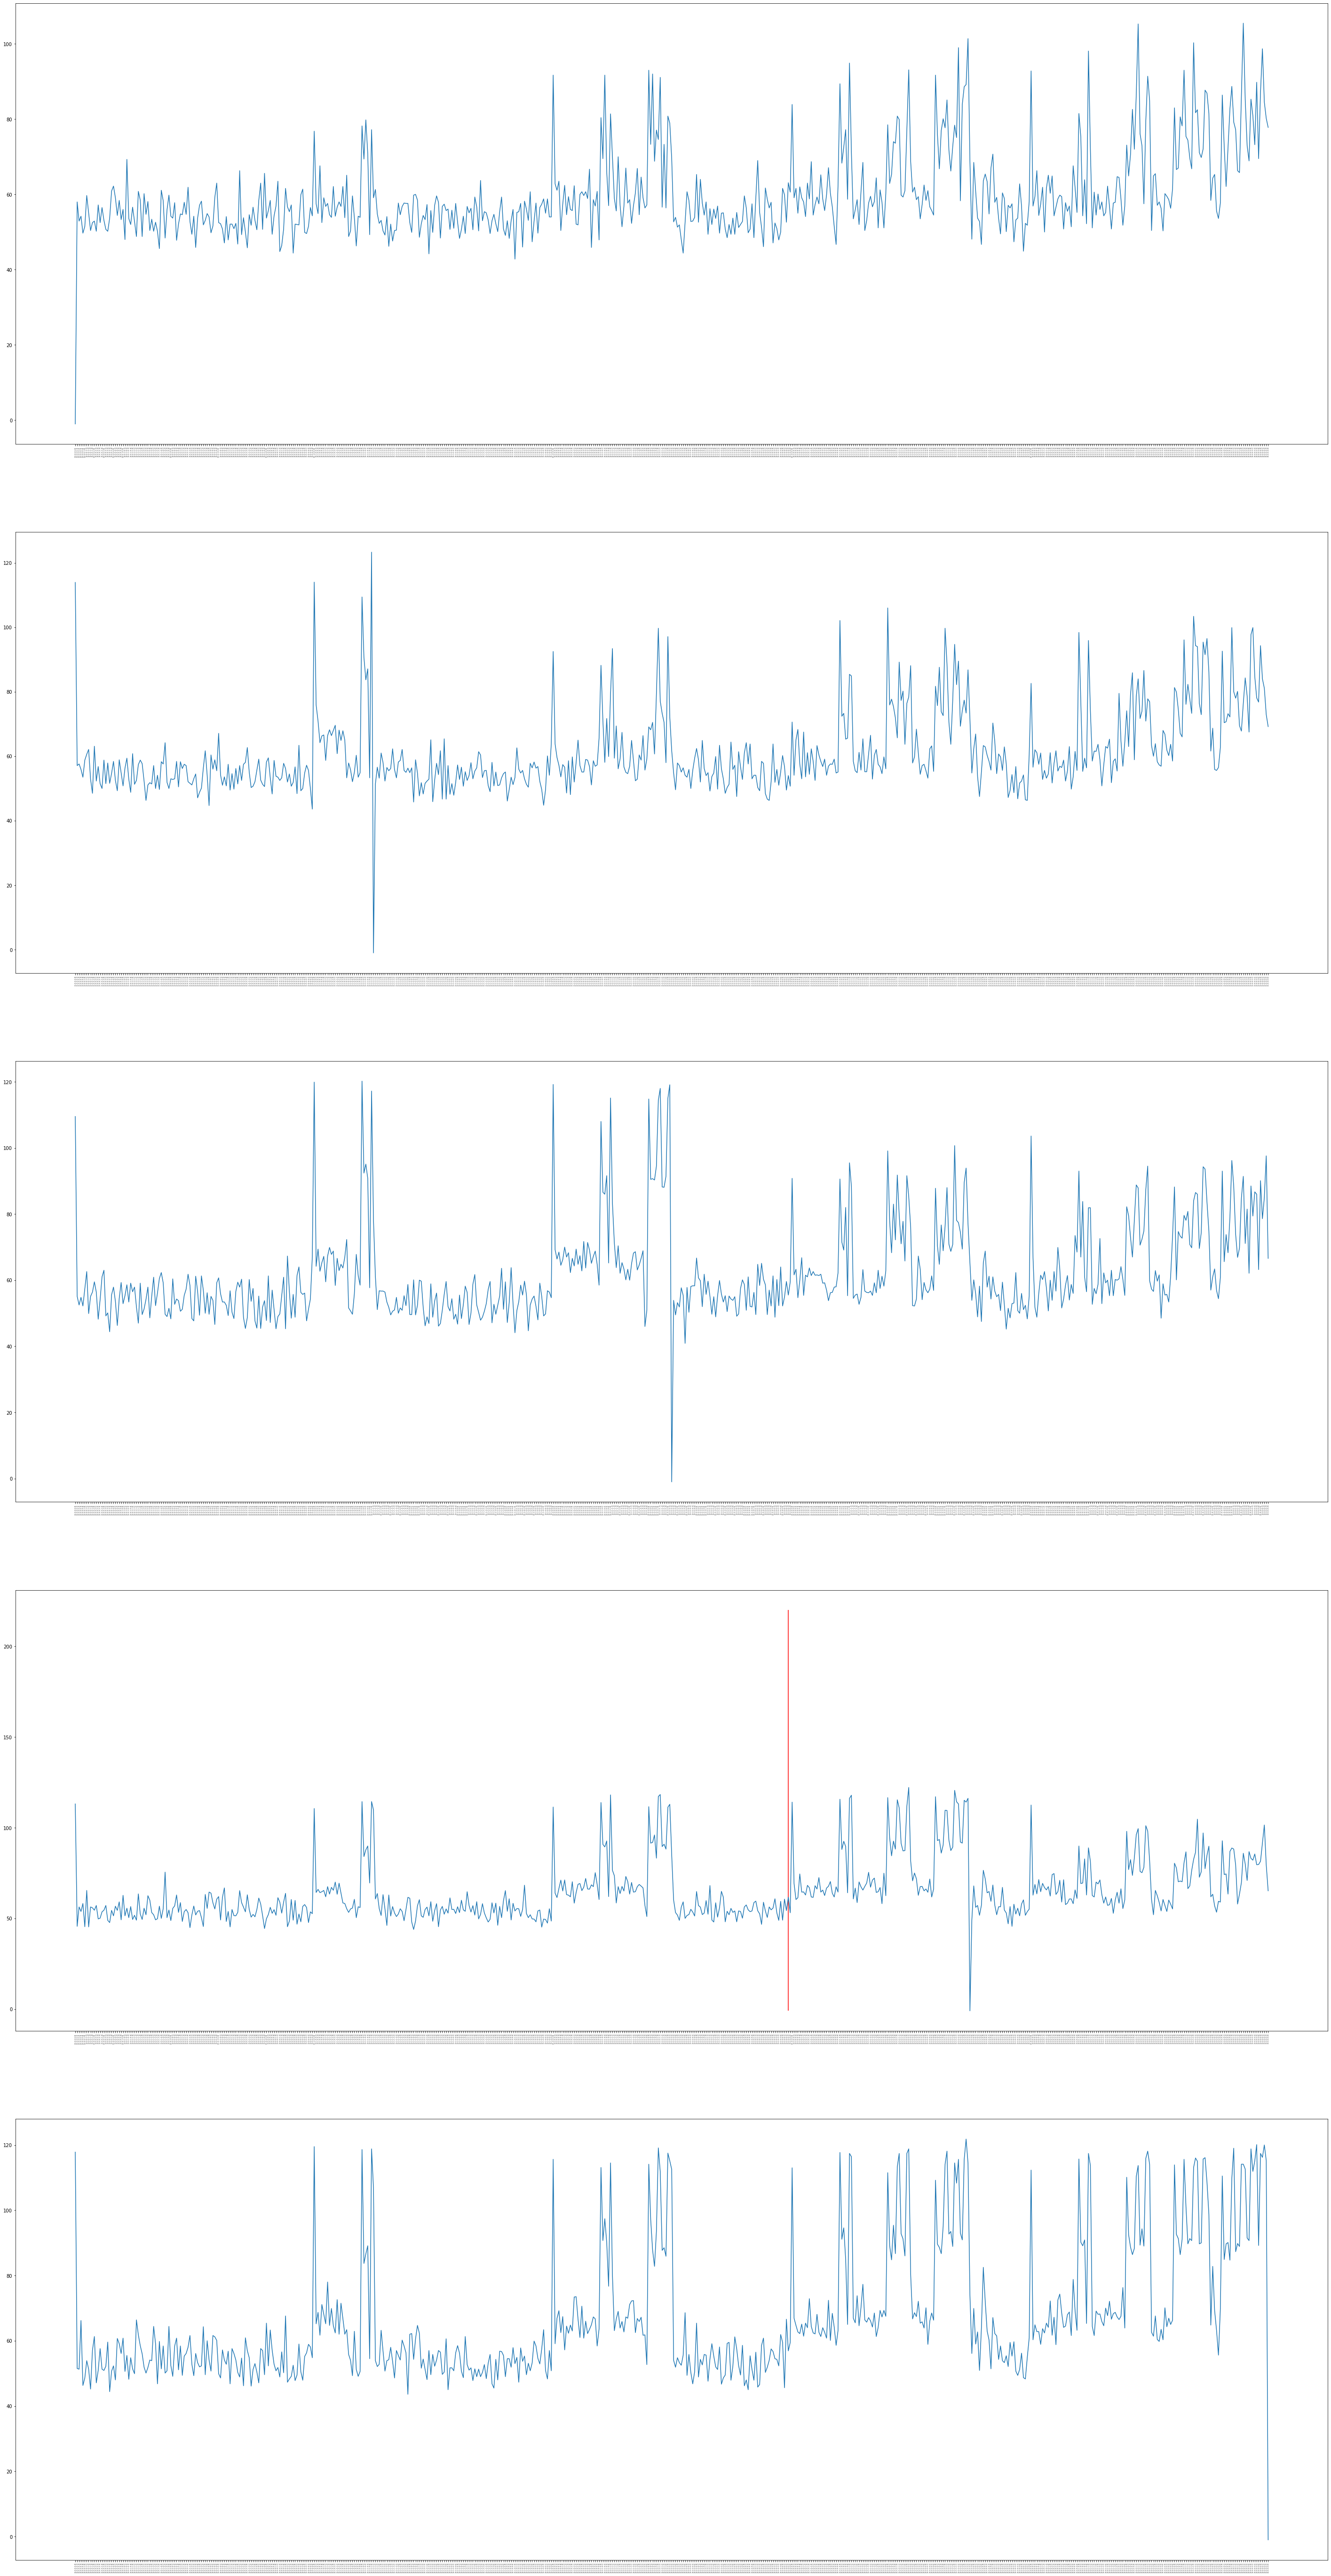

In [94]:
fig, axs = plt.subplots(5,1,figsize=(50,100))
a = axs[0].plot([r for r in rr if r[1]=='0'], avgs[0:625])
a = axs[1].plot([r for r in rr if r[1]=='1'], avgs[625:1250])
a = axs[2].plot([r for r in rr if r[1]=='2'], avgs[1250:1875])
a = axs[3].plot([r for r in rr if r[1]=='3'], avgs[1875:2500])
a = axs[4].plot([r for r in rr if r[1]=='4'], avgs[2500:])

plt.sca(axs[0])
plt.xticks(range(len([r for r in rr if r[1]=='0'])), [r for r in rr if r[1]=='0'], fontsize=3, rotation = 90)
plt.sca(axs[1])
plt.xticks(range(len([r for r in rr if r[1]=='1'])), [r for r in rr if r[1]=='1'], fontsize=3, rotation = 90)
plt.sca(axs[2])
plt.xticks(range(len([r for r in rr if r[1]=='2'])), [r for r in rr if r[1]=='2'], fontsize=3, rotation = 90)
plt.sca(axs[3])
plt.xticks(range(len([r for r in rr if r[1]=='3'])), [r for r in rr if r[1]=='3'], fontsize=3, rotation = 90)
axs[3].vlines(373,-1,220,color='red')
plt.sca(axs[4])
plt.xticks(range(len([r for r in rr if r[1]=='4'])), [r for r in rr if r[1]=='4'], fontsize=3, rotation = 90)

plt.show()

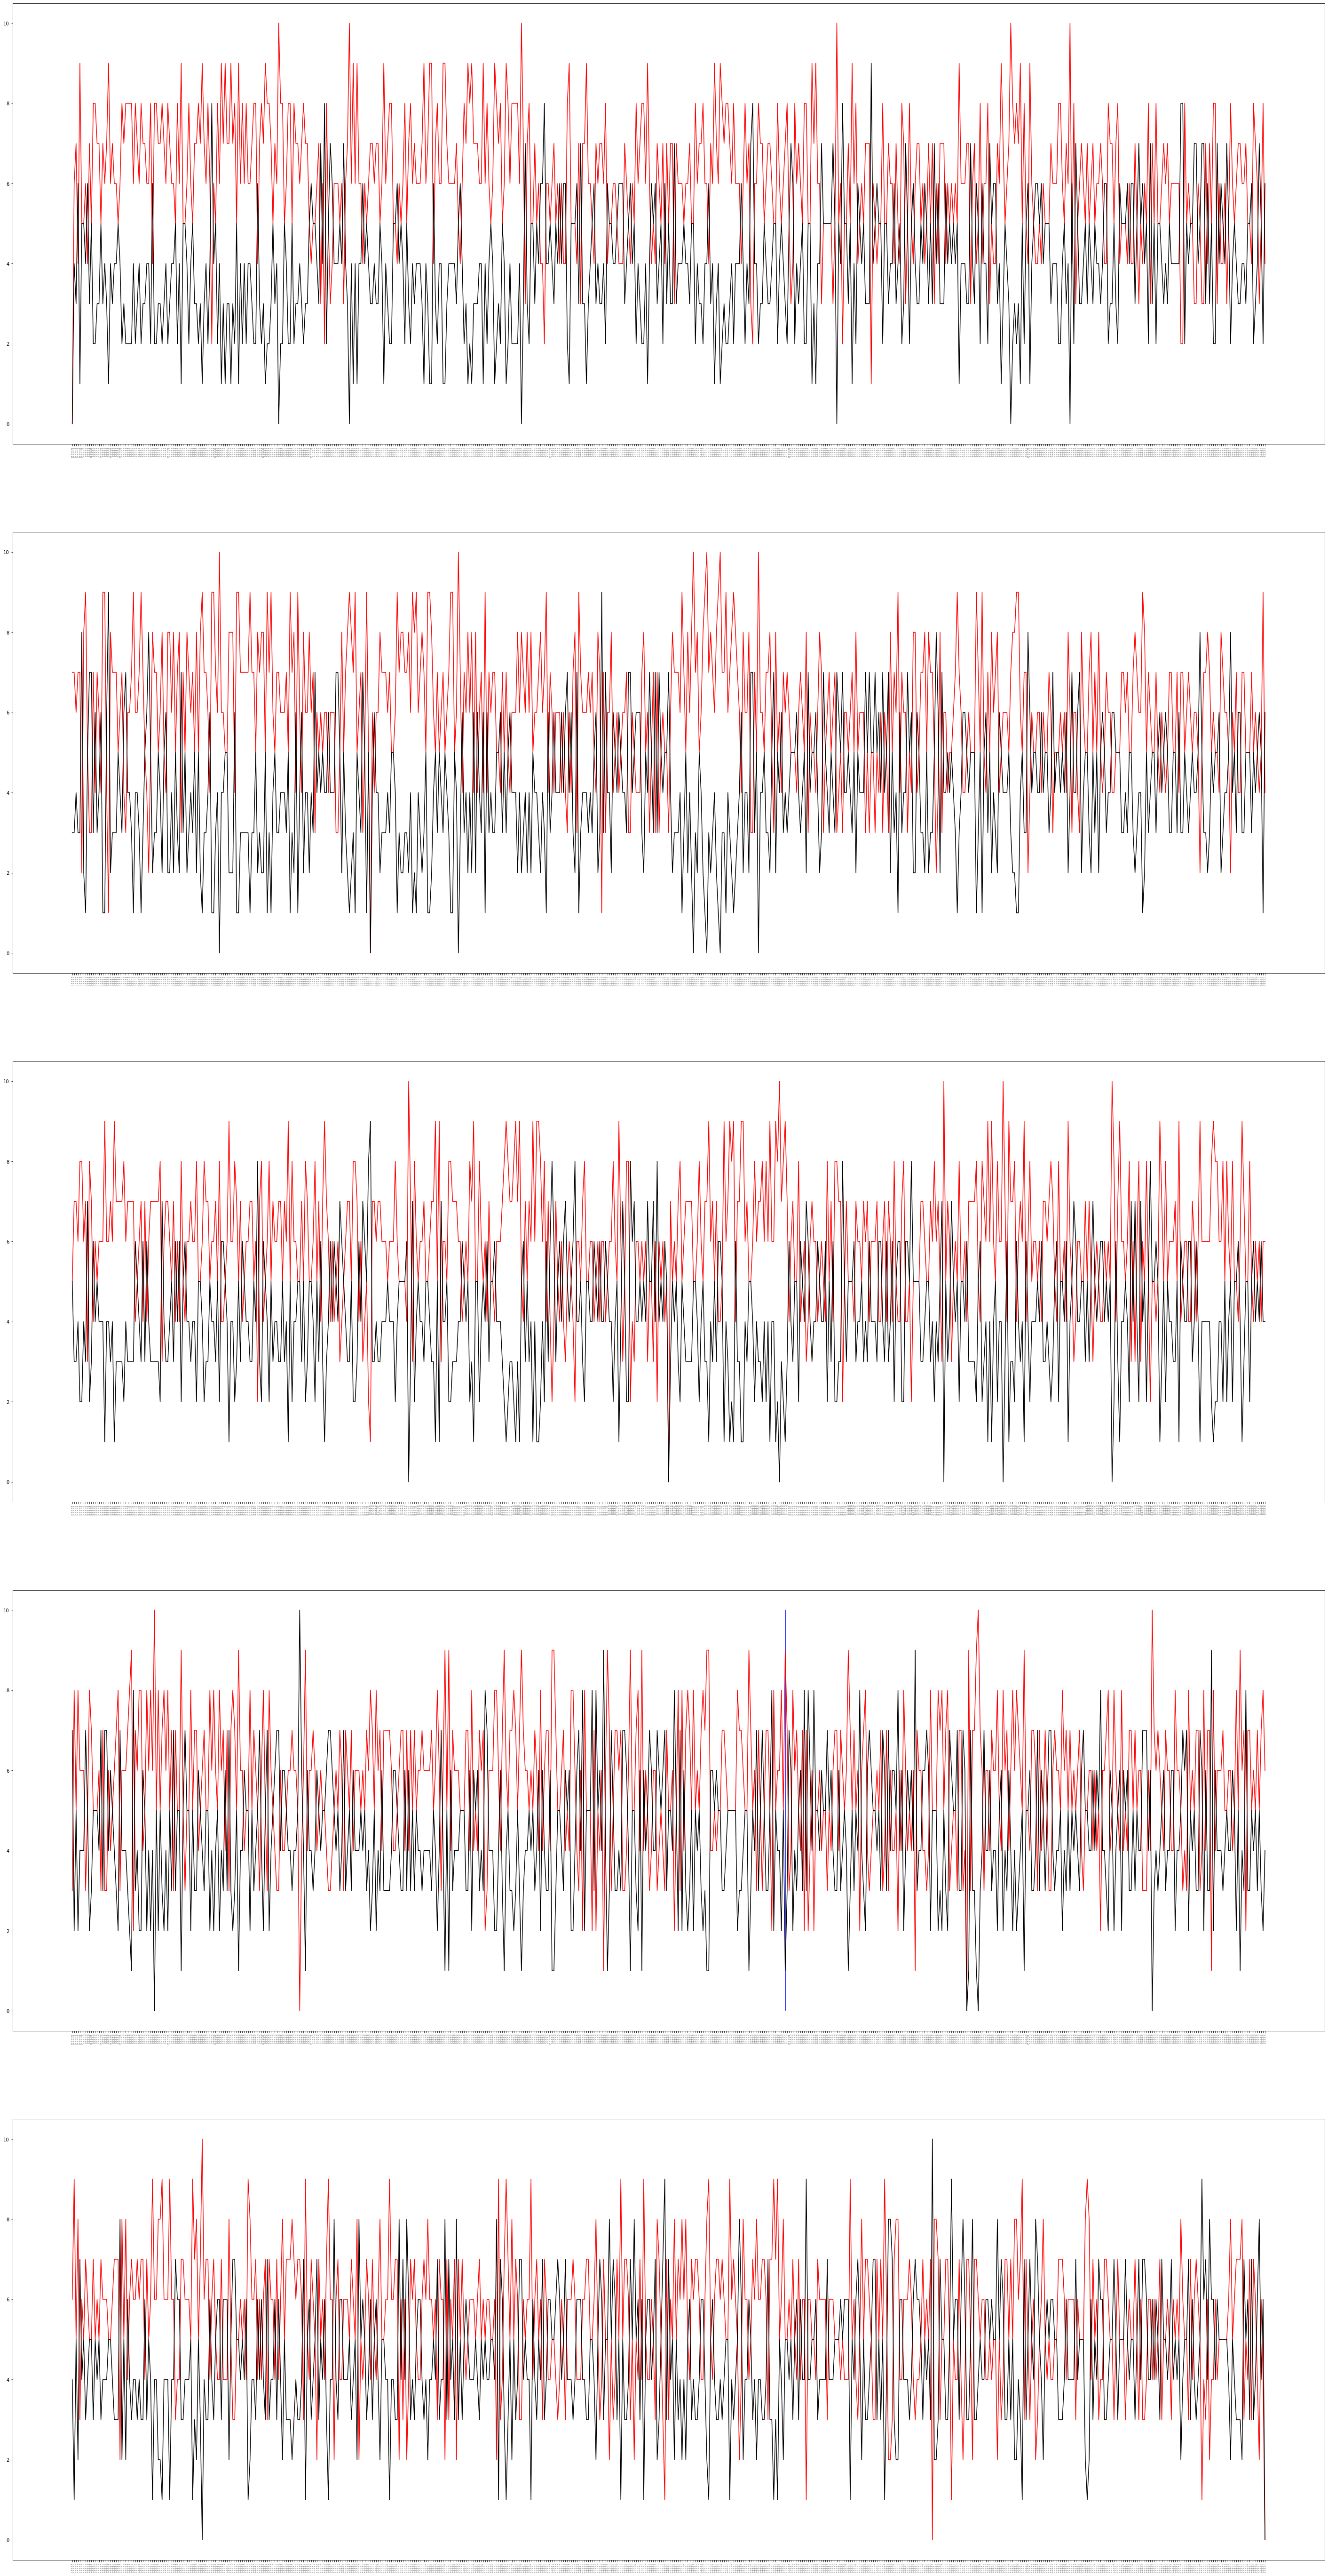

In [111]:
player_wins = [i.count('player') for i in all_winners]
computer_wins = [i.count('computer') for i in all_winners]

fig, axs = plt.subplots(5,1,figsize=(50,100))
a = axs[0].plot([r for r in rr if r[1]=='0'], player_wins[0:625], color='r')
a = axs[1].plot([r for r in rr if r[1]=='1'], player_wins[625:1250], color='r')
a = axs[2].plot([r for r in rr if r[1]=='2'], player_wins[1250:1875], color='r')
a = axs[3].plot([r for r in rr if r[1]=='3'], player_wins[1875:2500], color='r')
a = axs[4].plot([r for r in rr if r[1]=='4'], player_wins[2500:], color='r')

a = axs[0].plot([r for r in rr if r[1]=='0'], computer_wins[0:625], color='k')
a = axs[1].plot([r for r in rr if r[1]=='1'], computer_wins[625:1250], color='k')
a = axs[2].plot([r for r in rr if r[1]=='2'], computer_wins[1250:1875], color='k')
a = axs[3].plot([r for r in rr if r[1]=='3'], computer_wins[1875:2500], color='k')
a = axs[4].plot([r for r in rr if r[1]=='4'], computer_wins[2500:], color='k')

plt.sca(axs[0])
plt.xticks(range(len([r for r in rr if r[1]=='0'])), [r for r in rr if r[1]=='0'], fontsize=3, rotation = 90)
plt.sca(axs[1])
plt.xticks(range(len([r for r in rr if r[1]=='1'])), [r for r in rr if r[1]=='1'], fontsize=3, rotation = 90)
plt.sca(axs[2])
plt.xticks(range(len([r for r in rr if r[1]=='2'])), [r for r in rr if r[1]=='2'], fontsize=3, rotation = 90)
plt.sca(axs[3])
plt.xticks(range(len([r for r in rr if r[1]=='3'])), [r for r in rr if r[1]=='3'], fontsize=3, rotation = 90)
axs[3].vlines(373,0,10,color='blue')
plt.sca(axs[4])
plt.xticks(range(len([r for r in rr if r[1]=='4'])), [r for r in rr if r[1]=='4'], fontsize=3, rotation = 90)

plt.show()